In [2]:
def filter_for_ccps(tracks_to_check,
                    minimum_dnm2_counts=3,
                    sig_pval_cutoff=0.01,
                    minimum_lifetime=20,
                    maximum_lifetime=180,
                    initial_msd_threshold=0.02,
                    pixel_size=0.108):
    
    """return tracks that are sufficiently DNM2 rich, not too long or not too short, and aren’t too speedy"""
    tracks_kept = [] # the CCPs we’re keeping
    for i in tqdm(range(len(tracks_to_check))): # iterate through all tracks
        # iterate through tracks that satisfy a condition:
        # and make sure track is category 1 (valids with good gaps)
        track_lifetime = return_track_attributes.return_track_lifetime(tracks_to_check, i)
        pvals = tracks_to_check[i][index_dictionary['index_pval_Ar']][1]
        significant_pval_indices = [1 if pval < sig_pval_cutoff else 0 for pval in pvals]
        repeated_indices = [(x[0], len(list(x[1]))) for x in itertools.groupby(significant_pval_indices)]
        max_1s = 0
        for itm in repeated_indices:
            if itm[0] == 1:
                if itm[1]>max_1s:
                    max_1s=itm[1]
        max_dnm2_repeats = max_1s
        initial_msd = tracks_to_check[i][index_dictionary['index_MotionAnalysis']][0][0][1][0][0]
        initial_msd = pixel_size**2 * initial_msd
       
        if track_lifetime >= minimum_lifetime and \
           track_lifetime <= maximum_lifetime and \
           max_dnm2_repeats >= minimum_dnm2_counts and \
           initial_msd <= initial_msd_threshold:
            tracks_kept.append(tracks_to_check[i])
    return tracks_kept

In [3]:
def filter_for_ccps_with_nef(tracks_to_check,
                    minimum_nef_counts=4,
                    sig_pval_cutoff=0.01):
    
    """return tracks that are sufficiently nef rich, not too long or not too short, and aren’t too speedy"""
    tracks_kept = [] # the CCPs we’re keeping
    tracks_discarded = []
    for i in tqdm(range(len(tracks_to_check))): # iterate through all tracks
        # iterate through tracks that satisfy a condition:
        # and make sure track is category 1 (valids with good gaps)
        pvals = tracks_to_check[i][index_dictionary['index_pval_Ar']][2]
        significant_pval_indices = [1 if pval < sig_pval_cutoff else 0 for pval in pvals]
        repeated_indices = [(x[0], len(list(x[1]))) for x in itertools.groupby(significant_pval_indices)]
        max_1s = 0
        for itm in repeated_indices:
            if itm[0] == 1:
                if itm[1]>max_1s:
                    max_1s=itm[1]
        max_nef_repeats = max_1s
    
       
        if max_nef_repeats >= minimum_nef_counts:
            tracks_kept.append(tracks_to_check[i])
        else:
            tracks_discarded.append(tracks_to_check[i])
#     print(len(tracks_kept), len(tracks_discarded))
    return tracks_kept, tracks_discarded

In [4]:
# Function for detecting frame positions for the longest statistically significant consecutive detection of a non-coat channel.
# Returns these frame positions as a list with same index as tracks. 
def channel_consecutive_coloc_frametimes(tracks_to_check,
                                         channel_id,
                                         sig_pval_cutoff=0.01):
    frame_starts = []
    frame_ends = []
    
    for i in tqdm(range(len(tracks_to_check))): # iterate through all tracks
        # iterate through tracks that satisfy a condition:
        # and make sure track is category 1 (valids with good gaps)
        pvals = tracks_to_check[i][index_dictionary['index_pval_Ar']][channel_id]
        significant_pval_indices = [1 if pval < sig_pval_cutoff else 0 for pval in pvals]
        repeated_indices = [(x[0], len(list(x[1]))) for x in itertools.groupby(significant_pval_indices)]
        #print(repeated_indices)
    
        #code for detecting which tuple has highest # of consecutive detections. 
        #If there are multiple tuples with the highest number, the tuple that appears latest on the list is selected
        coloc_frame = max([x for x, y in enumerate(repeated_indices) if
                         (repeated_indices[x][1] == max(repeated_indices)[1] and
                          repeated_indices[x][0] == 1)])
        
        start = 0
        end = 0
        for k in range(coloc_frame):
            start += repeated_indices[k][1]

        end = start + repeated_indices[coloc_frame][1]
        
        frame_starts.append(start)
        frame_ends.append(end)
        
    return frame_starts, frame_ends

In [5]:
# Function for detecting frame positions for the longest statistically significant consecutive detection of Nef.
# Returns these frame positions as a list with same index as tracks. 
def nef_consecutive_coloc_frametimes(tracks_to_check, 
                                     sig_pval_cutoff=0.01):
    frame_starts = []
    frame_ends = []
    
    for i in tqdm(range(len(tracks_to_check))): # iterate through all tracks
        # iterate through tracks that satisfy a condition:
        # and make sure track is category 1 (valids with good gaps)
        pvals = tracks_to_check[i][index_dictionary['index_pval_Ar']][2]
        significant_pval_indices = [1 if pval < sig_pval_cutoff else 0 for pval in pvals]
        repeated_indices = [(x[0], len(list(x[1]))) for x in itertools.groupby(significant_pval_indices)]
        #print(repeated_indices)
    
        #code for detecting which tuple has highest # of consecutive detections. 
        #If there are multiple tuples with the highest number, the tuple that appears latest on the list is selected
        nef_frame = max([x for x, y in enumerate(repeated_indices) if
                         (repeated_indices[x][1] == max(repeated_indices)[1] and
                          repeated_indices[x][0] == 1)])
        
        start = 0
        end = 0
        for k in range(nef_frame):
            start += repeated_indices[k][1]

        end = start + repeated_indices[nef_frame][1]
        
        frame_starts.append(start)
        frame_ends.append(end)
        
    return frame_starts, frame_ends

In [6]:
#function to calculate the mean displacement of each channel within the indicated frame bounds. Displacement is calculated by comparing the postion at t and t-1. Use the function 
#channel_consecutive_coloc_frametimes to obtain a list that indicates when the frame starts and a list that indicates when the frame ends for each track
def mean_distance_difference_filter(tracks_to_check,
                             channel_0,
                             channel_1,
                             frame_starts,
                             frame_ends,
                             mean_distance_threshold):
    
    tracks_kept = [] # the CCPs we’re keeping
    tracks_discarded = [] # the CCPs we're discarding
    
    for i in tqdm(range(len(tracks_to_check))): # iterate through all tracks
        # iterate through tracks that satisfy a condition:
        xpos_c0 = tracks_to_check[i][index_dictionary['index_x_pos']][channel_0]
        ypos_c0 = tracks_to_check[i][index_dictionary['index_y_pos']][channel_0]
        
        xpos_c1 = tracks_to_check[i][index_dictionary['index_x_pos']][channel_1]
        ypos_c1 = tracks_to_check[i][index_dictionary['index_y_pos']][channel_1]
        
        distance_difference = []

        for j in range(frame_starts[i], frame_ends[i]):
            distance_difference.append(np.sqrt((xpos_c0[j]-xpos_c1[j])**2 + (ypos_c0[j]-ypos_c1[j])**2))
        
        mean_distance_difference = np.sum(distance_difference)/len(distance_difference)
        
        if mean_distance_difference < mean_distance_threshold:
            tracks_kept.append(tracks_to_check[i])
        else:
            tracks_discarded.append(tracks_to_check[i])
            
    return tracks_kept, tracks_discarded

In [7]:
def filter_for_ccps(tracks_to_check,
                    minimum_dnm2_counts=3,
                    sig_pval_cutoff=0.01,
                    minimum_lifetime=20,
                    maximum_lifetime=180,
                    initial_msd_threshold=0.02,
                    pixel_size=0.108):
                    
    """return tracks that are sufficiently DNM2 rich, not too long or not too short, and aren’t too speedy"""
    tracks_kept = [] # the CCPs we’re keeping
    for i in tqdm(range(len(tracks_to_check))): # iterate through all tracks
        # iterate through tracks that satisfy a condition:
        # and make sure track is category 1 (valids with good gaps)
        track_lifetime = return_track_attributes.return_track_lifetime(tracks_to_check, i)
        pvals = tracks_to_check[i][index_dictionary['index_pval_Ar']][1]
        significant_pval_indices = [1 if pval < sig_pval_cutoff else 0 for pval in pvals]
        repeated_indices = [(x[0], len(list(x[1]))) for x in itertools.groupby(significant_pval_indices)]
        max_1s = 0
        for itm in repeated_indices:
            if itm[0] == 1:
                if itm[1]>max_1s:
                    max_1s=itm[1]
        max_dnm2_repeats = max_1s
        initial_msd = tracks_to_check[i][index_dictionary['index_MotionAnalysis']][0][0][1][0][0]
        initial_msd = pixel_size**2 * initial_msd
       
        if track_lifetime >= minimum_lifetime and \
           track_lifetime <= maximum_lifetime and \
           max_dnm2_repeats >= minimum_dnm2_counts and \
           initial_msd <= initial_msd_threshold:
            tracks_kept.append(tracks_to_check[i])
    return tracks_kept

In [8]:
def filter_for_ccps_with_nef(tracks_to_check,
                    minimum_nef_counts=4,
                    sig_pval_cutoff=0.01):
    
    """return tracks that are sufficiently nef rich, not too long or not too short, and aren’t too speedy"""
    tracks_kept = [] # the CCPs we’re keeping
    tracks_discarded = []
    for i in tqdm(range(len(tracks_to_check))): # iterate through all tracks
        # iterate through tracks that satisfy a condition:
        # and make sure track is category 1 (valids with good gaps)
        pvals = tracks_to_check[i][index_dictionary['index_pval_Ar']][2]
        significant_pval_indices = [1 if pval < sig_pval_cutoff else 0 for pval in pvals]
        repeated_indices = [(x[0], len(list(x[1]))) for x in itertools.groupby(significant_pval_indices)]
        max_1s = 0
        for itm in repeated_indices:
            if itm[0] == 1:
                if itm[1]>max_1s:
                    max_1s=itm[1]
        max_nef_repeats = max_1s
    
       
        if max_nef_repeats >= minimum_nef_counts:
            tracks_kept.append(tracks_to_check[i])
        else:
            tracks_discarded.append(tracks_to_check[i])
#     print(len(tracks_kept), len(tracks_discarded))
    return tracks_kept, tracks_discarded

In [9]:
# Function for detecting frame positions for the longest statistically significant consecutive detection of a non-coat channel.
# Returns these frame positions as a list with same index as tracks. 
def channel_consecutive_coloc_frametimes(tracks_to_check,
                                         channel_id,
                                         sig_pval_cutoff=0.01):
    frame_starts = []
    frame_ends = []
    
    for i in tqdm(range(len(tracks_to_check))): # iterate through all tracks
        # iterate through tracks that satisfy a condition:
        # and make sure track is category 1 (valids with good gaps)
        pvals = tracks_to_check[i][index_dictionary['index_pval_Ar']][channel_id]
        significant_pval_indices = [1 if pval < sig_pval_cutoff else 0 for pval in pvals]
        repeated_indices = [(x[0], len(list(x[1]))) for x in itertools.groupby(significant_pval_indices)]
        #print(repeated_indices)
    
        #code for detecting which tuple has highest # of consecutive detections. 
        #If there are multiple tuples with the highest number, the tuple that appears latest on the list is selected
        coloc_frame = max([x for x, y in enumerate(repeated_indices) if
                         (repeated_indices[x][1] == max(repeated_indices)[1] and
                          repeated_indices[x][0] == 1)])
        
        start = 0
        end = 0
        for k in range(coloc_frame):
            start += repeated_indices[k][1]

        end = start + repeated_indices[coloc_frame][1]
        
        frame_starts.append(start)
        frame_ends.append(end)
        
    return frame_starts, frame_ends

In [10]:
# Function for detecting frame positions for the longest statistically significant consecutive detection of Nef.
# Returns these frame positions as a list with same index as tracks. 
def nef_consecutive_coloc_frametimes(tracks_to_check, 
                                     sig_pval_cutoff=0.01):
    frame_starts = []
    frame_ends = []
    
    for i in tqdm(range(len(tracks_to_check))): # iterate through all tracks
        # iterate through tracks that satisfy a condition:
        # and make sure track is category 1 (valids with good gaps)
        pvals = tracks_to_check[i][index_dictionary['index_pval_Ar']][2]
        significant_pval_indices = [1 if pval < sig_pval_cutoff else 0 for pval in pvals]
        repeated_indices = [(x[0], len(list(x[1]))) for x in itertools.groupby(significant_pval_indices)]
        #print(repeated_indices)
    
        #code for detecting which tuple has highest # of consecutive detections. 
        #If there are multiple tuples with the highest number, the tuple that appears latest on the list is selected
        nef_frame = max([x for x, y in enumerate(repeated_indices) if
                         (repeated_indices[x][1] == max(repeated_indices)[1] and
                          repeated_indices[x][0] == 1)])
        
        start = 0
        end = 0
        for k in range(nef_frame):
            start += repeated_indices[k][1]

        end = start + repeated_indices[nef_frame][1]
        
        frame_starts.append(start)
        frame_ends.append(end)
        
    return frame_starts, frame_ends

In [11]:
#function to calculate the mean displacement of each channel within the indicated frame bounds. Displacement is calculated by comparing the postion at t and t-1. Use the function 
#channel_consecutive_coloc_frametimes to obtain a list that indicates when the frame starts and a list that indicates when the frame ends for each track
def mean_distance_difference_filter(tracks_to_check,
                             channel_0,
                             channel_1,
                             frame_starts,
                             frame_ends,
                             mean_distance_threshold):
    
    tracks_kept = [] # the CCPs we’re keeping
    tracks_discarded = [] # the CCPs we're discarding
    
    for i in tqdm(range(len(tracks_to_check))): # iterate through all tracks
        # iterate through tracks that satisfy a condition:
        xpos_c0 = tracks_to_check[i][index_dictionary['index_x_pos']][channel_0]
        ypos_c0 = tracks_to_check[i][index_dictionary['index_y_pos']][channel_0]
        
        xpos_c1 = tracks_to_check[i][index_dictionary['index_x_pos']][channel_1]
        ypos_c1 = tracks_to_check[i][index_dictionary['index_y_pos']][channel_1]
        
        distance_difference = []

        for j in range(frame_starts[i], frame_ends[i]):
            distance_difference.append(np.sqrt((xpos_c0[j]-xpos_c1[j])**2 + (ypos_c0[j]-ypos_c1[j])**2))
        
        mean_distance_difference = np.sum(distance_difference)/len(distance_difference)
        
        if mean_distance_difference < mean_distance_threshold:
            tracks_kept.append(tracks_to_check[i])
        else:
            tracks_discarded.append(tracks_to_check[i])
            
    return tracks_kept, tracks_discarded

In [12]:
# Function form of max_consecutive calculation with tolerance. This should calculate lifetimes with gap lengths just like for the coat channel. 
def max_consecutive_with_gap (tracks_to_check, 
                              sig_pval_cutoff=0.01,
                              channel = 1,
                              gap = 2,
                              framerate = 2):
    
    gap_tolerated_lifetime = []
    
    for i in tqdm(range(len(tracks_to_check))): # iterate through all tracks
        # iterate through tracks that satisfy a condition:
        # and make sure track is category 1 (valids with good gaps)
        pvals = tracks_to_check[i][index_dictionary['index_pval_Ar']][channel]
        significant_pval_indices = [1 if pval < sig_pval_cutoff else 0 for pval in pvals]
        repeated_indices = [(x[0], len(list(x[1]))) for x in itertools.groupby(significant_pval_indices)]
        #print(repeated_indices)
        
        gap_tolerated_repeated_indices = []
        
        for ii in range(len((repeated_indices))):
            if ((ii != 0) & (repeated_indices[ii][0] == 0) & (repeated_indices[ii][1] <= gap) & (ii != (len(repeated_indices)) - 1)):
                gap_tolerated_repeated_indices.append((1, repeated_indices[ii][1]))
            else:
                gap_tolerated_repeated_indices.append(repeated_indices[ii])
        
        gap_tolerated_max_consecutive = 0
        temp_consecutive = 0
        
        #print(repeated_indices)
        #print(gap_tolerated_repeated_indices)
        
        for ii in range(len((gap_tolerated_repeated_indices))):
            if (gap_tolerated_repeated_indices[ii][0] == 0):
                temp_consecutive = 0
            else:
                temp_consecutive += gap_tolerated_repeated_indices[ii][1]

            gap_tolerated_max_consecutive = max(temp_consecutive, gap_tolerated_max_consecutive)
            #print('index')
            #print(ii)
            #print('detection')
            #print(gap_tolerated_repeated_indices[ii][0])
            #print('value')
            #print(gap_tolerated_repeated_indices[ii][1])
        gap_tolerated_lifetime.append(gap_tolerated_max_consecutive * framerate)
        
    return gap_tolerated_lifetime

# import all necessary Python modules

In [13]:
%load_ext autoreload
%autoreload 2
import os
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Image
import itertools
import scipy.interpolate as interpolate
import re
import seaborn as sns
import random
import scipy.stats as stats

#sys.path.append(unique_user_path_notebook+'/cmeAnalysisPostProcessingPythonScripts') # add custom Python scripts to the local path
import display_tracks
import merge_tools
import feature_extraction_with_buffer
import generate_index_dictionary
import return_track_attributes

# batch load nef tracks

-1 is untransfected, 0 is wild type Nef, 1 is LLAA Nef, 2 is D123A Nef.

Loading 1st replicate

In [14]:
tracks_path_1 = 'I:/Analysis/NA7NefCme/AP2DNM2NA7Nef_mutant_segment_good_1/20211111'
track_directories_1 = os.listdir(tracks_path_1)

exp_date_1 = 20211111

In [15]:
movie_number_1 = []
cell_number_1 = []
cell_condition_1 = []
cell_id = []
all_tracks_1 = []

condition_map_1 = {'1':-1,
                 '2':-1,
                 '3':-1,
                 '4':0,
                 '5':0,
                 '6':0,
                 '7':2,
                 '8':2,
                 '9':2,
                 '10':1,
                 '11':1,
                 '12':1}

for cell in track_directories_1:
    split = re.split('-|_',cell)
    movie_number_1.append(split[0][4:])
    cell_number_1.append(split[1])
    cell_condition_1.append(condition_map_1[movie_number_1[-1]])
    all_tracks_1.append(display_tracks.load_tracks(tracks_path_1+'/'+cell+'/Ch1/Tracking/ProcessedTracks.mat'))


Loading 2nd replicate

In [16]:
tracks_path_2 = 'I:/Analysis/NA7NefCme/AP2DNM2NA7Nef_mutant_segment_good_2/20211119'
track_directories_2 = os.listdir(tracks_path_2)

exp_date_2 = 20211119

In [17]:
movie_number_2 = []
cell_number_2 = []
cell_condition_2 = []
all_tracks_2 = []

condition_map_2 = {'1':-1,
                 '2':-1,
                 '3':-1,
                 '4':0,
                 '5':0,
                 '6':0,
                 '7':2,
                 '8':2,
                 '9':2,
                 '10':1,
                 '11':1,
                 '12':1}

for cell in track_directories_2:
    split = re.split('-|_',cell)
    movie_number_2.append(split[0][4:])
    cell_number_2.append(split[1])
    cell_condition_2.append(condition_map_2[movie_number_2[-1]])
    all_tracks_2.append(display_tracks.load_tracks(tracks_path_2+'/'+cell+'/Ch1/Tracking/ProcessedTracks.mat'))


Loading 3rd replicate

In [18]:
tracks_path_3 = 'I:/Analysis/NA7NefCme/AP2DNM2NA7Nef_mutant_segment_good_3/20220602'
track_directories_3 = os.listdir(tracks_path_3)

exp_date_3 = 20220602

In [19]:
movie_number_3 = []
cell_number_3 = []
cell_condition_3 = []
all_tracks_3 = []

condition_map_3 = {'1':-1,
                 '2':-1,
                 '3':-1,
                 '4':0,
                 '5':0,
                 '6':0,
                 '7':2,
                 '8':2,
                 '9':2,
                 '10':1,
                 '11':1,
                 '12':1}

for cell in track_directories_3:
    split = re.split('-|_',cell)
    movie_number_3.append(split[0][4:])
    cell_number_3.append(split[1])
    cell_condition_3.append(condition_map_3[movie_number_3[-1]])
    all_tracks_3.append(display_tracks.load_tracks(tracks_path_3+'/'+cell+'/Ch1/Tracking/ProcessedTracks.mat'))


In [20]:
index_dictionary = generate_index_dictionary.return_index_dictionary()


# Filtering Nef tracks

Filtering Nef tracks for 1st replicate

In [21]:
valid_tracks_1 = []

for tracks in all_tracks_1:
    
    valid_tracks_1.append(display_tracks.remove_tracks_by_criteria(tracks, track_category=[1]))

The number of tracks returned: 223

The number of tracks returned: 474

The number of tracks returned: 435

The number of tracks returned: 223

The number of tracks returned: 326

The number of tracks returned: 309

The number of tracks returned: 252

The number of tracks returned: 218

The number of tracks returned: 225

The number of tracks returned: 155

The number of tracks returned: 354

The number of tracks returned: 247

The number of tracks returned: 64

The number of tracks returned: 101

The number of tracks returned: 158

The number of tracks returned: 73

The number of tracks returned: 154

The number of tracks returned: 87

The number of tracks returned: 38

The number of tracks returned: 172

The number of tracks returned: 145

The number of tracks returned: 80

The number of tracks returned: 217

The number of tracks returned: 163

The number of tracks returned: 154

The number of tracks returned: 106

The number of tracks returned: 128

The number of tracks returned: 15

In [22]:
filtered_valid_tracks_1 = []

for tracks in valid_tracks_1:
    
    tempFilteredTracks = filter_for_ccps(tracks,
                         minimum_dnm2_counts=3,
                         sig_pval_cutoff=0.01,
                         minimum_lifetime=20,
                         maximum_lifetime=300,
                         initial_msd_threshold=0.02,
                         pixel_size=0.108)
    print(len(tempFilteredTracks))
    filtered_valid_tracks_1.append(tempFilteredTracks)


  0%|                                                                                          | 0/154 [00:00<?, ?it/s]

53
57
73
31
35
24
23
30
41
26
68
20
12
25
25
24


  0%|                                                                                          | 0/377 [00:00<?, ?it/s]

35
14
16
22
22
17
24
34
23
29
38
19
17
17
11
5
28
11
15
16
33
35
15
17


100%|█████████████████████████████████████████████████████████████████████████████| 159/159 [00:00<00:00, 79496.29it/s]

69
24
31
35
44
33
41
18
28
27
22
29
22
9
28
26
18
40
7
17



  0%|                                                                                          | 0/178 [00:00<?, ?it/s]

16
15
51
16
8
48
44
5
32
14
27
38
40
26
42
21


  0%|                                                                                          | 0/199 [00:00<?, ?it/s]

4
6
22
25
11
15
5
32
28
29
44
35
17
39
23
19
32
25
32
10
15
10
34
23


100%|█████████████████████████████████████████████████████████████████████████████| 208/208 [00:00<00:00, 51941.85it/s]

32
49


In [23]:
filtered_valid_tracks_nef_positive_1 = []
filtered_valid_tracks_nef_negative_1 = []

for tracks in filtered_valid_tracks_1:
    
    nef_pos, nef_neg = filter_for_ccps_with_nef(tracks,
                                                minimum_nef_counts=4,
                                                sig_pval_cutoff=1e-25)
    
    num_neg = len(nef_neg)
    num_pos = len(nef_pos)
#     print(len(nef_neg))
    filtered_valid_tracks_nef_positive_1.append(nef_pos)
    filtered_valid_tracks_nef_negative_1.append(nef_neg)
    #print('fraction nef positive', num_pos/(num_pos + num_neg))

100%|███████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 48945.20it/s]


In [24]:
filtered_valid_tracks_nef_positive_frame_start_1 = []
filtered_valid_tracks_nef_positive_frame_end_1 = []

for tracks in filtered_valid_tracks_nef_positive_1:
    
    frame_start, frame_end = channel_consecutive_coloc_frametimes(tracks,
                                                                  2,
                                                                  sig_pval_cutoff=1e-25)
    
    filtered_valid_tracks_nef_positive_frame_start_1.append(frame_start)
    filtered_valid_tracks_nef_positive_frame_end_1.append(frame_end)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?

In [25]:
#filtering nef_positive_filtered_valid_tracks based on threshold value for mean distance between AP2 and Nef
pass_nef_positive_filtered_valid_tracks_1 = []
fail_nef_positive_filtered_valid_tracks_1 = []

for count, tracks in enumerate(filtered_valid_tracks_nef_positive_1):
    tracks_kept, tracks_discarded = mean_distance_difference_filter(tracks,
                                                                     0,
                                                                     2,
                                                                     filtered_valid_tracks_nef_positive_frame_start_1[count],
                                                                     filtered_valid_tracks_nef_positive_frame_end_1[count],
                                                                     1.25)
    
    pass_nef_positive_filtered_valid_tracks_1.append(tracks_kept)
    fail_nef_positive_filtered_valid_tracks_1.append(tracks_discarded)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.62it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 8992.08it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?

Filtering Nef tracks for 2nd replicate

In [26]:
valid_tracks_2 = []

for tracks in all_tracks_2:
    
    valid_tracks_2.append(display_tracks.remove_tracks_by_criteria(tracks, track_category=[1]))

The number of tracks returned: 269

The number of tracks returned: 1322

The number of tracks returned: 311

The number of tracks returned: 149

The number of tracks returned: 252

The number of tracks returned: 238

The number of tracks returned: 226

The number of tracks returned: 230

The number of tracks returned: 272

The number of tracks returned: 347

The number of tracks returned: 287

The number of tracks returned: 191

The number of tracks returned: 378

The number of tracks returned: 81

The number of tracks returned: 176

The number of tracks returned: 148

The number of tracks returned: 83

The number of tracks returned: 461

The number of tracks returned: 131

The number of tracks returned: 151

The number of tracks returned: 170

The number of tracks returned: 143

The number of tracks returned: 264

The number of tracks returned: 431

The number of tracks returned: 249

The number of tracks returned: 163

The number of tracks returned: 281

The number of tracks returned

In [27]:
filtered_valid_tracks_2 = []

for tracks in valid_tracks_2:
    
    tempFilteredTracks = filter_for_ccps(tracks,
                         minimum_dnm2_counts=3,
                         sig_pval_cutoff=0.01,
                         minimum_lifetime=20,
                         maximum_lifetime=300,
                         initial_msd_threshold=0.02,
                         pixel_size=0.108)
    print(len(tempFilteredTracks))
    filtered_valid_tracks_2.append(tempFilteredTracks)


  0%|                                                                                          | 0/222 [00:00<?, ?it/s]

36
41
21
24
14
17
30
65
24
32
49
23
15
1
35
24
17
37
30
23
30
10
30
37
28
21
38
17
20
34
7
31


100%|█████████████████████████████████████████████████████████████████████████████| 199/199 [00:00<00:00, 49729.89it/s]

9
12
21
9
13
15
20
22
15
33
4
2
22
9
23
7
27
7
18
14
17
54
55
41
25
28
30
18
40
51
22
30
16
27
36



100%|███████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 50930.83it/s]

7
15
17
29
17
7


In [28]:
filtered_valid_tracks_nef_positive_2 = []
filtered_valid_tracks_nef_negative_2= []

for tracks in filtered_valid_tracks_2:
    
    nef_pos, nef_neg = filter_for_ccps_with_nef(tracks,
                                                minimum_nef_counts=4,
                                                sig_pval_cutoff=1e-25)
    
    num_neg = len(nef_neg)
    num_pos = len(nef_pos)
#     print(len(nef_neg))
    filtered_valid_tracks_nef_positive_2.append(nef_pos)
    filtered_valid_tracks_nef_negative_2.append(nef_neg)
    #print('fraction nef positive', num_pos/(num_pos + num_neg))

100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<?, ?it/s]


In [29]:
filtered_valid_tracks_nef_positive_frame_start_2 = []
filtered_valid_tracks_nef_positive_frame_end_2 = []

for tracks in filtered_valid_tracks_nef_positive_2:
    
    frame_start, frame_end = channel_consecutive_coloc_frametimes(tracks,
                                                                  2,
                                                                  sig_pval_cutoff=1e-25)
    
    filtered_valid_tracks_nef_positive_frame_start_2.append(frame_start)
    filtered_valid_tracks_nef_positive_frame_end_2.append(frame_end)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████

In [30]:
#filtering nef_positive_filtered_valid_tracks based on threshold value for mean distance between AP2 and Nef
pass_nef_positive_filtered_valid_tracks_2 = []
fail_nef_positive_filtered_valid_tracks_2 = []

for count, tracks in enumerate(filtered_valid_tracks_nef_positive_2):
    tracks_kept, tracks_discarded = mean_distance_difference_filter(tracks,
                                                                     0,
                                                                     2,
                                                                     filtered_valid_tracks_nef_positive_frame_start_2[count],
                                                                     filtered_valid_tracks_nef_positive_frame_end_2[count],
                                                                     1.25)
    
    pass_nef_positive_filtered_valid_tracks_2.append(tracks_kept)
    fail_nef_positive_filtered_valid_tracks_2.append(tracks_discarded)


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.36it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 10992.93it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████

Filtering Nef tracks for 3rd replicate

In [31]:
valid_tracks_3 = []

for tracks in all_tracks_3:
    
    valid_tracks_3.append(display_tracks.remove_tracks_by_criteria(tracks, track_category=[1]))

The number of tracks returned: 399

The number of tracks returned: 294

The number of tracks returned: 245

The number of tracks returned: 232

The number of tracks returned: 367

The number of tracks returned: 235

The number of tracks returned: 352

The number of tracks returned: 272

The number of tracks returned: 197

The number of tracks returned: 236

The number of tracks returned: 253

The number of tracks returned: 188

The number of tracks returned: 231

The number of tracks returned: 139

The number of tracks returned: 264

The number of tracks returned: 172

The number of tracks returned: 112

The number of tracks returned: 204

The number of tracks returned: 228

The number of tracks returned: 218

The number of tracks returned: 317

The number of tracks returned: 76

The number of tracks returned: 106

The number of tracks returned: 229

The number of tracks returned: 255

The number of tracks returned: 420

The number of tracks returned: 108

The number of tracks returned

In [32]:
filtered_valid_tracks_3 = []

for tracks in valid_tracks_3:
    
    tempFilteredTracks = filter_for_ccps(tracks,
                         minimum_dnm2_counts=3,
                         sig_pval_cutoff=0.01,
                         minimum_lifetime=20,
                         maximum_lifetime=300,
                         initial_msd_threshold=0.02,
                         pixel_size=0.108)
    print(len(tempFilteredTracks))
    filtered_valid_tracks_3.append(tempFilteredTracks)


100%|█████████████████████████████████████████████████████████████████████████████| 267/267 [00:00<00:00, 53350.44it/s]

31
21
11
15
30
15
35
36
22
47
24
17
20
17
19
16
16
11
22
19
34
5
17
32
19
50
15
13
35
13
42
26
39
26
18



100%|█████████████████████████████████████████████████████████████████████████████| 244/244 [00:00<00:00, 60957.18it/s]

40
20
15
10
28
15
7
23
14
8
19
19
20
20
30
26
20
24
12
11
41
15
19
22


In [33]:
filtered_valid_tracks_nef_positive_3 = []
filtered_valid_tracks_nef_negative_3 = []

for tracks in filtered_valid_tracks_3:
    
    nef_pos, nef_neg = filter_for_ccps_with_nef(tracks,
                                                minimum_nef_counts=4,
                                                sig_pval_cutoff=1e-25)
    
    num_neg = len(nef_neg)
    num_pos = len(nef_pos)
#     print(len(nef_neg))
    filtered_valid_tracks_nef_positive_3.append(nef_pos)
    filtered_valid_tracks_nef_negative_3.append(nef_neg)
    #print('fraction nef positive', num_pos/(num_pos + num_neg))

100%|███████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 22001.59it/s]


In [34]:
filtered_valid_tracks_nef_positive_frame_start_3 = []
filtered_valid_tracks_nef_positive_frame_end_3 = []

for tracks in filtered_valid_tracks_nef_positive_3:
    
    frame_start, frame_end = channel_consecutive_coloc_frametimes(tracks,
                                                                  2,
                                                                  sig_pval_cutoff=1e-25)
    
    filtered_valid_tracks_nef_positive_frame_start_3.append(frame_start)
    filtered_valid_tracks_nef_positive_frame_end_3.append(frame_end)

0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 7991.05it/s]


In [35]:
#filtering nef_positive_filtered_valid_tracks based on threshold value for mean distance between AP2 and Nef
pass_nef_positive_filtered_valid_tracks_3 = []
fail_nef_positive_filtered_valid_tracks_3 = []

for count, tracks in enumerate(filtered_valid_tracks_nef_positive_3):
    tracks_kept, tracks_discarded = mean_distance_difference_filter(tracks,
                                                                     0,
                                                                     2,
                                                                     filtered_valid_tracks_nef_positive_frame_start_3[count],
                                                                     filtered_valid_tracks_nef_positive_frame_end_3[count],
                                                                     1.25)
    
    pass_nef_positive_filtered_valid_tracks_3.append(tracks_kept)
    fail_nef_positive_filtered_valid_tracks_3.append(tracks_discarded)


0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 2000.62it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 8000.58it/s]


# Creating master lists

In [36]:
len(filtered_valid_tracks_1)

102

In [37]:
len(filtered_valid_tracks_2)

73

In [38]:
len(filtered_valid_tracks_3)

59

In [39]:
# Master Filtered valid tracks
filtered_valid_tracks_master = []

filtered_valid_tracks_master.extend(filtered_valid_tracks_1)
filtered_valid_tracks_master.extend(filtered_valid_tracks_2)
filtered_valid_tracks_master.extend(filtered_valid_tracks_3)

In [40]:
# Master Filtered valid nef + tracks
filtered_valid_tracks_nef_positive_master = []

filtered_valid_tracks_nef_positive_master.extend(pass_nef_positive_filtered_valid_tracks_1)
filtered_valid_tracks_nef_positive_master.extend(pass_nef_positive_filtered_valid_tracks_2)
filtered_valid_tracks_nef_positive_master.extend(pass_nef_positive_filtered_valid_tracks_3)

In [41]:
# Master Filtered valid nef - tracks (displacement)
filtered_valid_tracks_nef_negative_displacement_master = []

filtered_valid_tracks_nef_negative_displacement_master.extend(fail_nef_positive_filtered_valid_tracks_1)
filtered_valid_tracks_nef_negative_displacement_master.extend(fail_nef_positive_filtered_valid_tracks_2)
filtered_valid_tracks_nef_negative_displacement_master.extend(fail_nef_positive_filtered_valid_tracks_3)

In [42]:
# Master Filtered valid nef - tracks
filtered_valid_tracks_nef_negative_master = []

filtered_valid_tracks_nef_negative_master.extend(filtered_valid_tracks_nef_negative_1)
filtered_valid_tracks_nef_negative_master.extend(filtered_valid_tracks_nef_negative_2)
filtered_valid_tracks_nef_negative_master.extend(filtered_valid_tracks_nef_negative_3)


In [43]:
# Master cell condition list
cell_condition_master = []

cell_condition_master.extend(cell_condition_1)
cell_condition_master.extend(cell_condition_2)
cell_condition_master.extend(cell_condition_3)

In [44]:
# Master experiment date list
exp_date_master = [] 

exp_date_master.extend([exp_date_1] * len(cell_condition_1))
exp_date_master.extend([exp_date_2] * len(cell_condition_2))
exp_date_master.extend([exp_date_3] * len(cell_condition_3))

In [45]:
# Master Cell_ID
cell_ID_1 = []
for i in range(len(movie_number_1)):
    cell_ID_1.append(str(exp_date_1) + "-" + str(movie_number_1[i]) + "-" + str(cell_number_1[i]))
    
cell_ID_2 = []
for i in range(len(movie_number_2)):
    cell_ID_2.append(str(exp_date_2) + "-" + str(movie_number_2[i]) + "-" + str(cell_number_2[i]))
    
cell_ID_3 = []
for i in range(len(movie_number_3)):
    cell_ID_3.append(str(exp_date_3) + "-" + str(movie_number_3[i]) + "-" + str(cell_number_3[i]))
    
cell_ID_master = []

cell_ID_master.extend(cell_ID_1)
cell_ID_master.extend(cell_ID_2)
cell_ID_master.extend(cell_ID_3)

In [46]:
str(exp_date_master[0]) + "-" + str(movie_number_1[0]) + "-" + str(cell_number_1[0])

'20211111-1-10'

In [47]:
len(cell_condition_1)

102

In [48]:
# Master Nef lifetime list
nef_lifetime_master = []

for tracks in filtered_valid_tracks_nef_positive_master:
    nef_lifetime_temp = max_consecutive_with_gap (tracks,
                                             0.01,
                                             2,
                                             2,
                                             2)

    nef_lifetime_master.extend(nef_lifetime_temp)

for tracks in filtered_valid_tracks_nef_negative_displacement_master:
    nef_lifetime_temp = max_consecutive_with_gap (tracks,
                                             0.01,
                                             2,
                                             2,
                                             2)

    nef_lifetime_master.extend(nef_lifetime_temp)


for tracks in filtered_valid_tracks_nef_negative_master:
    nef_lifetime_temp = max_consecutive_with_gap (tracks,
                                             0.01,
                                             2,
                                             2,
                                             2)

    nef_lifetime_master.extend(nef_lifetime_temp)


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████

In [49]:
# Master Dnm2 lifetime list
dnm2_lifetime_master = []

for tracks in filtered_valid_tracks_nef_positive_master:
    dnm2_lifetime_temp = max_consecutive_with_gap (tracks,
                                             0.01,
                                             1,
                                             2,
                                             2)

    dnm2_lifetime_master.extend(dnm2_lifetime_temp)

for tracks in filtered_valid_tracks_nef_negative_displacement_master:
    dnm2_lifetime_temp = max_consecutive_with_gap (tracks,
                                             0.01,
                                             1,
                                             2,
                                             2)

    dnm2_lifetime_master.extend(dnm2_lifetime_temp)


for tracks in filtered_valid_tracks_nef_negative_master:
    dnm2_lifetime_temp = max_consecutive_with_gap (tracks,
                                             0.01,
                                             1,
                                             2,
                                             2)

    dnm2_lifetime_master.extend(dnm2_lifetime_temp)


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████

## Creating dataframe with ctrl and nef tracks (Updated with position filter)

In [50]:
labels_lifetimes_intensities = []

lifetimes = []
max_int_ap2 = []
max_int_dnm2 = []
max_int_nef = []
labels = []
nef_status = []
max_consecutive_dnm2 = []
max_consecutive_nef = []
cell_id = []

date = []

for cond, tracks in enumerate(filtered_valid_tracks_nef_positive_master):

    features_nef_pos = feature_extraction_with_buffer.TrackFeatures(tracks) # an instance of a to-be feature matrix of tracks
    features_nef_pos.add_features(['lifetime', 'max_int_ch0', 'max_int_ch1', 'max_int_ch2', 'max_consecutive_significant_ch1', 'max_consecutive_significant_ch2']) # set the features to be extracted
    features_nef_pos.extract_features() # extract all features
    features_nef_pos = features_nef_pos.feature_matrix # feature matrix for all tracks
    
    lifetimes.append(features_nef_pos[:,0])
    max_int_ap2.append(features_nef_pos[:,1])
    max_int_dnm2.append(features_nef_pos[:,2])
    max_int_nef.append(features_nef_pos[:,3])
    max_consecutive_dnm2.append(features_nef_pos[:,4] * 2)
    max_consecutive_nef.append(features_nef_pos[:,5] * 2)
    
    #print(features_nef_pos.shape)
    labels.append([cell_condition_master[cond] for i in range(features_nef_pos.shape[0])])
    nef_status.append([1 for i in range(features_nef_pos.shape[0])])
    cell_id.append([cell_ID_master[cond] for i in range(features_nef_pos.shape[0])])
    
    date.append([exp_date_master[cond] for i in range(features_nef_pos.shape[0])])

for cond, tracks in enumerate(filtered_valid_tracks_nef_negative_displacement_master):

    features_nef_pos = feature_extraction_with_buffer.TrackFeatures(tracks) # an instance of a to-be feature matrix of tracks
    features_nef_pos.add_features(['lifetime', 'max_int_ch0', 'max_int_ch1', 'max_int_ch2', 'max_consecutive_significant_ch1', 'max_consecutive_significant_ch2']) # set the features to be extracted
    features_nef_pos.extract_features() # extract all features
    features_nef_pos = features_nef_pos.feature_matrix # feature matrix for all tracks
    
    lifetimes.append(features_nef_pos[:,0])
    max_int_ap2.append(features_nef_pos[:,1])
    max_int_dnm2.append(features_nef_pos[:,2])
    max_int_nef.append(features_nef_pos[:,3])
    max_consecutive_dnm2.append(features_nef_pos[:,4] * 2)
    max_consecutive_nef.append(features_nef_pos[:,5] * 2)
    
    #print(features_nef_pos.shape)
    labels.append([cell_condition_master[cond] for i in range(features_nef_pos.shape[0])])
    nef_status.append([0 for i in range(features_nef_pos.shape[0])])
    cell_id.append([cell_ID_master[cond] for i in range(features_nef_pos.shape[0])])
    
    date.append([exp_date_master[cond] for i in range(features_nef_pos.shape[0])])    
    
for cond, tracks in enumerate(filtered_valid_tracks_nef_negative_master):

    features_nef_pos = feature_extraction_with_buffer.TrackFeatures(tracks) # an instance of a to-be feature matrix of tracks
    features_nef_pos.add_features(['lifetime', 'max_int_ch0', 'max_int_ch1', 'max_int_ch2', 'max_consecutive_significant_ch1', 'max_consecutive_significant_ch2']) # set the features to be extracted
    features_nef_pos.extract_features() # extract all features
    features_nef_pos = features_nef_pos.feature_matrix # feature matrix for all tracks
    
    lifetimes.append(features_nef_pos[:,0])
    max_int_ap2.append(features_nef_pos[:,1])
    max_int_dnm2.append(features_nef_pos[:,2])
    max_int_nef.append(features_nef_pos[:,3])
    max_consecutive_dnm2.append(features_nef_pos[:,4] * 2)
    max_consecutive_nef.append(features_nef_pos[:,5] * 2)
    
    #print(features_nef_pos.shape)
    labels.append([cell_condition_master[cond] for i in range(features_nef_pos.shape[0])])
    nef_status.append([0 for i in range(features_nef_pos.shape[0])])
    cell_id.append([cell_ID_master[cond] for i in range(features_nef_pos.shape[0])])
    
    date.append([exp_date_master[cond] for i in range(features_nef_pos.shape[0])])

In [51]:
lifetimes = [lifetimes[i][j] for i in range(len(lifetimes)) for j in range(len(lifetimes[i]))]
max_int_ap2 = [max_int_ap2[i][j] for i in range(len(max_int_ap2)) for j in range(len(max_int_ap2[i]))]
max_int_dnm2 = [max_int_dnm2[i][j] for i in range(len(max_int_dnm2)) for j in range(len(max_int_dnm2[i]))]
max_int_nef = [max_int_nef[i][j] for i in range(len(max_int_nef)) for j in range(len(max_int_nef[i]))]
max_consecutive_dnm2 = [max_consecutive_dnm2[i][j] for i in range(len(max_consecutive_dnm2)) for j in range(len(max_consecutive_dnm2[i]))]
max_consecutive_nef = [max_consecutive_nef[i][j] for i in range(len(max_consecutive_nef)) for j in range(len(max_consecutive_nef[i]))]
labels = [labels[i][j] for i in range(len(labels)) for j in range(len(labels[i]))]
nef_status = [nef_status[i][j] for i in range(len(nef_status)) for j in range(len(nef_status[i]))]

In [52]:
date = [date[i][j] for i in range(len(date)) for j in range(len(date[i]))]

In [53]:
array_features_master = np.array([lifetimes, max_int_ap2, max_int_dnm2, max_int_nef, max_consecutive_dnm2, max_consecutive_nef, labels, nef_status, date,  dnm2_lifetime_master, nef_lifetime_master,]).T

In [54]:
df_features_master = pd.DataFrame(data=array_features_master, columns=['lifetime', 'max_ap2', 'max_dnm2', 'max_int_nef', 'dnm2_lifetime', 'nef_lifetime', 'condition', 'nef_status', 'exp_date', 'dnm2_lifetime_gap', 'nef_lifetime_gap'])

In [55]:
cell_id = [cell_id[i][j] for i in range(len(cell_id)) for j in range(len(cell_id[i]))]

In [56]:
df_features_master['cell_id'] = cell_id

In [57]:
df_features_master

,lifetime,max_ap2,max_dnm2,max_int_nef,dnm2_lifetime,nef_lifetime,condition,nef_status,exp_date,dnm2_lifetime_gap,nef_lifetime_gap,cell_id
0,50.0,238.529668,915.896651,199.894175,46.0,18.0,1.0,1.0,20211111.0,44.0,24.0,20211111-10-3
1,102.0,602.390860,1396.872053,369.402170,18.0,12.0,1.0,1.0,20211111.0,42.0,18.0,20211111-10-6
2,46.0,335.321822,890.198029,475.711668,14.0,28.0,1.0,1.0,20211111.0,14.0,46.0,20211111-10-6
3,78.0,594.262803,1531.692664,531.284738,48.0,68.0,1.0,1.0,20211111.0,46.0,78.0,20211111-11-4
4,66.0,521.218865,1070.317401,541.889365,18.0,32.0,1.0,1.0,20211111.0,22.0,22.0,20211111-11-4
...,...,...,...,...,...,...,...,...,...,...,...,...
5753,44.0,490.702999,570.129835,296.566092,12.0,2.0,2.0,0.0,20220602.0,34.0,6.0,20220602-9-2
5754,42.0,194.242907,839.741985,385.110499,36.0,6.0,2.0,0.0,20220602.0,28.0,12.0,20220602-9-2
5755,36.0,154.972838,494.131366,208.697527,14.0,4.0,2.0,0.0,20220602.0,8.0,10.0,20220602-9-2
5756,32.0,666.857317,551.990582,201.500972,8.0,0.0,2.0,0.0,20220602.0,12.0,0.0,20220602-9-2


In [58]:
df_features_master.dtypes

lifetime             float64
max_ap2              float64
max_dnm2             float64
max_int_nef          float64
dnm2_lifetime        float64
nef_lifetime         float64
condition            float64
nef_status           float64
exp_date             float64
dnm2_lifetime_gap    float64
nef_lifetime_gap     float64
cell_id               object
dtype: object

## Filtering and creating dataframe without dnm2 filter

In [59]:
nodnm2_filtered_valid_tracks_1 = []

for tracks in valid_tracks_1:
    
    tempFilteredTracks = filter_for_ccps(tracks,
                         minimum_dnm2_counts=0,
                         sig_pval_cutoff=0.01,
                         minimum_lifetime=20,
                         maximum_lifetime=300,
                         initial_msd_threshold=0.02,
                         pixel_size=0.108)
    print(len(tempFilteredTracks))
    nodnm2_filtered_valid_tracks_1.append(tempFilteredTracks)


100%|█████████████████████████████████████████████████████████████████████████████| 377/377 [00:00<00:00, 62780.51it/s]


58
68
77
33
42
35
29
33
48
29
74
38
15
31
43
29
42
17
18
35
36
20
38
41
31
37
48
25
21
20
16
6
40
16
19
21
37
39
22
24


  0%|                                                                                          | 0/104 [00:00<?, ?it/s]

73
29
36
40
52
38
45
28
30
29
24
29
32
12
29
33
35
47
16
30
26
17
61
28
15
65
66
30
45
16
37
49
43
38
45
23
13
16
24
26
21
19
10


100%|█████████████████████████████████████████████████████████████████████████████| 208/208 [00:00<00:00, 69283.29it/s]

33
36
40
64
45
21
44
24
22
41
30
51
21
21
13
44
30
42
58


In [60]:
valid_tracks_nef_positive_1 = []
valid_tracks_nef_negative_1 = []

for tracks in valid_tracks_1:
    
    nef_pos, nef_neg = filter_for_ccps_with_nef(tracks,
                                                minimum_nef_counts=4,
                                                sig_pval_cutoff=1e-25)
    
    num_neg = len(nef_neg)
    num_pos = len(nef_pos)
#     print(len(nef_neg))
    valid_tracks_nef_positive_1.append(nef_pos)
    valid_tracks_nef_negative_1.append(nef_neg)

100%|████████████████████████████████████████████████████████████████████████████| 208/208 [00:00<00:00, 103957.96it/s]


In [61]:
valid_tracks_nef_positive_frame_start_1 = []
valid_tracks_nef_positive_frame_end_1 = []

for tracks in valid_tracks_nef_positive_1:
    
    frame_start, frame_end = channel_consecutive_coloc_frametimes(tracks,
                                                                  2,
                                                                  sig_pval_cutoff=1e-25)
    
    valid_tracks_nef_positive_frame_start_1.append(frame_start)
    valid_tracks_nef_positive_frame_end_1.append(frame_end)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.12it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00

In [62]:
#filtering nef_positive_filtered_valid_tracks based on threshold value for mean distance between AP2 and Nef
pass_nef_positive_valid_tracks_1 = []
fail_nef_positive_valid_tracks_1 = []

for count, tracks in enumerate(valid_tracks_nef_positive_1):
    tracks_kept, tracks_discarded = mean_distance_difference_filter(tracks,
                                                                     0,
                                                                     2,
                                                                     valid_tracks_nef_positive_frame_start_1[count],
                                                                     valid_tracks_nef_positive_frame_end_1[count],
                                                                     1.25)
    
    pass_nef_positive_valid_tracks_1.append(tracks_kept)
    fail_nef_positive_valid_tracks_1.append(tracks_discarded)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 998.64it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.12it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 22974.28it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00

In [63]:
nodnm2_filtered_valid_tracks_2 = []

for tracks in valid_tracks_2:
    
    tempFilteredTracks = filter_for_ccps(tracks,
                         minimum_dnm2_counts=0,
                         sig_pval_cutoff=0.01,
                         minimum_lifetime=20,
                         maximum_lifetime=300,
                         initial_msd_threshold=0.02,
                         pixel_size=0.108)
    print(len(tempFilteredTracks))
    nodnm2_filtered_valid_tracks_2.append(tempFilteredTracks)


  0%|                                                                                          | 0/315 [00:00<?, ?it/s]

37
52
30
31
16
23
33
69
33
45
55
27
21
5
50
30
18
58
32
27
45
12
38
43
32
26
46
22
26
38
13


  0%|                                                                                          | 0/184 [00:00<?, ?it/s]

33
16
14
26
19
16
18
34
40
27
48
14
10
30
9
25
15
41
22
23
29
24
61
61
49
32
36
31
25
42
55
33
32
21
40


100%|███████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 50942.96it/s]

42
8
20
28
33
25
9


In [64]:
valid_tracks_nef_positive_2 = []
valid_tracks_nef_negative_2 = []

for tracks in valid_tracks_2:
    
    nef_pos, nef_neg = filter_for_ccps_with_nef(tracks,
                                                minimum_nef_counts=4,
                                                sig_pval_cutoff=1e-25)
    
    num_neg = len(nef_neg)
    num_pos = len(nef_pos)
#     print(len(nef_neg))
    valid_tracks_nef_positive_2.append(nef_pos)
    valid_tracks_nef_negative_2.append(nef_neg)

100%|███████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 50979.39it/s]


In [65]:
valid_tracks_nef_positive_frame_start_2 = []
valid_tracks_nef_positive_frame_end_2 = []

for tracks in valid_tracks_nef_positive_2:
    
    frame_start, frame_end = channel_consecutive_coloc_frametimes(tracks,
                                                                  2,
                                                                  sig_pval_cutoff=1e-25)
    
    valid_tracks_nef_positive_frame_start_2.append(frame_start)
    valid_tracks_nef_positive_frame_end_2.append(frame_end)

0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 998.41it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████

In [66]:
#filtering nef_positive_filtered_valid_tracks based on threshold value for mean distance between AP2 and Nef
pass_nef_positive_valid_tracks_2 = []
fail_nef_positive_valid_tracks_2 = []

for count, tracks in enumerate(valid_tracks_nef_positive_2):
    tracks_kept, tracks_discarded = mean_distance_difference_filter(tracks,
                                                                     0,
                                                                     2,
                                                                     valid_tracks_nef_positive_frame_start_2[count],
                                                                     valid_tracks_nef_positive_frame_end_2[count],
                                                                     1.25)
    
    pass_nef_positive_valid_tracks_2.append(tracks_kept)
    fail_nef_positive_valid_tracks_2.append(tracks_discarded)


0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 19982.39it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████

In [67]:
nodnm2_filtered_valid_tracks_3 = []

for tracks in valid_tracks_3:
    
    tempFilteredTracks = filter_for_ccps(tracks,
                         minimum_dnm2_counts=0,
                         sig_pval_cutoff=0.01,
                         minimum_lifetime=20,
                         maximum_lifetime=300,
                         initial_msd_threshold=0.02,
                         pixel_size=0.108)
    print(len(tempFilteredTracks))
    nodnm2_filtered_valid_tracks_3.append(tempFilteredTracks)


100%|█████████████████████████████████████████████████████████████████████████████| 267/267 [00:00<00:00, 66695.20it/s]


32
28
14
20
39
16
37
40
24
50
29
20
25
18
27
18
19
15
26
25
46
6
19
33
27
55
19
16
42
15
45
29
48
30
22


100%|█████████████████████████████████████████████████████████████████████████████| 244/244 [00:00<00:00, 81268.18it/s]

40
22
28
13
28
18
10
29
17
10
23
21
23
27
34
31
24
27
17
15
44
20
25
34


In [68]:
valid_tracks_nef_positive_3 = []
valid_tracks_nef_negative_3 = []

for tracks in valid_tracks_3:
    
    nef_pos, nef_neg = filter_for_ccps_with_nef(tracks,
                                                minimum_nef_counts=4,
                                                sig_pval_cutoff=1e-25)
    
    num_neg = len(nef_neg)
    num_pos = len(nef_pos)
#     print(len(nef_neg))
    valid_tracks_nef_positive_3.append(nef_pos)
    valid_tracks_nef_negative_3.append(nef_neg)

100%|████████████████████████████████████████████████████████████████████████████| 244/244 [00:00<00:00, 121907.11it/s]


In [69]:
valid_tracks_nef_positive_frame_start_3 = []
valid_tracks_nef_positive_frame_end_3 = []

for tracks in valid_tracks_nef_positive_3:
    
    frame_start, frame_end = channel_consecutive_coloc_frametimes(tracks,
                                                                  2,
                                                                  sig_pval_cutoff=1e-25)
    
    valid_tracks_nef_positive_frame_start_3.append(frame_start)
    valid_tracks_nef_positive_frame_end_3.append(frame_end)

0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 14976.09it/s]


In [70]:
#filtering nef_positive_filtered_valid_tracks based on threshold value for mean distance between AP2 and Nef
pass_nef_positive_valid_tracks_3 = []
fail_nef_positive_valid_tracks_3 = []

for count, tracks in enumerate(valid_tracks_nef_positive_3):
    tracks_kept, tracks_discarded = mean_distance_difference_filter(tracks,
                                                                     0,
                                                                     2,
                                                                     valid_tracks_nef_positive_frame_start_3[count],
                                                                     valid_tracks_nef_positive_frame_end_3[count],
                                                                     1.25)
    
    pass_nef_positive_valid_tracks_3.append(tracks_kept)
    fail_nef_positive_valid_tracks_3.append(tracks_discarded)


0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 14986.79it/s]


In [71]:
# Master valid tracks
valid_tracks_master = []

valid_tracks_master.extend(valid_tracks_1)
valid_tracks_master.extend(valid_tracks_2)
valid_tracks_master.extend(valid_tracks_3)

In [72]:
# Master valid nef + tracks
valid_tracks_nef_positive_master = []

valid_tracks_nef_positive_master.extend(pass_nef_positive_valid_tracks_1)
valid_tracks_nef_positive_master.extend(pass_nef_positive_valid_tracks_2)
valid_tracks_nef_positive_master.extend(pass_nef_positive_valid_tracks_3)

In [73]:
# Master valid nef - tracks (displacement)
valid_tracks_nef_negative_displacement_master = []

valid_tracks_nef_negative_displacement_master.extend(fail_nef_positive_valid_tracks_1)
valid_tracks_nef_negative_displacement_master.extend(fail_nef_positive_valid_tracks_2)
valid_tracks_nef_negative_displacement_master.extend(fail_nef_positive_valid_tracks_3)

In [74]:
# Master Filtered valid nef - tracks
valid_tracks_nef_negative_master = []

valid_tracks_nef_negative_master.extend(valid_tracks_nef_negative_1)
valid_tracks_nef_negative_master.extend(valid_tracks_nef_negative_2)
valid_tracks_nef_negative_master.extend(valid_tracks_nef_negative_3)


In [75]:
labels_lifetimes_intensities = []

lifetimes = []
max_int_ap2 = []
max_int_dnm2 = []
max_int_nef = []
labels = []
nef_status = []
max_consecutive_dnm2 = []
max_consecutive_nef = []
cell_id = []

date = []

for cond, tracks in enumerate(valid_tracks_nef_positive_master):

    features_nef_pos = feature_extraction_with_buffer.TrackFeatures(tracks) # an instance of a to-be feature matrix of tracks
    features_nef_pos.add_features(['lifetime', 'max_int_ch0', 'max_int_ch1', 'max_int_ch2', 'max_consecutive_significant_ch1', 'max_consecutive_significant_ch2']) # set the features to be extracted
    features_nef_pos.extract_features() # extract all features
    features_nef_pos = features_nef_pos.feature_matrix # feature matrix for all tracks
    
    lifetimes.append(features_nef_pos[:,0])
    max_int_ap2.append(features_nef_pos[:,1])
    max_int_dnm2.append(features_nef_pos[:,2])
    max_int_nef.append(features_nef_pos[:,3])
    max_consecutive_dnm2.append(features_nef_pos[:,4] * 2)
    max_consecutive_nef.append(features_nef_pos[:,5] * 2)
    
    #print(features_nef_pos.shape)
    labels.append([cell_condition_master[cond] for i in range(features_nef_pos.shape[0])])
    nef_status.append([1 for i in range(features_nef_pos.shape[0])])
    cell_id.append([cell_ID_master[cond] for i in range(features_nef_pos.shape[0])])
    
    date.append([exp_date_master[cond] for i in range(features_nef_pos.shape[0])])

for cond, tracks in enumerate(valid_tracks_nef_negative_displacement_master):

    features_nef_pos = feature_extraction_with_buffer.TrackFeatures(tracks) # an instance of a to-be feature matrix of tracks
    features_nef_pos.add_features(['lifetime', 'max_int_ch0', 'max_int_ch1', 'max_int_ch2', 'max_consecutive_significant_ch1', 'max_consecutive_significant_ch2']) # set the features to be extracted
    features_nef_pos.extract_features() # extract all features
    features_nef_pos = features_nef_pos.feature_matrix # feature matrix for all tracks
    
    lifetimes.append(features_nef_pos[:,0])
    max_int_ap2.append(features_nef_pos[:,1])
    max_int_dnm2.append(features_nef_pos[:,2])
    max_int_nef.append(features_nef_pos[:,3])
    max_consecutive_dnm2.append(features_nef_pos[:,4] * 2)
    max_consecutive_nef.append(features_nef_pos[:,5] * 2)
    
    #print(features_nef_pos.shape)
    labels.append([cell_condition_master[cond] for i in range(features_nef_pos.shape[0])])
    nef_status.append([0 for i in range(features_nef_pos.shape[0])])
    cell_id.append([cell_ID_master[cond] for i in range(features_nef_pos.shape[0])])
    
    date.append([exp_date_master[cond] for i in range(features_nef_pos.shape[0])])    
    
for cond, tracks in enumerate(valid_tracks_nef_negative_master):

    features_nef_pos = feature_extraction_with_buffer.TrackFeatures(tracks) # an instance of a to-be feature matrix of tracks
    features_nef_pos.add_features(['lifetime', 'max_int_ch0', 'max_int_ch1', 'max_int_ch2', 'max_consecutive_significant_ch1', 'max_consecutive_significant_ch2']) # set the features to be extracted
    features_nef_pos.extract_features() # extract all features
    features_nef_pos = features_nef_pos.feature_matrix # feature matrix for all tracks
    
    lifetimes.append(features_nef_pos[:,0])
    max_int_ap2.append(features_nef_pos[:,1])
    max_int_dnm2.append(features_nef_pos[:,2])
    max_int_nef.append(features_nef_pos[:,3])
    max_consecutive_dnm2.append(features_nef_pos[:,4] * 2)
    max_consecutive_nef.append(features_nef_pos[:,5] * 2)
    
    #print(features_nef_pos.shape)
    labels.append([cell_condition_master[cond] for i in range(features_nef_pos.shape[0])])
    nef_status.append([0 for i in range(features_nef_pos.shape[0])])
    cell_id.append([cell_ID_master[cond] for i in range(features_nef_pos.shape[0])])
    
    date.append([exp_date_master[cond] for i in range(features_nef_pos.shape[0])])

In [76]:
lifetimes = [lifetimes[i][j] for i in range(len(lifetimes)) for j in range(len(lifetimes[i]))]
max_int_ap2 = [max_int_ap2[i][j] for i in range(len(max_int_ap2)) for j in range(len(max_int_ap2[i]))]
max_int_dnm2 = [max_int_dnm2[i][j] for i in range(len(max_int_dnm2)) for j in range(len(max_int_dnm2[i]))]
max_int_nef = [max_int_nef[i][j] for i in range(len(max_int_nef)) for j in range(len(max_int_nef[i]))]
max_consecutive_dnm2 = [max_consecutive_dnm2[i][j] for i in range(len(max_consecutive_dnm2)) for j in range(len(max_consecutive_dnm2[i]))]
max_consecutive_nef = [max_consecutive_nef[i][j] for i in range(len(max_consecutive_nef)) for j in range(len(max_consecutive_nef[i]))]
labels = [labels[i][j] for i in range(len(labels)) for j in range(len(labels[i]))]
nef_status = [nef_status[i][j] for i in range(len(nef_status)) for j in range(len(nef_status[i]))]

In [77]:
date = [date[i][j] for i in range(len(date)) for j in range(len(date[i]))]

In [78]:
nodnm2_array_features_master = np.array([lifetimes, max_int_ap2, max_int_dnm2, max_int_nef, max_consecutive_dnm2, max_consecutive_nef, labels, nef_status, date]).T

In [79]:
nodnm2_df_features_master = pd.DataFrame(data=nodnm2_array_features_master, columns=['lifetime', 'max_ap2', 'max_dnm2', 'max_int_nef', 'dnm2_lifetime', 'nef_lifetime', 'condition', 'nef_status', 'exp_date'])

In [80]:
cell_id = [cell_id[i][j] for i in range(len(cell_id)) for j in range(len(cell_id[i]))]

In [81]:
nodnm2_df_features_master['cell_id'] = cell_id

In [82]:
nodnm2_df_features_master

,lifetime,max_ap2,max_dnm2,max_int_nef,dnm2_lifetime,nef_lifetime,condition,nef_status,exp_date,cell_id
0,50.0,238.529668,915.896651,199.894175,46.0,18.0,1.0,1.0,20211111.0,20211111-10-3
1,102.0,602.390860,1396.872053,369.402170,18.0,12.0,1.0,1.0,20211111.0,20211111-10-6
2,46.0,335.321822,890.198029,475.711668,14.0,28.0,1.0,1.0,20211111.0,20211111-10-6
3,12.0,202.407506,1800.969776,623.019052,16.0,16.0,1.0,1.0,20211111.0,20211111-10-6
4,86.0,304.896451,411.045384,346.529597,8.0,10.0,1.0,1.0,20211111.0,20211111-11-1
...,...,...,...,...,...,...,...,...,...,...
49076,4.0,365.987070,290.908342,256.707751,4.0,2.0,2.0,0.0,20220602.0,20220602-9-2
49077,4.0,48.238364,171.051539,160.574358,2.0,2.0,2.0,0.0,20220602.0,20220602-9-2
49078,4.0,133.981011,94.653383,288.419074,0.0,2.0,2.0,0.0,20220602.0,20220602-9-2
49079,4.0,184.785890,40.691562,302.424957,0.0,4.0,2.0,0.0,20220602.0,20220602-9-2


# Quantifying persistent tracks

In [83]:
persistent_tracks_1 = []

for tracks in all_tracks_1:
    
    persistent_tracks_1.append(display_tracks.remove_tracks_by_criteria(tracks, track_category=[4]))

The number of tracks returned: 0

The number of tracks returned: 6

The number of tracks returned: 3

The number of tracks returned: 9

The number of tracks returned: 2

The number of tracks returned: 25

The number of tracks returned: 11

The number of tracks returned: 9

The number of tracks returned: 14

The number of tracks returned: 2

The number of tracks returned: 0

The number of tracks returned: 23

The number of tracks returned: 22

The number of tracks returned: 27

The number of tracks returned: 28

The number of tracks returned: 18

The number of tracks returned: 21

The number of tracks returned: 16

The number of tracks returned: 23

The number of tracks returned: 13

The number of tracks returned: 37

The number of tracks returned: 8

The number of tracks returned: 3

The number of tracks returned: 5

The number of tracks returned: 17

The number of tracks returned: 27

The number of tracks returned: 10

The number of tracks returned: 9

The number of tracks returned: 1

In [84]:
persistent_tracks_2 = []

for tracks in all_tracks_2:
    
    persistent_tracks_2.append(display_tracks.remove_tracks_by_criteria(tracks, track_category=[4]))

The number of tracks returned: 6

The number of tracks returned: 6

The number of tracks returned: 3

The number of tracks returned: 11

The number of tracks returned: 2

The number of tracks returned: 3

The number of tracks returned: 4

The number of tracks returned: 14

The number of tracks returned: 8

The number of tracks returned: 21

The number of tracks returned: 4

The number of tracks returned: 1

The number of tracks returned: 7

The number of tracks returned: 12

The number of tracks returned: 16

The number of tracks returned: 12

The number of tracks returned: 3

The number of tracks returned: 8

The number of tracks returned: 3

The number of tracks returned: 7

The number of tracks returned: 7

The number of tracks returned: 1

The number of tracks returned: 10

The number of tracks returned: 2

The number of tracks returned: 8

The number of tracks returned: 1

The number of tracks returned: 3

The number of tracks returned: 2

The number of tracks returned: 3

The num

In [85]:
persistent_tracks_3 = []

for tracks in all_tracks_3:
    
    persistent_tracks_3.append(display_tracks.remove_tracks_by_criteria(tracks, track_category=[4]))

The number of tracks returned: 6

The number of tracks returned: 31

The number of tracks returned: 5

The number of tracks returned: 5

The number of tracks returned: 6

The number of tracks returned: 4

The number of tracks returned: 1

The number of tracks returned: 7

The number of tracks returned: 2

The number of tracks returned: 1

The number of tracks returned: 10

The number of tracks returned: 9

The number of tracks returned: 26

The number of tracks returned: 8

The number of tracks returned: 4

The number of tracks returned: 19

The number of tracks returned: 25

The number of tracks returned: 12

The number of tracks returned: 21

The number of tracks returned: 27

The number of tracks returned: 5

The number of tracks returned: 7

The number of tracks returned: 23

The number of tracks returned: 12

The number of tracks returned: 12

The number of tracks returned: 27

The number of tracks returned: 5

The number of tracks returned: 9

The number of tracks returned: 26

T

In [86]:
persistent_tracks_master = []

persistent_tracks_master.extend(persistent_tracks_1)
persistent_tracks_master.extend(persistent_tracks_2)
persistent_tracks_master.extend(persistent_tracks_3)

In [87]:
filtered_persistent_tracks_master = []

for tracks in persistent_tracks_master:
    
    tempFilteredTracks = filter_for_ccps(tracks,
                         minimum_dnm2_counts=0,
                         sig_pval_cutoff=0.01,
                         minimum_lifetime=20,
                         maximum_lifetime=302,
                         initial_msd_threshold=0.02,
                         pixel_size=0.108)

    filtered_persistent_tracks_master.append(tempFilteredTracks)


0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 11989.43it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 9993.58it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 10998.17it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 10985.08it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 25983.30it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:

In [88]:
len(filtered_persistent_tracks_master)

234

In [89]:
labels_lifetimes_intensities = []

lifetimes = []
max_int_ap2 = []
max_int_dnm2 = []
max_int_nef = []
labels = []
nef_status = []
max_consecutive_dnm2 = []
max_consecutive_nef = []
cell_id = []

date = []

for cond, tracks in enumerate(filtered_persistent_tracks_master):

    features_nef_pos = feature_extraction_with_buffer.TrackFeatures(tracks) # an instance of a to-be feature matrix of tracks
    features_nef_pos.add_features(['lifetime', 'max_int_ch0', 'max_int_ch1', 'max_int_ch2', 'max_consecutive_significant_ch1', 'max_consecutive_significant_ch2']) # set the features to be extracted
    features_nef_pos.extract_features() # extract all features
    features_nef_pos = features_nef_pos.feature_matrix # feature matrix for all tracks
    
    lifetimes.append(features_nef_pos[:,0])
    max_int_ap2.append(features_nef_pos[:,1])
    max_int_dnm2.append(features_nef_pos[:,2])
    max_int_nef.append(features_nef_pos[:,3])
    max_consecutive_dnm2.append(features_nef_pos[:,4] * 2)
    max_consecutive_nef.append(features_nef_pos[:,5] * 2)
    
    #print(features_nef_pos.shape)
    labels.append([cell_condition_master[cond] for i in range(features_nef_pos.shape[0])])
    nef_status.append([1 for i in range(features_nef_pos.shape[0])])
    cell_id.append([cell_ID_master[cond] for i in range(features_nef_pos.shape[0])])
    
    date.append([exp_date_master[cond] for i in range(features_nef_pos.shape[0])])

In [90]:
lifetimes = [lifetimes[i][j] for i in range(len(lifetimes)) for j in range(len(lifetimes[i]))]
max_int_ap2 = [max_int_ap2[i][j] for i in range(len(max_int_ap2)) for j in range(len(max_int_ap2[i]))]
max_int_dnm2 = [max_int_dnm2[i][j] for i in range(len(max_int_dnm2)) for j in range(len(max_int_dnm2[i]))]
max_int_nef = [max_int_nef[i][j] for i in range(len(max_int_nef)) for j in range(len(max_int_nef[i]))]
max_consecutive_dnm2 = [max_consecutive_dnm2[i][j] for i in range(len(max_consecutive_dnm2)) for j in range(len(max_consecutive_dnm2[i]))]
max_consecutive_nef = [max_consecutive_nef[i][j] for i in range(len(max_consecutive_nef)) for j in range(len(max_consecutive_nef[i]))]
labels = [labels[i][j] for i in range(len(labels)) for j in range(len(labels[i]))]
nef_status = [nef_status[i][j] for i in range(len(nef_status)) for j in range(len(nef_status[i]))]

In [91]:
date = [date[i][j] for i in range(len(date)) for j in range(len(date[i]))]

In [92]:
persistent_array_features_master = np.array([lifetimes, max_int_ap2, max_int_dnm2, max_int_nef, max_consecutive_dnm2, max_consecutive_nef, labels, nef_status, date]).T

In [93]:
persistent_df_features_master = pd.DataFrame(data=persistent_array_features_master, columns=['lifetime', 'max_ap2', 'max_dnm2', 'max_int_nef', 'dnm2_lifetime', 'nef_lifetime', 'condition', 'nef_status', 'exp_date'])

In [94]:
cell_id = [cell_id[i][j] for i in range(len(cell_id)) for j in range(len(cell_id[i]))]

In [95]:
persistent_df_features_master['cell_id'] = cell_id

In [96]:
persistent_df_features_master

,lifetime,max_ap2,max_dnm2,max_int_nef,dnm2_lifetime,nef_lifetime,condition,nef_status,exp_date,cell_id
0,302.0,1406.706508,2993.955717,53.332207,176.0,2.0,-1.0,1.0,20211111.0,20211111-1-11
1,302.0,835.859823,1259.065921,51.429149,254.0,2.0,-1.0,1.0,20211111.0,20211111-1-11
2,302.0,7815.627640,1373.915593,107.669683,32.0,4.0,-1.0,1.0,20211111.0,20211111-1-11
3,302.0,1478.911229,1714.802798,42.235523,90.0,2.0,-1.0,1.0,20211111.0,20211111-1-11
4,302.0,1257.033273,1587.478853,44.933463,84.0,2.0,-1.0,1.0,20211111.0,20211111-1-11
...,...,...,...,...,...,...,...,...,...,...
3342,302.0,3362.834409,3497.056728,1164.623751,302.0,302.0,2.0,1.0,20220602.0,20220602-9-2
3343,302.0,2040.361736,1811.062447,1059.850667,212.0,302.0,2.0,1.0,20220602.0,20220602-9-2
3344,302.0,640.749878,792.419466,382.299978,32.0,40.0,2.0,1.0,20220602.0,20220602-9-2
3345,302.0,2510.039839,1735.370816,1116.676332,302.0,302.0,2.0,1.0,20220602.0,20220602-9-2


In [97]:
persistent_df_features_master_count = persistent_df_features_master.groupby(['condition','cell_id'], as_index = False).agg(['count'])

In [98]:
persistent_df_features_master_count

lifetime max_ap2 max_dnm2 max_int_nef dnm2_lifetime  \
                           count   count    count       count         count   
condition cell_id                                                             
-1.0      20211111-1-1         3       3        3           3             3   
          20211111-1-11        6       6        6           6             6   
          20211111-1-2         9       9        9           9             9   
          20211111-1-3         2       2        2           2             2   
          20211111-1-4        25      25       25          25            25   
...                          ...     ...      ...         ...           ...   
 2.0      20220602-7-2         3       3        3           3             3   
          20220602-8-1        23      23       23          23            23   
          20220602-8-2         6       6        6           6             6   
          20220602-9-1        16      16       16          16            16   
          20220602-9-2        29      29       29          29            29   

                        nef_lifetime nef_status exp_date  
                               count      count    count  
condition cell_id                                         
-1.0      20211111-1-1             3          3        3  
          20211111-1-11            6          6        6  
          20211111-1-2             9          9        9  
          20211111-1-3             2          2        2  
          20211111-1-4            25         25       25  
...                              ...        ...      ...  
 2.0      20220602-7-2             3          3        3  
          20220602-8-1            23         23       23  
          20220602-8-2             6          6        6  
          20220602-9-1            16         16       16  
          20220602-9-2            29         29       29  

[224 rows x 8 columns]

In [99]:
all_tracks_master = []

all_tracks_master.extend(all_tracks_1)
all_tracks_master.extend(all_tracks_2)
all_tracks_master.extend(all_tracks_3)

In [100]:
#filter for cat 1,2,3,4 tracks
most_tracks_master = []

for tracks in all_tracks_master:
    
    most_tracks_master.append(display_tracks.remove_tracks_by_criteria(tracks, track_category=[1,2,3,4]))

The number of tracks returned: 542

The number of tracks returned: 1082

The number of tracks returned: 993

The number of tracks returned: 536

The number of tracks returned: 794

The number of tracks returned: 703

The number of tracks returned: 599

The number of tracks returned: 568

The number of tracks returned: 620

The number of tracks returned: 382

The number of tracks returned: 875

The number of tracks returned: 611

The number of tracks returned: 257

The number of tracks returned: 356

The number of tracks returned: 663

The number of tracks returned: 304

The number of tracks returned: 432

The number of tracks returned: 303

The number of tracks returned: 204

The number of tracks returned: 559

The number of tracks returned: 535

The number of tracks returned: 240

The number of tracks returned: 532

The number of tracks returned: 459

The number of tracks returned: 402

The number of tracks returned: 440

The number of tracks returned: 454

The number of tracks return

In [101]:
filtered_most_tracks_master = []

for tracks in most_tracks_master:
    
    tempFilteredTracks = filter_for_ccps(tracks,
                         minimum_dnm2_counts=0,
                         sig_pval_cutoff=0.01,
                         minimum_lifetime=20,
                         maximum_lifetime=302,
                         initial_msd_threshold=0.02,
                         pixel_size=0.108)

    filtered_most_tracks_master.append(tempFilteredTracks)


100%|█████████████████████████████████████████████████████████████████████████████| 627/627 [00:00<00:00, 62638.83it/s]


In [102]:
len(filtered_most_tracks_master)

234

In [103]:
labels_lifetimes_intensities = []

lifetimes = []
max_int_ap2 = []
max_int_dnm2 = []
max_int_nef = []
labels = []
nef_status = []
max_consecutive_dnm2 = []
max_consecutive_nef = []
cell_id = []

date = []

for cond, tracks in enumerate(filtered_most_tracks_master):

    features_nef_pos = feature_extraction_with_buffer.TrackFeatures(tracks) # an instance of a to-be feature matrix of tracks
    features_nef_pos.add_features(['lifetime', 'max_int_ch0', 'max_int_ch1', 'max_int_ch2', 'max_consecutive_significant_ch1', 'max_consecutive_significant_ch2']) # set the features to be extracted
    features_nef_pos.extract_features() # extract all features
    features_nef_pos = features_nef_pos.feature_matrix # feature matrix for all tracks
    
    lifetimes.append(features_nef_pos[:,0])
    max_int_ap2.append(features_nef_pos[:,1])
    max_int_dnm2.append(features_nef_pos[:,2])
    max_int_nef.append(features_nef_pos[:,3])
    max_consecutive_dnm2.append(features_nef_pos[:,4] * 2)
    max_consecutive_nef.append(features_nef_pos[:,5] * 2)
    
    #print(features_nef_pos.shape)
    labels.append([cell_condition_master[cond] for i in range(features_nef_pos.shape[0])])
    nef_status.append([1 for i in range(features_nef_pos.shape[0])])
    cell_id.append([cell_ID_master[cond] for i in range(features_nef_pos.shape[0])])
    
    date.append([exp_date_master[cond] for i in range(features_nef_pos.shape[0])])

In [104]:
lifetimes = [lifetimes[i][j] for i in range(len(lifetimes)) for j in range(len(lifetimes[i]))]
max_int_ap2 = [max_int_ap2[i][j] for i in range(len(max_int_ap2)) for j in range(len(max_int_ap2[i]))]
max_int_dnm2 = [max_int_dnm2[i][j] for i in range(len(max_int_dnm2)) for j in range(len(max_int_dnm2[i]))]
max_int_nef = [max_int_nef[i][j] for i in range(len(max_int_nef)) for j in range(len(max_int_nef[i]))]
max_consecutive_dnm2 = [max_consecutive_dnm2[i][j] for i in range(len(max_consecutive_dnm2)) for j in range(len(max_consecutive_dnm2[i]))]
max_consecutive_nef = [max_consecutive_nef[i][j] for i in range(len(max_consecutive_nef)) for j in range(len(max_consecutive_nef[i]))]
labels = [labels[i][j] for i in range(len(labels)) for j in range(len(labels[i]))]
nef_status = [nef_status[i][j] for i in range(len(nef_status)) for j in range(len(nef_status[i]))]

In [105]:
date = [date[i][j] for i in range(len(date)) for j in range(len(date[i]))]

In [106]:
all_array_features_master = np.array([lifetimes, max_int_ap2, max_int_dnm2, max_int_nef, max_consecutive_dnm2, max_consecutive_nef, labels, nef_status, date]).T

In [107]:
all_df_features_master = pd.DataFrame(data=all_array_features_master, columns=['lifetime', 'max_ap2', 'max_dnm2', 'max_int_nef', 'dnm2_lifetime', 'nef_lifetime', 'condition', 'nef_status', 'exp_date'])

In [108]:
cell_id = [cell_id[i][j] for i in range(len(cell_id)) for j in range(len(cell_id[i]))]

In [109]:
all_df_features_master['cell_id'] = cell_id

In [110]:
all_df_features_master

,lifetime,max_ap2,max_dnm2,max_int_nef,dnm2_lifetime,nef_lifetime,condition,nef_status,exp_date,cell_id
0,288.0,1394.495855,1765.029882,35.778220,118.0,2.0,-1.0,1.0,20211111.0,20211111-1-10
1,260.0,944.661001,986.251450,30.841801,74.0,0.0,-1.0,1.0,20211111.0,20211111-1-10
2,226.0,736.712709,989.696441,37.310633,70.0,2.0,-1.0,1.0,20211111.0,20211111-1-10
3,220.0,1349.411054,1581.167259,33.506924,134.0,0.0,-1.0,1.0,20211111.0,20211111-1-10
4,172.0,790.723730,917.317677,38.665169,42.0,2.0,-1.0,1.0,20211111.0,20211111-1-10
...,...,...,...,...,...,...,...,...,...,...
37605,20.0,422.462853,237.558156,71.819146,2.0,0.0,2.0,1.0,20220602.0,20220602-9-2
37606,20.0,723.533123,357.883915,692.747392,2.0,14.0,2.0,1.0,20220602.0,20220602-9-2
37607,20.0,35.845798,54.429613,56.912366,0.0,2.0,2.0,1.0,20220602.0,20220602-9-2
37608,20.0,626.301983,782.356693,195.619756,6.0,0.0,2.0,1.0,20220602.0,20220602-9-2


In [111]:
all_df_features_master_count = all_df_features_master.groupby(['condition','cell_id'], as_index = False).agg(['count'])

In [112]:
all_df_features_master_count

lifetime max_ap2 max_dnm2 max_int_nef dnm2_lifetime  \
                           count   count    count       count         count   
condition cell_id                                                             
-1.0      20211111-1-1       233     233      233         233           233   
          20211111-1-10      171     171      171         171           171   
          20211111-1-11      238     238      238         238           238   
          20211111-1-2       137     137      137         137           137   
          20211111-1-3       151     151      151         151           151   
...                          ...     ...      ...         ...           ...   
 2.0      20220602-7-2        88      88       88          88            88   
          20220602-8-1       285     285      285         285           285   
          20220602-8-2       107     107      107         107           107   
          20220602-9-1       180     180      180         180           180   
          20220602-9-2       166     166      166         166           166   

                        nef_lifetime nef_status exp_date  
                               count      count    count  
condition cell_id                                         
-1.0      20211111-1-1           233        233      233  
          20211111-1-10          171        171      171  
          20211111-1-11          238        238      238  
          20211111-1-2           137        137      137  
          20211111-1-3           151        151      151  
...                              ...        ...      ...  
 2.0      20220602-7-2            88         88       88  
          20220602-8-1           285        285      285  
          20220602-8-2           107        107      107  
          20220602-9-1           180        180      180  
          20220602-9-2           166        166      166  

[234 rows x 8 columns]

In [113]:
all_df_features_master_untrans = all_df_features_master[(all_df_features_master['condition'] == -1)]
persistent_df_features_master_untrans = persistent_df_features_master[(persistent_df_features_master['condition'] == -1)]

In [114]:
all_df_features_master_untrans_count = all_df_features_master_untrans.groupby(['condition','cell_id']).agg(['count'])
persistent_df_features_master_untrans_count = persistent_df_features_master_untrans.groupby(['condition','cell_id']).agg(['count'])

In [115]:
percent_persistent = []
persistent_cell_id = persistent_df_features_master_untrans['cell_id'].tolist()

for row in range(all_df_features_master_untrans_count.shape[0]):
    if all_df_features_master_untrans_count.index.get_level_values(1)[row] in persistent_cell_id:
        temp_persistent = persistent_df_features_master_untrans_count.loc[-1].loc[all_df_features_master_untrans_count.index.get_level_values(1)[row]][0]
        temp_total = all_df_features_master_untrans_count.iloc[row][3]
        percent_persistent.append(temp_persistent/temp_total*100)
        
    else:
        percent_persistent.append(0)

In [120]:
persistent_percent = pd.DataFrame(data = percent_persistent, columns = ['percent persistent'])

In [121]:
persistent_percent.to_excel("output.xlsx") 

# Quantifying AP2 colocalization fraction in Nef persistent vs dynamic spots

In [123]:
valid_persistent_tracks_master = []

for tracks in persistent_tracks_master:
    
    tempFilteredTracks = filter_for_ccps(tracks,
                         minimum_dnm2_counts=3,
                         sig_pval_cutoff=0.01,
                         minimum_lifetime=20,
                         maximum_lifetime=302,
                         initial_msd_threshold=0.02,
                         pixel_size=0.108)

    valid_persistent_tracks_master.append(tempFilteredTracks)


0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 12000.87it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 9991.20it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 10990.32it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 10990.32it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 12985.46it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 2997.36it/s]
0it [00:00, ?it/s]
0it [00:

In [124]:
valid_persistent_tracks_master_nef_pos = []
valid_persistent_tracks_master_nef_neg = []

for tracks in valid_persistent_tracks_master:
    
    nef_pos, nef_neg = filter_for_ccps_with_nef(tracks,
                                                minimum_nef_counts=4,
                                                sig_pval_cutoff=1e-25)
    
    num_neg = len(nef_neg)
    num_pos = len(nef_pos)
#     print(len(nef_neg))
    valid_persistent_tracks_master_nef_pos.append(nef_pos)
    valid_persistent_tracks_master_nef_neg.append(nef_neg)

0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 11986.58it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 21630.26it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 10974.63it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 25970.92it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:

In [126]:
valid_persistent_tracks_master_nef_pos_frame_start = []
valid_persistent_tracks_master_nef_pos_frame_end = []

for tracks in valid_persistent_tracks_master_nef_pos:
    
    frame_start, frame_end = channel_consecutive_coloc_frametimes(tracks,
                                                                  2,
                                                                  sig_pval_cutoff=1e-25)
    
    valid_persistent_tracks_master_nef_pos_frame_start.append(frame_start)
    valid_persistent_tracks_master_nef_pos_frame_end.append(frame_end)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 998.88it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0

In [127]:
#filtering nef_positive_filtered_valid_tracks based on threshold value for mean distance between AP2 and Nef
pass_valid_persistent_tracks_master_nef_pos = []
fail_valid_persistent_tracks_master_nef_pos = []

for count, tracks in enumerate(valid_persistent_tracks_master_nef_pos):
    tracks_kept, tracks_discarded = mean_distance_difference_filter(tracks,
                                                                     0,
                                                                     2,
                                                                     valid_persistent_tracks_master_nef_pos_frame_start[count],
                                                                     valid_persistent_tracks_master_nef_pos_frame_end[count],
                                                                     1.25)
    
    pass_valid_persistent_tracks_master_nef_pos.append(tracks_kept)
    fail_valid_persistent_tracks_master_nef_pos.append(tracks_discarded)


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1998.72it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0

In [148]:
labels_lifetimes_intensities = []

lifetimes = []
max_int_ap2 = []
max_int_dnm2 = []
max_int_nef = []
labels = []
nef_status = []
max_consecutive_dnm2 = []
max_consecutive_nef = []
cell_id = []

date = []

for cond, tracks in enumerate(valid_persistent_tracks_master_nef_neg):

    features_nef_pos = feature_extraction_with_buffer.TrackFeatures(tracks) # an instance of a to-be feature matrix of tracks
    features_nef_pos.add_features(['lifetime', 'max_int_ch0', 'max_int_ch1', 'max_int_ch2', 'max_consecutive_significant_ch1', 'max_consecutive_significant_ch2']) # set the features to be extracted
    features_nef_pos.extract_features() # extract all features
    features_nef_pos = features_nef_pos.feature_matrix # feature matrix for all tracks
    
    lifetimes.append(features_nef_pos[:,0])
    max_int_ap2.append(features_nef_pos[:,1])
    max_int_dnm2.append(features_nef_pos[:,2])
    max_int_nef.append(features_nef_pos[:,3])
    max_consecutive_dnm2.append(features_nef_pos[:,4] * 2)
    max_consecutive_nef.append(features_nef_pos[:,5] * 2)
    
    #print(features_nef_pos.shape)
    labels.append([cell_condition_master[cond] for i in range(features_nef_pos.shape[0])])
    nef_status.append([0 for i in range(features_nef_pos.shape[0])])
    cell_id.append([cell_ID_master[cond] for i in range(features_nef_pos.shape[0])])
    
    date.append([exp_date_master[cond] for i in range(features_nef_pos.shape[0])])
    
for cond, tracks in enumerate(fail_valid_persistent_tracks_master_nef_pos):

    features_nef_pos = feature_extraction_with_buffer.TrackFeatures(tracks) # an instance of a to-be feature matrix of tracks
    features_nef_pos.add_features(['lifetime', 'max_int_ch0', 'max_int_ch1', 'max_int_ch2', 'max_consecutive_significant_ch1', 'max_consecutive_significant_ch2']) # set the features to be extracted
    features_nef_pos.extract_features() # extract all features
    features_nef_pos = features_nef_pos.feature_matrix # feature matrix for all tracks
    
    lifetimes.append(features_nef_pos[:,0])
    max_int_ap2.append(features_nef_pos[:,1])
    max_int_dnm2.append(features_nef_pos[:,2])
    max_int_nef.append(features_nef_pos[:,3])
    max_consecutive_dnm2.append(features_nef_pos[:,4] * 2)
    max_consecutive_nef.append(features_nef_pos[:,5] * 2)
    
    #print(features_nef_pos.shape)
    labels.append([cell_condition_master[cond] for i in range(features_nef_pos.shape[0])])
    nef_status.append([0 for i in range(features_nef_pos.shape[0])])
    cell_id.append([cell_ID_master[cond] for i in range(features_nef_pos.shape[0])])
    
    date.append([exp_date_master[cond] for i in range(features_nef_pos.shape[0])])
    
for cond, tracks in enumerate(pass_valid_persistent_tracks_master_nef_pos):

    features_nef_pos = feature_extraction_with_buffer.TrackFeatures(tracks) # an instance of a to-be feature matrix of tracks
    features_nef_pos.add_features(['lifetime', 'max_int_ch0', 'max_int_ch1', 'max_int_ch2', 'max_consecutive_significant_ch1', 'max_consecutive_significant_ch2']) # set the features to be extracted
    features_nef_pos.extract_features() # extract all features
    features_nef_pos = features_nef_pos.feature_matrix # feature matrix for all tracks
    
    lifetimes.append(features_nef_pos[:,0])
    max_int_ap2.append(features_nef_pos[:,1])
    max_int_dnm2.append(features_nef_pos[:,2])
    max_int_nef.append(features_nef_pos[:,3])
    max_consecutive_dnm2.append(features_nef_pos[:,4] * 2)
    max_consecutive_nef.append(features_nef_pos[:,5] * 2)
    
    #print(features_nef_pos.shape)
    labels.append([cell_condition_master[cond] for i in range(features_nef_pos.shape[0])])
    nef_status.append([1 for i in range(features_nef_pos.shape[0])])
    cell_id.append([cell_ID_master[cond] for i in range(features_nef_pos.shape[0])])
    
    date.append([exp_date_master[cond] for i in range(features_nef_pos.shape[0])])

In [149]:
lifetimes = [lifetimes[i][j] for i in range(len(lifetimes)) for j in range(len(lifetimes[i]))]
max_int_ap2 = [max_int_ap2[i][j] for i in range(len(max_int_ap2)) for j in range(len(max_int_ap2[i]))]
max_int_dnm2 = [max_int_dnm2[i][j] for i in range(len(max_int_dnm2)) for j in range(len(max_int_dnm2[i]))]
max_int_nef = [max_int_nef[i][j] for i in range(len(max_int_nef)) for j in range(len(max_int_nef[i]))]
max_consecutive_dnm2 = [max_consecutive_dnm2[i][j] for i in range(len(max_consecutive_dnm2)) for j in range(len(max_consecutive_dnm2[i]))]
max_consecutive_nef = [max_consecutive_nef[i][j] for i in range(len(max_consecutive_nef)) for j in range(len(max_consecutive_nef[i]))]
labels = [labels[i][j] for i in range(len(labels)) for j in range(len(labels[i]))]
nef_status = [nef_status[i][j] for i in range(len(nef_status)) for j in range(len(nef_status[i]))]

In [150]:
date = [date[i][j] for i in range(len(date)) for j in range(len(date[i]))]

In [151]:
df_coloc_persistent_master = np.array([lifetimes, max_int_ap2, max_int_dnm2, max_int_nef, max_consecutive_dnm2, max_consecutive_nef, labels, nef_status, date]).T

In [152]:
df_coloc_persistent_master = pd.DataFrame(data=df_coloc_persistent_master, columns=['lifetime', 'max_ap2', 'max_dnm2', 'max_int_nef', 'dnm2_lifetime', 'nef_lifetime', 'condition', 'nef_status', 'exp_date'])

In [153]:
cell_id = [cell_id[i][j] for i in range(len(cell_id)) for j in range(len(cell_id[i]))]

In [154]:
len(cell_id)

3303

In [155]:
df_coloc_persistent_master['cell_id'] = cell_id

In [314]:
df_coloc_persistent_master

,lifetime,max_ap2,max_dnm2,max_int_nef,dnm2_lifetime,nef_lifetime,condition,nef_status,exp_date,cell_id
0,302.0,1406.706508,2993.955717,53.332207,176.0,2.0,-1.0,0.0,20211111.0,20211111-1-11
1,302.0,835.859823,1259.065921,51.429149,254.0,2.0,-1.0,0.0,20211111.0,20211111-1-11
2,302.0,7815.627640,1373.915593,107.669683,32.0,4.0,-1.0,0.0,20211111.0,20211111-1-11
3,302.0,1478.911229,1714.802798,42.235523,90.0,2.0,-1.0,0.0,20211111.0,20211111-1-11
4,302.0,1257.033273,1587.478853,44.933463,84.0,2.0,-1.0,0.0,20211111.0,20211111-1-11
...,...,...,...,...,...,...,...,...,...,...
3298,302.0,3362.834409,3497.056728,1164.623751,302.0,302.0,2.0,1.0,20220602.0,20220602-9-2
3299,302.0,2040.361736,1811.062447,1059.850667,212.0,302.0,2.0,1.0,20220602.0,20220602-9-2
3300,302.0,640.749878,792.419466,382.299978,32.0,40.0,2.0,1.0,20220602.0,20220602-9-2
3301,302.0,2510.039839,1735.370816,1116.676332,302.0,302.0,2.0,1.0,20220602.0,20220602-9-2


In [186]:
df_coloc_persistent_master_count = df_coloc_persistent_master.groupby(['cell_id', 'condition', 'nef_status']).agg(['count'])

In [195]:
df_coloc_persistent_master_count

,,,lifetime,max_ap2,max_dnm2,max_int_nef,dnm2_lifetime,nef_lifetime,exp_date
,,,count,count,count,count,count,count,count
cell_id,condition,nef_status,,,,,,,
20211111-1-1,-1.0,0.0,3,3,3,3,3,3,3
20211111-1-11,-1.0,0.0,5,5,5,5,5,5,5
20211111-1-2,-1.0,0.0,9,9,9,9,9,9,9
20211111-1-3,-1.0,0.0,2,2,2,2,2,2,2
20211111-1-4,-1.0,0.0,25,25,25,25,25,25,25
...,...,...,...,...,...,...,...,...,...
20220602-8-2,2.0,1.0,2,2,2,2,2,2,2
20220602-9-1,2.0,0.0,3,3,3,3,3,3,3


In [196]:
len(df_coloc_persistent_master_count.index.levels[0])

224

In [309]:
untrans_percent_nef_positive_persistent = []
WT_percent_nef_positive_persistent = []
LLAA_percent_nef_positive_persistent = []

cell_id = df_coloc_persistent_master_count.index.levels[0].tolist()

for row in range(len(cell_id)):
    
    condition = df_coloc_persistent_master_count.loc[(cell_id[row])].index.get_level_values(0)[0]
    
    if len(df_coloc_persistent_master_count.loc[(cell_id[row], slice(None))].iloc[:,0]) == 2:
        temp_nef_percentage = df_coloc_persistent_master_count.loc[(cell_id[row], slice(None))].iloc[:,0].tolist()
        temp_nef_percentage = (temp_nef_percentage[1]/(temp_nef_percentage[0] + temp_nef_percentage[1]))*100
        
    elif (df_coloc_persistent_master_count.loc[(cell_id[row])].index.get_level_values(1) == 0):
        temp_nef_percentage = 0
        
    else:
        temp_nef_percentage = 100
        
    if condition == -1:
        untrans_percent_nef_positive_persistent.append(temp_nef_percentage)
        
    elif condition == 0:
        WT_percent_nef_positive_persistent.append(temp_nef_percentage)
        
    elif condition == 1:
        LLAA_percent_nef_positive_persistent.append(temp_nef_percentage)

In [333]:
df_untrans_persistent_coloc = pd.DataFrame({'untrans' : untrans_percent_nef_positive_persistent})
df_WT_persistent_coloc = pd.DataFrame({'WT' : WT_percent_nef_positive_persistent})
df_LLAA_persistent_coloc = pd.DataFrame({'LLAA' : LLAA_percent_nef_positive_persistent})

df_persistent_coloc = pd.concat([df_untrans_persistent_coloc, df_WT_persistent_coloc, df_LLAA_persistent_coloc], axis=1)

In [334]:
df_persistent_coloc

,untrans,WT,LLAA
0,0.000000,85.714286,4.347826
1,0.000000,85.714286,0.000000
2,0.000000,48.717949,7.692308
3,0.000000,0.000000,3.571429
4,0.000000,14.285714,11.111111
...,...,...,...
66,0.000000,NaN,NaN
67,7.142857,NaN,NaN
68,0.000000,NaN,NaN
69,5.263158,NaN,NaN


In [335]:
df_persistent_coloc.to_excel("output.xlsx") 

# Creating dataframe with ctrl and nef tracks

Dataframe for filtered valid tracks, +/- Nef, replicate 1

In [45]:
labels_lifetimes_intensities = []

lifetimes = []
max_int_ap2 = []
max_int_dnm2 = []
max_int_nef = []
labels = []
nef_status = []
max_consecutive_dnm2 = []
max_consecutive_nef = []

date = []

for cond, tracks in enumerate(filtered_valid_tracks_nef_positive_1):

    features_nef_pos = feature_extraction_with_buffer.TrackFeatures(tracks) # an instance of a to-be feature matrix of tracks
    features_nef_pos.add_features(['lifetime', 'max_int_ch0', 'max_int_ch1', 'max_int_ch2', 'max_consecutive_significant_ch1', 'max_consecutive_significant_ch2']) # set the features to be extracted
    features_nef_pos.extract_features() # extract all features
    features_nef_pos = features_nef_pos.feature_matrix # feature matrix for all tracks
    
    lifetimes.append(features_nef_pos[:,0])
    max_int_ap2.append(features_nef_pos[:,1])
    max_int_dnm2.append(features_nef_pos[:,2])
    max_int_nef.append(features_nef_pos[:,3])
    max_consecutive_dnm2.append(features_nef_pos[:,4])
    max_consecutive_nef.append(features_nef_pos[:,5])
    
    #print(features_nef_pos.shape)
    labels.append([cell_condition_1[cond] for i in range(features_nef_pos.shape[0])])
    nef_status.append([1 for i in range(features_nef_pos.shape[0])])
    
    date.append([exp_date_1 for i in range(features_nef_pos.shape[0])])
    
for cond, tracks in enumerate(filtered_valid_tracks_nef_negative_1):

    features_nef_pos = feature_extraction_with_buffer.TrackFeatures(tracks) # an instance of a to-be feature matrix of tracks
    features_nef_pos.add_features(['lifetime', 'max_int_ch0', 'max_int_ch1', 'max_int_ch2', 'max_consecutive_significant_ch1', 'max_consecutive_significant_ch2']) # set the features to be extracted
    features_nef_pos.extract_features() # extract all features
    features_nef_pos = features_nef_pos.feature_matrix # feature matrix for all tracks
    
    lifetimes.append(features_nef_pos[:,0])
    max_int_ap2.append(features_nef_pos[:,1])
    max_int_dnm2.append(features_nef_pos[:,2])
    max_int_nef.append(features_nef_pos[:,3])
    max_consecutive_dnm2.append(features_nef_pos[:,4])
    max_consecutive_nef.append(features_nef_pos[:,5])
    
    labels.append([cell_condition_1[cond] for i in range(features_nef_pos.shape[0])])    
    nef_status.append([0 for i in range(features_nef_pos.shape[0])])
    
    date.append([exp_date_1 for i in range(features_nef_pos.shape[0])])

In [46]:
lifetimes = [lifetimes[i][j] for i in range(len(lifetimes)) for j in range(len(lifetimes[i]))]
max_int_ap2 = [max_int_ap2[i][j] for i in range(len(max_int_ap2)) for j in range(len(max_int_ap2[i]))]
max_int_dnm2 = [max_int_dnm2[i][j] for i in range(len(max_int_dnm2)) for j in range(len(max_int_dnm2[i]))]
max_int_nef = [max_int_nef[i][j] for i in range(len(max_int_nef)) for j in range(len(max_int_nef[i]))]
max_consecutive_dnm2 = [max_consecutive_dnm2[i][j] for i in range(len(max_consecutive_dnm2)) for j in range(len(max_consecutive_dnm2[i]))]
max_consecutive_nef = [max_consecutive_nef[i][j] for i in range(len(max_consecutive_nef)) for j in range(len(max_consecutive_nef[i]))]
labels = [labels[i][j] for i in range(len(labels)) for j in range(len(labels[i]))]
nef_status = [nef_status[i][j] for i in range(len(nef_status)) for j in range(len(nef_status[i]))]

In [47]:
date = [date[i][j] for i in range(len(date)) for j in range(len(date[i]))]

In [48]:
array_features_1 = np.array([lifetimes, max_int_ap2, max_int_dnm2, max_int_nef, max_consecutive_dnm2, max_consecutive_nef, labels, nef_status, date]).T

In [49]:
df_features_1 = pd.DataFrame(data=array_features_1, columns=['lifetime', 'max_ap2', 'max_dnm2', 'max_int_nef', 'max_consecutive_dnm2', 'max_consecutive_nef', 'condition', 'nef_status', 'exp_date'])

In [50]:
df_features_1

,lifetime,max_ap2,max_dnm2,max_int_nef,max_consecutive_dnm2,max_consecutive_nef,condition,nef_status,exp_date
0,58.0,313.752153,1007.935608,95.178453,14.0,4.0,-1.0,1.0,20211015.0
1,66.0,450.928322,1038.578625,71.950584,16.0,6.0,-1.0,1.0,20211015.0
2,154.0,1191.426604,1026.344370,82.569280,9.0,7.0,2.0,1.0,20211015.0
3,88.0,1707.060755,2209.988643,191.617876,19.0,10.0,2.0,1.0,20211015.0
4,56.0,1226.573654,1667.448134,189.884249,3.0,10.0,2.0,1.0,20211015.0
...,...,...,...,...,...,...,...,...,...
8943,20.0,308.145328,595.450258,24.786975,13.0,0.0,2.0,0.0,20211015.0
8944,14.0,507.770604,1322.473401,13.712090,6.0,0.0,2.0,0.0,20211015.0
8945,14.0,201.235581,368.893193,29.788007,5.0,0.0,2.0,0.0,20211015.0
8946,12.0,210.172487,1339.589952,11.577332,16.0,0.0,2.0,0.0,20211015.0


Dataframe for filtered valid tracks, +/- Nef, replicate 2

In [51]:
labels_lifetimes_intensities = []

lifetimes = []
max_int_ap2 = []
max_int_dnm2 = []
max_int_nef = []
labels = []
nef_status = []
max_consecutive_dnm2 = []
max_consecutive_nef = []

date = []

for cond, tracks in enumerate(filtered_valid_tracks_nef_positive_2):

    features_nef_pos = feature_extraction_with_buffer.TrackFeatures(tracks) # an instance of a to-be feature matrix of tracks
    features_nef_pos.add_features(['lifetime', 'max_int_ch0', 'max_int_ch1', 'max_int_ch2', 'max_consecutive_significant_ch1', 'max_consecutive_significant_ch2']) # set the features to be extracted
    features_nef_pos.extract_features() # extract all features
    features_nef_pos = features_nef_pos.feature_matrix # feature matrix for all tracks
    
    lifetimes.append(features_nef_pos[:,0])
    max_int_ap2.append(features_nef_pos[:,1])
    max_int_dnm2.append(features_nef_pos[:,2])
    max_int_nef.append(features_nef_pos[:,3])
    max_consecutive_dnm2.append(features_nef_pos[:,4])
    max_consecutive_nef.append(features_nef_pos[:,5])
    
    #print(features_nef_pos.shape)
    labels.append([cell_condition_2[cond] for i in range(features_nef_pos.shape[0])])
    nef_status.append([1 for i in range(features_nef_pos.shape[0])])
    
    date.append([exp_date_2 for i in range(features_nef_pos.shape[0])])
    
for cond, tracks in enumerate(filtered_valid_tracks_nef_negative_2):

    features_nef_pos = feature_extraction_with_buffer.TrackFeatures(tracks) # an instance of a to-be feature matrix of tracks
    features_nef_pos.add_features(['lifetime', 'max_int_ch0', 'max_int_ch1', 'max_int_ch2', 'max_consecutive_significant_ch1', 'max_consecutive_significant_ch2']) # set the features to be extracted
    features_nef_pos.extract_features() # extract all features
    features_nef_pos = features_nef_pos.feature_matrix # feature matrix for all tracks
    
    lifetimes.append(features_nef_pos[:,0])
    max_int_ap2.append(features_nef_pos[:,1])
    max_int_dnm2.append(features_nef_pos[:,2])
    max_int_nef.append(features_nef_pos[:,3])
    max_consecutive_dnm2.append(features_nef_pos[:,4])
    max_consecutive_nef.append(features_nef_pos[:,5])
    
    labels.append([cell_condition_2[cond] for i in range(features_nef_pos.shape[0])])    
    nef_status.append([0 for i in range(features_nef_pos.shape[0])])
    
    date.append([exp_date_2 for i in range(features_nef_pos.shape[0])])

In [52]:
lifetimes = [lifetimes[i][j] for i in range(len(lifetimes)) for j in range(len(lifetimes[i]))]
max_int_ap2 = [max_int_ap2[i][j] for i in range(len(max_int_ap2)) for j in range(len(max_int_ap2[i]))]
max_int_dnm2 = [max_int_dnm2[i][j] for i in range(len(max_int_dnm2)) for j in range(len(max_int_dnm2[i]))]
max_int_nef = [max_int_nef[i][j] for i in range(len(max_int_nef)) for j in range(len(max_int_nef[i]))]
max_consecutive_dnm2 = [max_consecutive_dnm2[i][j] for i in range(len(max_consecutive_dnm2)) for j in range(len(max_consecutive_dnm2[i]))]
max_consecutive_nef = [max_consecutive_nef[i][j] for i in range(len(max_consecutive_nef)) for j in range(len(max_consecutive_nef[i]))]
labels = [labels[i][j] for i in range(len(labels)) for j in range(len(labels[i]))]
nef_status = [nef_status[i][j] for i in range(len(nef_status)) for j in range(len(nef_status[i]))]

In [53]:
date = [date[i][j] for i in range(len(date)) for j in range(len(date[i]))]

In [54]:
array_features_2 = np.array([lifetimes, max_int_ap2, max_int_dnm2, max_int_nef, max_consecutive_dnm2, max_consecutive_nef, labels, nef_status, date]).T

In [55]:
df_features_2 = pd.DataFrame(data=array_features_2, columns=['lifetime', 'max_ap2', 'max_dnm2', 'max_int_nef', 'max_consecutive_dnm2', 'max_consecutive_nef', 'condition', 'nef_status', 'exp_date'])

In [56]:
df_features_2

,lifetime,max_ap2,max_dnm2,max_int_nef,max_consecutive_dnm2,max_consecutive_nef,condition,nef_status,exp_date
0,124.0,751.667018,1114.353451,98.512931,27.0,4.0,-1.0,1.0,20210631.0
1,42.0,937.590339,1837.175949,110.626634,11.0,4.0,-1.0,1.0,20210631.0
2,58.0,153.627007,628.948247,157.618732,29.0,4.0,4.0,1.0,20210631.0
3,34.0,169.257900,611.124356,93.225166,11.0,5.0,4.0,1.0,20210631.0
4,106.0,162.662470,446.893009,76.485090,9.0,11.0,4.0,1.0,20210631.0
...,...,...,...,...,...,...,...,...,...
5940,12.0,215.275533,1046.600703,17.089611,11.0,0.0,2.0,0.0,20210631.0
5941,10.0,452.890839,1918.006551,132.766971,11.0,1.0,2.0,0.0,20210631.0
5942,56.0,1558.606096,1989.603058,80.114464,11.0,0.0,2.0,0.0,20210631.0
5943,12.0,1062.959668,1273.344517,51.464733,16.0,0.0,2.0,0.0,20210631.0


Dataframe for filtered valid tracks, +/- Nef, replicate 3

In [57]:
labels_lifetimes_intensities = []

lifetimes = []
max_int_ap2 = []
max_int_dnm2 = []
max_int_nef = []
labels = []
nef_status = []
max_consecutive_dnm2 = []
max_consecutive_nef = []

date = []

for cond, tracks in enumerate(filtered_valid_tracks_nef_positive_3):

    features_nef_pos = feature_extraction_with_buffer.TrackFeatures(tracks) # an instance of a to-be feature matrix of tracks
    features_nef_pos.add_features(['lifetime', 'max_int_ch0', 'max_int_ch1', 'max_int_ch2', 'max_consecutive_significant_ch1', 'max_consecutive_significant_ch2']) # set the features to be extracted
    features_nef_pos.extract_features() # extract all features
    features_nef_pos = features_nef_pos.feature_matrix # feature matrix for all tracks
    
    lifetimes.append(features_nef_pos[:,0])
    max_int_ap2.append(features_nef_pos[:,1])
    max_int_dnm2.append(features_nef_pos[:,2])
    max_int_nef.append(features_nef_pos[:,3])
    max_consecutive_dnm2.append(features_nef_pos[:,4])
    max_consecutive_nef.append(features_nef_pos[:,5])
    
    #print(features_nef_pos.shape)
    labels.append([cell_condition_3[cond] for i in range(features_nef_pos.shape[0])])
    nef_status.append([1 for i in range(features_nef_pos.shape[0])])
    
    date.append([exp_date_3 for i in range(features_nef_pos.shape[0])])
    
for cond, tracks in enumerate(filtered_valid_tracks_nef_negative_3):

    features_nef_pos = feature_extraction_with_buffer.TrackFeatures(tracks) # an instance of a to-be feature matrix of tracks
    features_nef_pos.add_features(['lifetime', 'max_int_ch0', 'max_int_ch1', 'max_int_ch2', 'max_consecutive_significant_ch1', 'max_consecutive_significant_ch2']) # set the features to be extracted
    features_nef_pos.extract_features() # extract all features
    features_nef_pos = features_nef_pos.feature_matrix # feature matrix for all tracks
    
    lifetimes.append(features_nef_pos[:,0])
    max_int_ap2.append(features_nef_pos[:,1])
    max_int_dnm2.append(features_nef_pos[:,2])
    max_int_nef.append(features_nef_pos[:,3])
    max_consecutive_dnm2.append(features_nef_pos[:,4])
    max_consecutive_nef.append(features_nef_pos[:,5])
    
    labels.append([cell_condition_3[cond] for i in range(features_nef_pos.shape[0])])    
    nef_status.append([0 for i in range(features_nef_pos.shape[0])])
    
    date.append([exp_date_3 for i in range(features_nef_pos.shape[0])])

In [58]:
lifetimes = [lifetimes[i][j] for i in range(len(lifetimes)) for j in range(len(lifetimes[i]))]
max_int_ap2 = [max_int_ap2[i][j] for i in range(len(max_int_ap2)) for j in range(len(max_int_ap2[i]))]
max_int_dnm2 = [max_int_dnm2[i][j] for i in range(len(max_int_dnm2)) for j in range(len(max_int_dnm2[i]))]
max_int_nef = [max_int_nef[i][j] for i in range(len(max_int_nef)) for j in range(len(max_int_nef[i]))]
max_consecutive_dnm2 = [max_consecutive_dnm2[i][j] for i in range(len(max_consecutive_dnm2)) for j in range(len(max_consecutive_dnm2[i]))]
max_consecutive_nef = [max_consecutive_nef[i][j] for i in range(len(max_consecutive_nef)) for j in range(len(max_consecutive_nef[i]))]
labels = [labels[i][j] for i in range(len(labels)) for j in range(len(labels[i]))]
nef_status = [nef_status[i][j] for i in range(len(nef_status)) for j in range(len(nef_status[i]))]

In [59]:
date = [date[i][j] for i in range(len(date)) for j in range(len(date[i]))]

In [60]:
array_features_3 = np.array([lifetimes, max_int_ap2, max_int_dnm2, max_int_nef, max_consecutive_dnm2, max_consecutive_nef, labels, nef_status, date]).T

In [61]:
df_features_3 = pd.DataFrame(data=array_features_3, columns=['lifetime', 'max_ap2', 'max_dnm2', 'max_int_nef', 'max_consecutive_dnm2', 'max_consecutive_nef', 'condition', 'nef_status', 'exp_date'])

In [62]:
df_features_3

,lifetime,max_ap2,max_dnm2,max_int_nef,max_consecutive_dnm2,max_consecutive_nef,condition,nef_status,exp_date
0,44.0,343.004367,1004.566455,78.401809,22.0,16.0,-1.0,1.0,20211007.0
1,64.0,337.294739,1277.326220,368.575432,13.0,9.0,4.0,1.0,20211007.0
2,100.0,204.109332,1289.880050,572.545606,45.0,49.0,4.0,1.0,20211007.0
3,92.0,170.786332,1080.023130,288.571200,15.0,13.0,4.0,1.0,20211007.0
4,84.0,556.108563,1374.314515,454.917151,17.0,13.0,4.0,1.0,20211007.0
...,...,...,...,...,...,...,...,...,...
6190,68.0,210.496013,622.561280,37.771978,9.0,0.0,2.0,0.0,20211007.0
6191,66.0,242.158327,282.750125,120.720935,4.0,2.0,2.0,0.0,20211007.0
6192,50.0,209.579371,555.838110,100.694946,15.0,4.0,2.0,0.0,20211007.0
6193,42.0,149.082672,939.413431,68.851367,4.0,1.0,2.0,0.0,20211007.0


Master dataframe

In [63]:
array_features_master = np.concatenate((array_features_1, array_features_2, array_features_3), axis=0)

In [64]:
df_features_master = pd.DataFrame(data=array_features_master, columns=['lifetime', 'max_ap2', 'max_dnm2', 'max_int_nef', 'max_consecutive_dnm2', 'max_consecutive_nef', 'condition', 'nef_status', 'exp_date'])

In [65]:
df_features_master

,lifetime,max_ap2,max_dnm2,max_int_nef,max_consecutive_dnm2,max_consecutive_nef,condition,nef_status,exp_date
0,58.0,313.752153,1007.935608,95.178453,14.0,4.0,-1.0,1.0,20211015.0
1,66.0,450.928322,1038.578625,71.950584,16.0,6.0,-1.0,1.0,20211015.0
2,154.0,1191.426604,1026.344370,82.569280,9.0,7.0,2.0,1.0,20211015.0
3,88.0,1707.060755,2209.988643,191.617876,19.0,10.0,2.0,1.0,20211015.0
4,56.0,1226.573654,1667.448134,189.884249,3.0,10.0,2.0,1.0,20211015.0
...,...,...,...,...,...,...,...,...,...
21083,68.0,210.496013,622.561280,37.771978,9.0,0.0,2.0,0.0,20211007.0
21084,66.0,242.158327,282.750125,120.720935,4.0,2.0,2.0,0.0,20211007.0
21085,50.0,209.579371,555.838110,100.694946,15.0,4.0,2.0,0.0,20211007.0
21086,42.0,149.082672,939.413431,68.851367,4.0,1.0,2.0,0.0,20211007.0


# Analyzing Nef positive fraction

<Figure size 1800x1200 with 0 Axes>

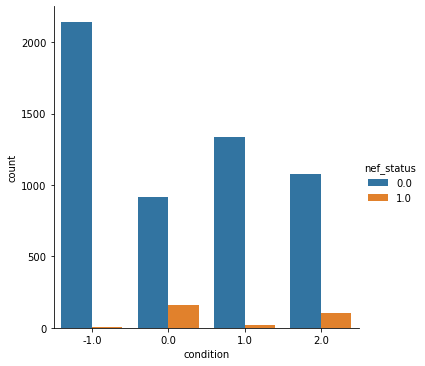

In [126]:
plt.figure(dpi=300)
sns.catplot(data = df_features_master, x='condition', hue='nef_status', kind="count")

In [127]:
df_features_master_nef_count = df_features_master.groupby(['condition','nef_status']).agg(['count'])

In [128]:
df_features_master_nef_count

lifetime max_ap2 max_dnm2 max_int_nef dnm2_lifetime  \
                        count   count    count       count         count   
condition nef_status                                                       
-1.0      0.0            2144    2144     2144        2144          2144   
          1.0               3       3        3           3             3   
 0.0      0.0             913     913      913         913           913   
          1.0             161     161      161         161           161   
 1.0      0.0            1334    1334     1334        1334          1334   
          1.0              22      22       22          22            22   
 2.0      0.0            1078    1078     1078        1078          1078   
          1.0             103     103      103         103           103   

                     nef_lifetime exp_date dnm2_lifetime_gap nef_lifetime_gap  \
                            count    count             count            count   
condition nef_status                                                            
-1.0      0.0                2144     2144              2144             2144   
          1.0                   3        3                 3                3   
 0.0      0.0                 913      913               913              913   
          1.0                 161      161               161              161   
 1.0      0.0                1334     1334              1334             1334   
          1.0                  22       22                22               22   
 2.0      0.0                1078     1078              1078             1078   
          1.0                 103      103               103              103   

                     cell_id  
                       count  
condition nef_status          
-1.0      0.0           2144  
          1.0              3  
 0.0      0.0            913  
          1.0            161  
 1.0      0.0           1334  
          1.0             22  
 2.0      0.0           1078  
          1.0            103

In [129]:
nef_pos_percent = []
nef_neg_percent = []
condition = []


for row in range(df_features_master_nef_count.shape[0]):
    if row % 2 == 0:
        condition.append(df_features_master_nef_count.index.values[row][0])
        
for row in range(df_features_master_nef_count.shape[0]):
    if row % 2 == 0:
        nef_pos_percent.append((df_features_master_nef_count.iloc[row + 1][2])/(df_features_master_nef_count.iloc[row][2]+df_features_master_nef_count.iloc[row + 1][2]))
        
for row in range(df_features_master_nef_count.shape[0]):
    if row % 2 == 0:
        nef_neg_percent.append((df_features_master_nef_count.iloc[row][2])/(df_features_master_nef_count.iloc[row][2]+df_features_master_nef_count.iloc[row + 1][2]))
        
    

In [130]:
array_features = np.array([condition, nef_pos_percent, nef_neg_percent]).T
df_master_nef_percentage = pd.DataFrame(data=array_features, columns=['condition', 'nef_pos_fraction', 'nef_neg_fraction'])

In [131]:
df_master_nef_percentage

,condition,nef_pos_fraction,nef_neg_fraction
0,-1.0,0.001397,0.998603
1,0.0,0.149907,0.850093
2,1.0,0.016224,0.983776
3,2.0,0.087214,0.912786


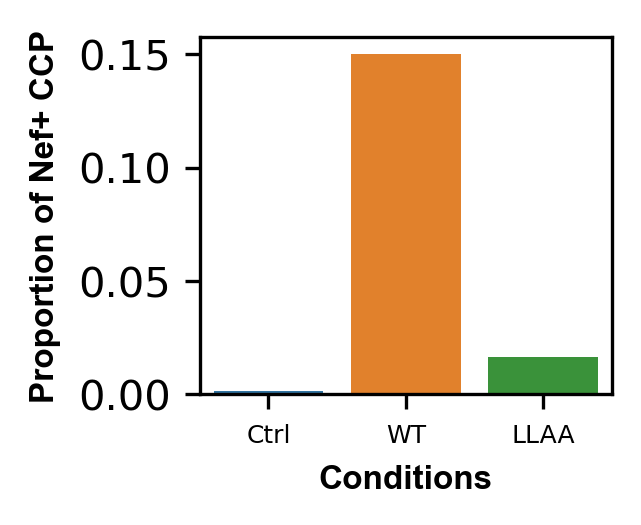

In [132]:
bx = plt.figure(figsize = (4.5/2.54,4/2.54), dpi=300)
bx = sns.barplot(data = df_master_nef_percentage[(df_master_nef_percentage['condition'] != 2)], x = 'condition', y = 'nef_pos_fraction')

bx = plt.xlabel('Conditions', fontname = "Arial", fontsize = 8, fontweight = "bold")
bx = plt.ylabel('Proportion of Nef+ CCP', fontname = "Arial", fontsize = 8, fontweight = "bold")
position = [0, 1, 2]
catlabel = ['Ctrl', 'WT', 'LLAA']
bx = plt.xticks(position, catlabel)
bx = plt.xticks(fontsize = 6)

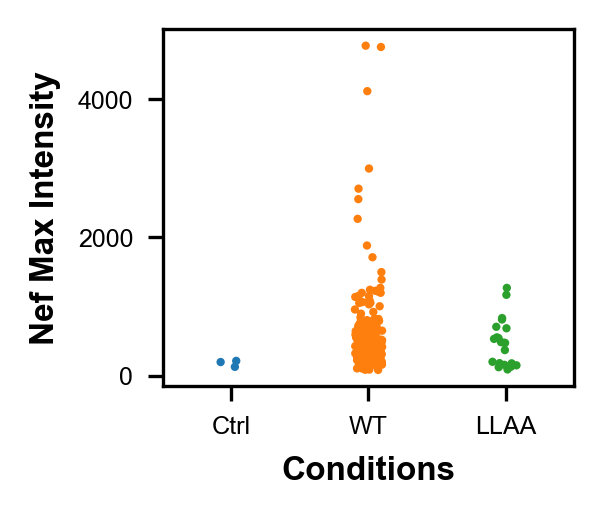

In [96]:
ax = plt.figure(figsize = (4.5/2.54 , 4/2.54), dpi=300)
ax = sns.stripplot(data = df_features_master[(df_features_master['nef_status'] == 1) & (df_features_master['condition'] != 2)], x = 'condition', y = 'max_int_nef', size = 2)
#ax = plt.ylim(bottom= 0, top=5000)
ax = plt.xlabel('Conditions', fontname = "Arial", fontsize = 8, fontweight = "bold")
ax = plt.ylabel('Nef Max Intensity', fontname = "Arial", fontsize = 8, fontweight = "bold")
position = [0, 1, 2]
catlabel = ['Ctrl', 'WT', 'LLAA']
ax = plt.xticks(position, catlabel)
ax = plt.xticks(fontname = "Arial", fontsize = 6)
ax = plt.yticks(fontname = "Arial", fontsize = 6)

  

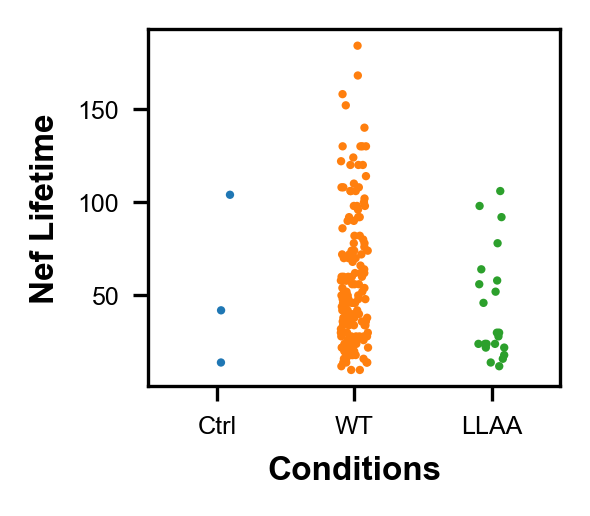

In [98]:
ax = plt.figure(figsize = (4.5/2.54 , 4/2.54), dpi=300)
ax = sns.stripplot(data = df_features_master[(df_features_master['nef_status'] == 1) & (df_features_master['condition'] != 2)], x = 'condition', y = 'nef_lifetime_gap', size = 2)
#ax = plt.ylim(bottom= 0, top=5000)
ax = plt.xlabel('Conditions', fontname = "Arial", fontsize = 8, fontweight = "bold")
ax = plt.ylabel('Nef Lifetime', fontname = "Arial", fontsize = 8, fontweight = "bold")
position = [0, 1, 2]
catlabel = ['Ctrl', 'WT', 'LLAA']
ax = plt.xticks(position, catlabel)
ax = plt.xticks(fontname = "Arial", fontsize = 6)
ax = plt.yticks(fontname = "Arial", fontsize = 6)

  

In [69]:
df_coloc_dynamic_master_count = df_features_master.groupby(['cell_id', 'condition', 'nef_status']).agg(['count'])

In [70]:
df_coloc_dynamic_master_count

,,,lifetime,max_ap2,max_dnm2,max_int_nef,dnm2_lifetime,nef_lifetime,exp_date,dnm2_lifetime_gap,nef_lifetime_gap
,,,count,count,count,count,count,count,count,count,count
cell_id,condition,nef_status,,,,,,,,,
20211111-1-1,-1.0,0.0,73,73,73,73,73,73,73,73,73
20211111-1-10,-1.0,0.0,53,53,53,53,53,53,53,53,53
20211111-1-11,-1.0,0.0,57,57,57,57,57,57,57,57,57
20211111-1-2,-1.0,0.0,31,31,31,31,31,31,31,31,31
20211111-1-3,-1.0,0.0,35,35,35,35,35,35,35,35,35
...,...,...,...,...,...,...,...,...,...,...,...
20220602-8-2,2.0,1.0,1,1,1,1,1,1,1,1,1
20220602-9-1,2.0,0.0,18,18,18,18,18,18,18,18,18


In [71]:
cell_id = df_coloc_dynamic_master_count.index.levels[0].tolist()

In [73]:
untrans_percent_nef_positive_dynamic = []
WT_percent_nef_positive_dynamic = []
LLAA_percent_nef_positive_dynamic = []

cell_id = df_coloc_dynamic_master_count.index.levels[0].tolist()
for row in range(len(cell_id)):
    
    condition = df_coloc_dynamic_master_count.loc[(cell_id[row])].index.get_level_values(0)[0]
    
    if len(df_coloc_dynamic_master_count.loc[(cell_id[row], slice(None))].iloc[:,0]) == 2:
        temp_nef_percentage = df_coloc_dynamic_master_count.loc[(cell_id[row], slice(None))].iloc[:,0].tolist()
        temp_nef_percentage = (temp_nef_percentage[1]/(temp_nef_percentage[0] + temp_nef_percentage[1]))*100
        
    elif (df_coloc_dynamic_master_count.loc[(cell_id[row])].index.get_level_values(1) == 0):
        temp_nef_percentage = 0
        
    else:
        temp_nef_percentage = 100
        
    if condition == -1:
        untrans_percent_nef_positive_dynamic.append(temp_nef_percentage)
        
    elif condition == 0:
        WT_percent_nef_positive_dynamic.append(temp_nef_percentage)
        
    elif condition == 1:
        LLAA_percent_nef_positive_dynamic.append(temp_nef_percentage)

In [74]:
df_untrans_dynamic_coloc = pd.DataFrame({'untrans' : untrans_percent_nef_positive_dynamic})
df_WT_dynamic_coloc = pd.DataFrame({'WT' : WT_percent_nef_positive_dynamic})
df_LLAA_dynamic_coloc = pd.DataFrame({'LLAA' : LLAA_percent_nef_positive_dynamic})

df_dynamic_coloc = pd.concat([df_untrans_dynamic_coloc, df_WT_dynamic_coloc, df_LLAA_dynamic_coloc], axis=1)

In [75]:
df_dynamic_coloc

,untrans,WT,LLAA
0,0.0,14.583333,0.0
1,0.0,18.181818,0.0
2,0.0,0.000000,4.0
3,0.0,0.000000,0.0
4,0.0,0.000000,0.0
...,...,...,...
70,0.0,NaN,NaN
71,0.0,NaN,NaN
72,0.0,NaN,NaN
73,0.0,NaN,NaN


In [76]:
df_dynamic_coloc.to_excel("output.xlsx") 

# Nef dynamics

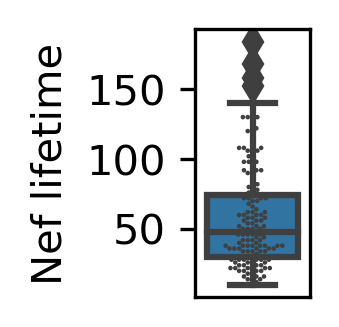

In [69]:
sub_df = df_features_master[(df_features_master['condition'] == 0) & (df_features_master['nef_status']==1)].sample(n=150, random_state=1)
df = df_features_master[(df_features_master['condition'] == 0) & (df_features_master['nef_status']==1)]

ax = plt.figure(figsize = (1.25/2.54 , 3/2.54), dpi=300)
ax = sns.swarmplot(data=sub_df, y = 'nef_lifetime_gap', size = 0.5, color = '0.8', edgecolor = '0.25', linewidth = 0.6)
ax = sns.boxplot(data=df, y = 'nef_lifetime_gap')

ax.set(xlabel=None, ylabel='Nef lifetime') 
ax.tick_params(bottom=False)

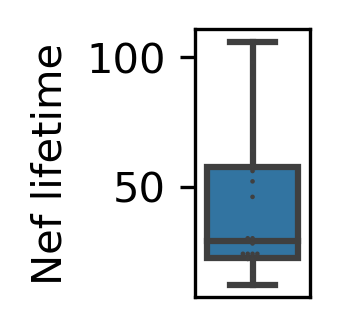

In [71]:
sub_df = df_features_master[(df_features_master['condition'] == 1) & (df_features_master['nef_status']==1)]
df = df_features_master[(df_features_master['condition'] == 1) & (df_features_master['nef_status']==1)]

ax = plt.figure(figsize = (1.25/2.54 , 3/2.54), dpi=300)
ax = sns.swarmplot(data=sub_df, y = 'nef_lifetime_gap', size = 0.5, color = '0.8', edgecolor = '0.25', linewidth = 0.6)
ax = sns.boxplot(data=df, y = 'nef_lifetime_gap')

ax.set(xlabel=None, ylabel='Nef lifetime') 
ax.tick_params(bottom=False)

[(0.0, 3000.0)]

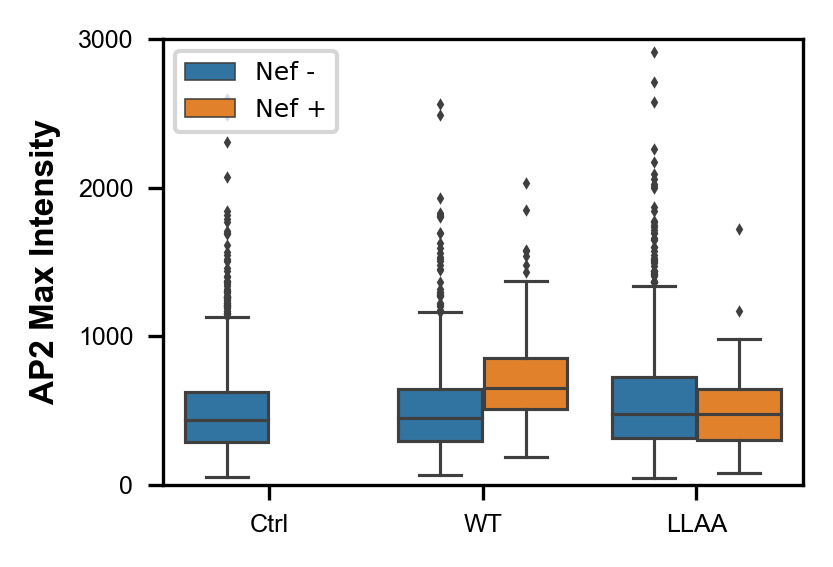

In [133]:
plt.figure(figsize = (7/2.54,5/2.54), dpi=300)
ax = sns.boxplot(data=df_features_master[~((df_features_master['nef_status'] == 1) & (df_features_master['condition'] == -1)) & (df_features_master['condition'] != 2)], x='condition', y='max_ap2', dodge=True, hue = 'nef_status', linewidth = 0.75, fliersize = 0.75)
#ax = sns.swarmplot(data=df_sample, x='condition', y = 'lifetime', dodge = True, hue = 'nef_status', size = 2, color = '0.8', edgecolor = '0.25', linewidth = 0.6)

plt.xlabel('', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('AP2 Max Intensity', fontname = "Arial", fontsize = 8, fontweight = "bold")
position = [0, 1, 2]
catlabel = ['Ctrl', 'WT', 'LLAA']
plt.xticks(position, catlabel)
plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)

ax.legend(handles=ax.legend_.legendHandles, labels=['Nef -', 'Nef +'], loc = 'upper left', fontsize = 6)

ax.set(ylim = [0,3000])

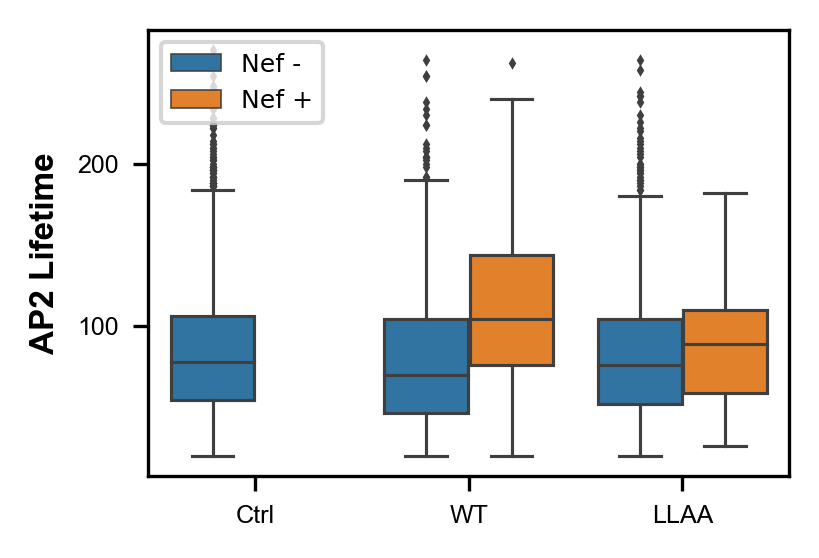

In [134]:
plt.figure(figsize = (7/2.54,5/2.54), dpi=300)
ax = sns.boxplot(data=df_features_master[~((df_features_master['nef_status'] == 1) & (df_features_master['condition'] == -1)) & (df_features_master['condition'] != 2)], x='condition', y='lifetime', dodge=True, hue = 'nef_status', linewidth = 0.75, fliersize = 0.75)
#ax = sns.swarmplot(data=df_sample, x='condition', y = 'lifetime', dodge = True, hue = 'nef_status', size = 2, color = '0.8', edgecolor = '0.25', linewidth = 0.6)

plt.xlabel('', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('AP2 Lifetime', fontname = "Arial", fontsize = 8, fontweight = "bold")
position = [0, 1, 2]
catlabel = ['Ctrl', 'WT', 'LLAA']
plt.xticks(position, catlabel)
plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)

ax.legend(handles=ax.legend_.legendHandles, labels=['Nef -', 'Nef +'], loc = 'upper left', fontsize = 6)


[(0.0, 3000.0)]

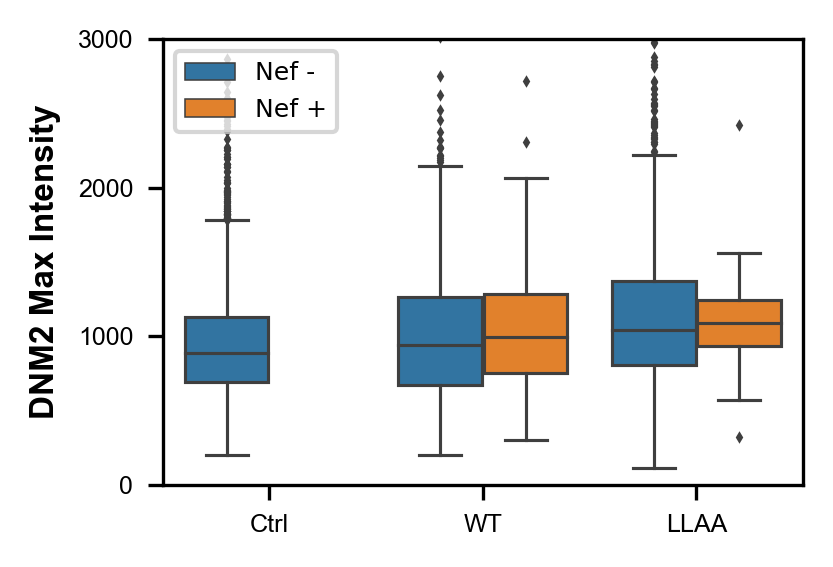

In [135]:
plt.figure(figsize = (7/2.54,5/2.54), dpi=300)
ax = sns.boxplot(data=df_features_master[~((df_features_master['nef_status'] == 1) & (df_features_master['condition'] == -1)) & (df_features_master['condition'] != 2)], x='condition', y='max_dnm2', dodge=True, hue = 'nef_status', linewidth = 0.75, fliersize = 0.75)
#ax = sns.swarmplot(data=df_sample, x='condition', y = 'lifetime', dodge = True, hue = 'nef_status', size = 2, color = '0.8', edgecolor = '0.25', linewidth = 0.6)

plt.xlabel('', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('DNM2 Max Intensity', fontname = "Arial", fontsize = 8, fontweight = "bold")
position = [0, 1, 2]
catlabel = ['Ctrl', 'WT', 'LLAA']
plt.xticks(position, catlabel)
plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)

ax.legend(handles=ax.legend_.legendHandles, labels=['Nef -', 'Nef +'], loc = 'upper left', fontsize = 6)

ax.set(ylim = [0,3000])

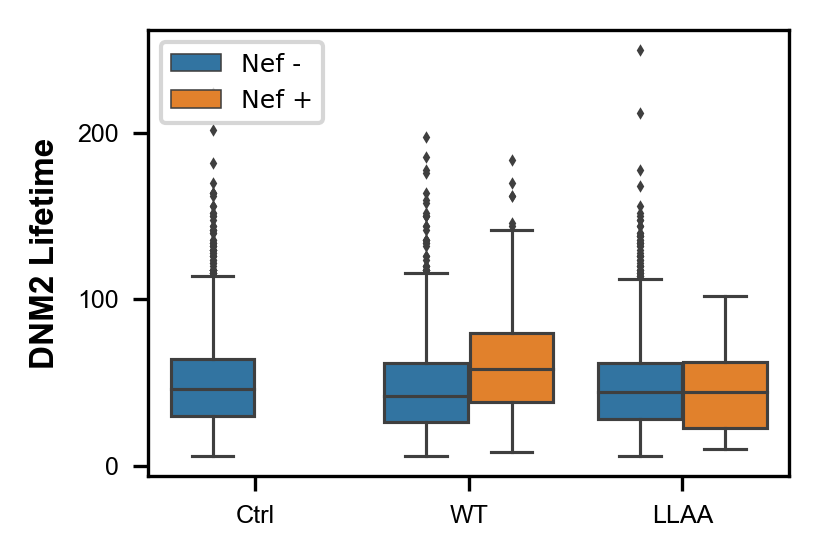

In [136]:
plt.figure(figsize = (7/2.54,5/2.54), dpi=300)
ax = sns.boxplot(data=df_features_master[~((df_features_master['nef_status'] == 1) & (df_features_master['condition'] == -1)) & (df_features_master['condition'] != 2)], x='condition', y='dnm2_lifetime_gap', dodge=True, hue = 'nef_status', linewidth = 0.75, fliersize = 0.75)
#ax = sns.swarmplot(data=df_sample, x='condition', y = 'lifetime', dodge = True, hue = 'nef_status', size = 2, color = '0.8', edgecolor = '0.25', linewidth = 0.6)

plt.xlabel('', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('DNM2 Lifetime', fontname = "Arial", fontsize = 8, fontweight = "bold")
position = [0, 1, 2]
catlabel = ['Ctrl', 'WT', 'LLAA']
plt.xticks(position, catlabel)
plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)

ax.legend(handles=ax.legend_.legendHandles, labels=['Nef -', 'Nef +'], loc = 'upper left', fontsize = 6)

#ax.set(ylim = [0,3000])

# Analyzing AP2, DNM2, and Nef dynamics in Jurkat cells

Text(0, 0.5, 'Probability')

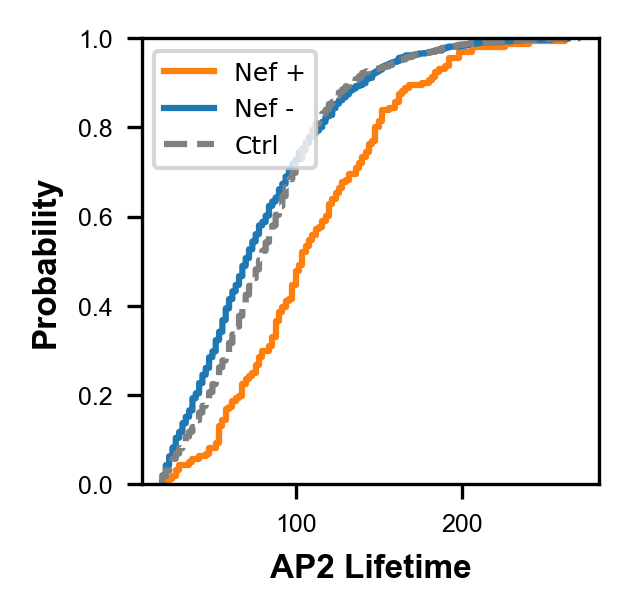

In [77]:
#Base code for CDF. WT Nef condition Specifically for AP2 lifetime
sub_df = df_features_master[df_features_master['condition'] == 0]
ref_df = df_features_master[df_features_master['condition'] == -1]

ax = plt.figure(figsize = (5/2.54,5/2.54), dpi=300)
ax = sns.ecdfplot(data=sub_df, x = 'lifetime', hue = 'nef_status')
ax = sns.ecdfplot(data=ref_df, x = 'lifetime', color = '0.5', linestyle="dashed")

#ax.set(xlabel='AP2 Lifetime', ylabel='Probability') 
ax = plt.legend(title=None, loc='upper left', labels=['Nef +', 'Nef -', 'Ctrl'], fontsize = 6)

plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)

plt.xlabel('AP2 Lifetime', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('Probability', fontname = "Arial", fontsize = 8, fontweight = "bold")

Text(0, 0.5, 'Probability')

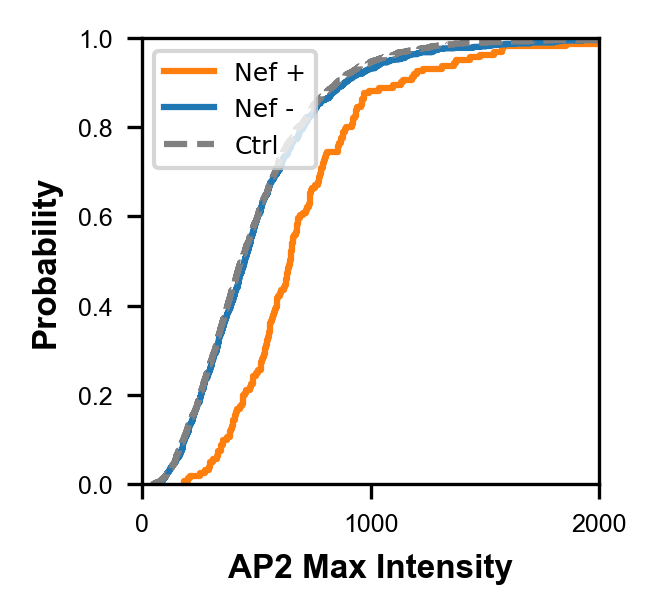

In [79]:
#Base code for CDF. WT Nef condition Specifically for AP2 lifetime
sub_df = df_features_master[df_features_master['condition'] == 0]
ref_df = df_features_master[df_features_master['condition'] == -1]

ax = plt.figure(figsize = (5/2.54,5/2.54), dpi=300)
ax = sns.ecdfplot(data=sub_df, x = 'max_ap2', hue = 'nef_status')
ax = sns.ecdfplot(data=ref_df, x = 'max_ap2', color = '0.5', linestyle="dashed")
ax.set(xlim = [0,2000])

#ax.set(xlabel='AP2 Lifetime', ylabel='Probability') 
ax = plt.legend(title=None, loc='upper left', labels=['Nef +', 'Nef -', 'Ctrl'], fontsize = 6)


plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)


plt.xlabel('AP2 Max Intensity', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('Probability', fontname = "Arial", fontsize = 8, fontweight = "bold")

Text(0, 0.5, 'Probability')

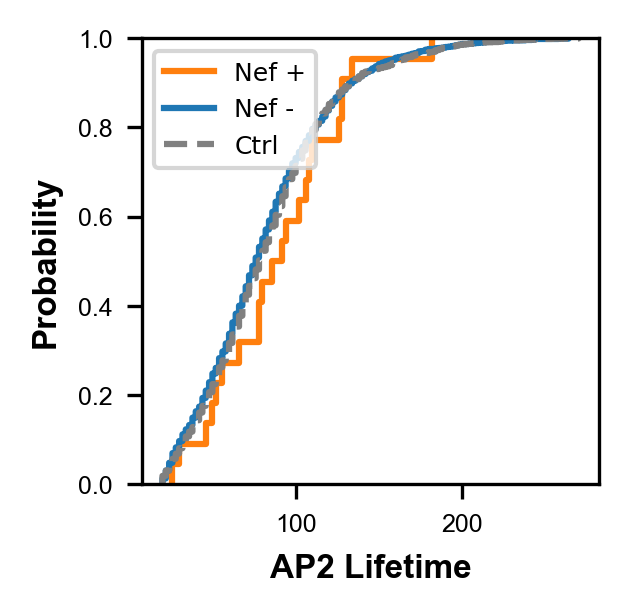

In [81]:
#Base code for CDF. LLAA Nef condition Specifically for AP2 Lifetime
sub_df = df_features_master[df_features_master['condition'] == 1]
ref_df = df_features_master[df_features_master['condition'] == -1]

ax = plt.figure(figsize = (5/2.54,5/2.54), dpi=300)
ax = sns.ecdfplot(data=sub_df, x = 'lifetime', hue = 'nef_status')
ax = sns.ecdfplot(data=ref_df, x = 'lifetime', color = '0.5', linestyle="dashed")
#ax.set(xlim = [0,2000])

#ax.set(xlabel='AP2 Lifetime', ylabel='Probability') 
ax = plt.legend(title=None, loc='upper left', labels=['Nef +', 'Nef -', 'Ctrl'], fontsize = 6)

plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)

plt.xlabel('AP2 Lifetime', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('Probability', fontname = "Arial", fontsize = 8, fontweight = "bold")

Text(0, 0.5, 'Probability')

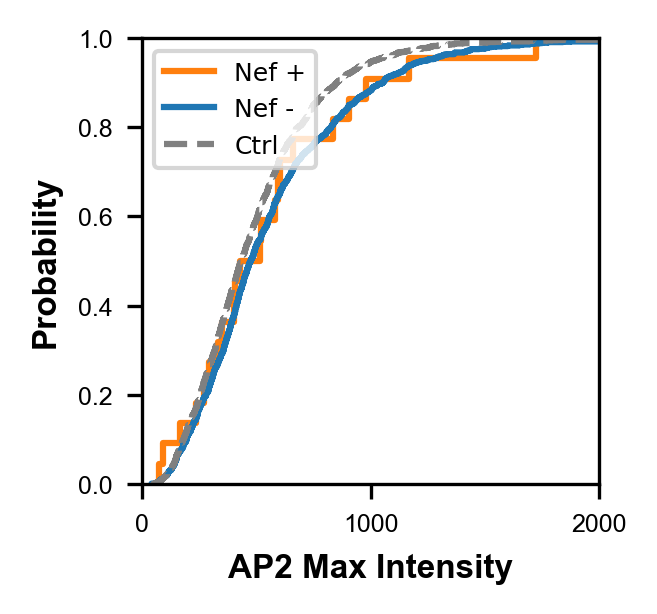

In [80]:
#Base code for CDF. LLAA Nef condition Specifically for AP2 Max Int
sub_df = df_features_master[df_features_master['condition'] == 1]
ref_df = df_features_master[df_features_master['condition'] == -1]

ax = plt.figure(figsize = (5/2.54,5/2.54), dpi=300)
ax = sns.ecdfplot(data=sub_df, x = 'max_ap2', hue = 'nef_status')
ax = sns.ecdfplot(data=ref_df, x = 'max_ap2', color = '0.5', linestyle="dashed")
ax.set(xlim = [0,2000])

#ax.set(xlabel='AP2 Lifetime', ylabel='Probability') 
ax = plt.legend(title=None, loc='upper left', labels=['Nef +', 'Nef -', 'Ctrl'], fontsize = 6)

plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)

plt.xlabel('AP2 Max Intensity', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('Probability', fontname = "Arial", fontsize = 8, fontweight = "bold")

Text(0, 0.5, 'Probability')

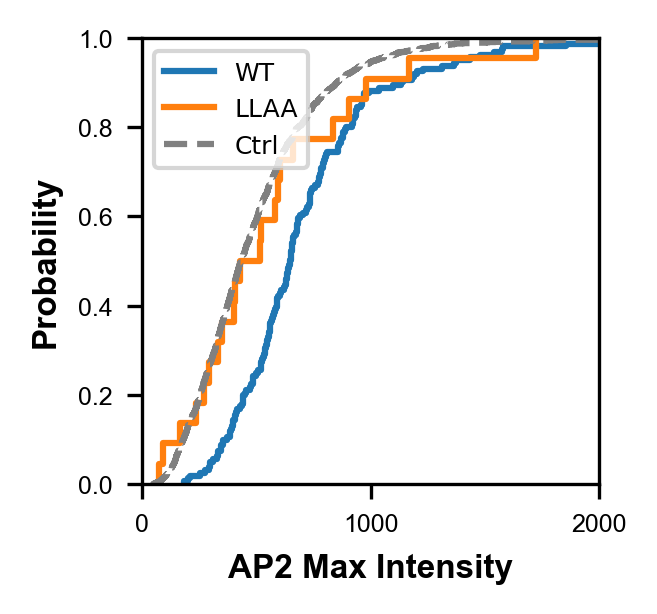

In [87]:
#Base code for CDF. Comparing Nef conditions. AP2 max intensity
WT_df = df_features_master[(df_features_master['condition'] == 0) & (df_features_master['nef_status'] == 1)]
LLAA_df = df_features_master[(df_features_master['condition'] == 1) & (df_features_master['nef_status'] == 1)]
ref_df = df_features_master[df_features_master['condition'] == -1]

ax = plt.figure(figsize = (5/2.54,5/2.54), dpi=300)
ax = sns.ecdfplot(data=WT_df, x = 'max_ap2')
ax = sns.ecdfplot(data=LLAA_df, x = 'max_ap2')
ax = sns.ecdfplot(data=ref_df, x = 'max_ap2', color = '0.5', linestyle="dashed")
ax.set(xlim = [0,2000])

#ax.set(xlabel='AP2 Lifetime', ylabel='Probability') 
ax = plt.legend(title=None, loc='upper left', labels=['WT', 'LLAA', 'Ctrl'], fontsize = 6)

plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)

plt.xlabel('AP2 Max Intensity', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('Probability', fontname = "Arial", fontsize = 8, fontweight = "bold")

Text(0, 0.5, 'Probability')

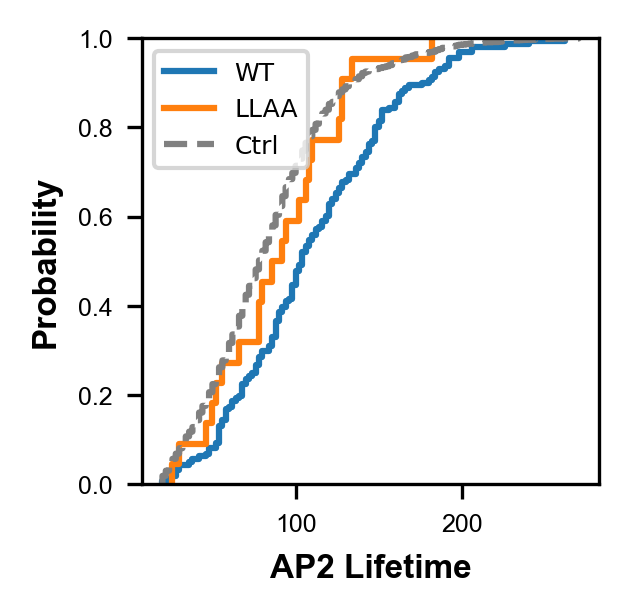

In [88]:
#Base code for CDF. Comparing Nef conditions. AP2 max intensity
WT_df = df_features_master[(df_features_master['condition'] == 0) & (df_features_master['nef_status'] == 1)]
LLAA_df = df_features_master[(df_features_master['condition'] == 1) & (df_features_master['nef_status'] == 1)]
ref_df = df_features_master[df_features_master['condition'] == -1]

ax = plt.figure(figsize = (5/2.54,5/2.54), dpi=300)
ax = sns.ecdfplot(data=WT_df, x = 'lifetime')
ax = sns.ecdfplot(data=LLAA_df, x = 'lifetime')
ax = sns.ecdfplot(data=ref_df, x = 'lifetime', color = '0.5', linestyle="dashed")
#ax.set(xlim = [0,2000])

#ax.set(xlabel='AP2 Lifetime', ylabel='Probability') 
ax = plt.legend(title=None, loc='upper left', labels=['WT', 'LLAA', 'Ctrl'], fontsize = 6)

plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)

plt.xlabel('AP2 Lifetime', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('Probability', fontname = "Arial", fontsize = 8, fontweight = "bold")

Text(0, 0.5, 'Probability')

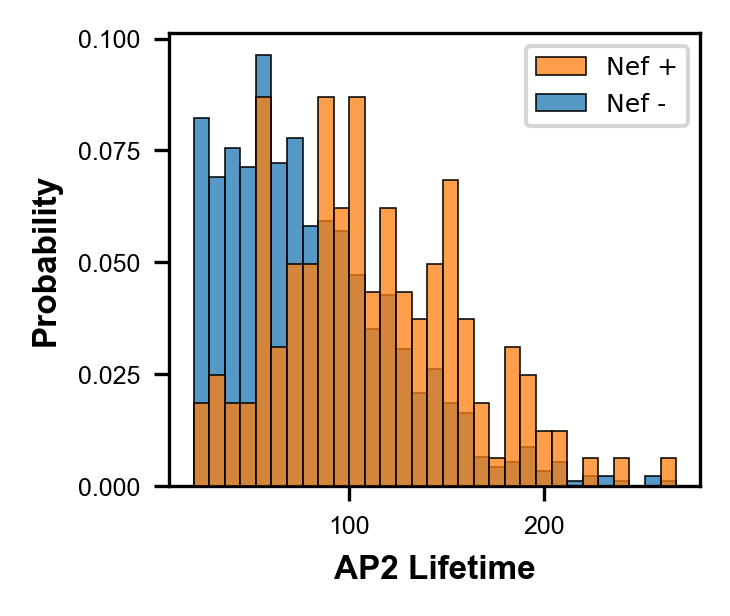

In [89]:
#Generating lifetime histogram for valid filtered set. WT Nef
ax = plt.figure(figsize = (5.8/2.54,5/2.5), dpi=300)
ax = sns.histplot(data=df_features_master[(df_features_master['nef_status'] == 1) & (df_features_master['condition'] == 0)], x = 'lifetime', stat = 'probability', color = 'C1', binwidth = 8, zorder = 10)
ax = sns.histplot(data=df_features_master[(df_features_master['nef_status'] == 0) & (df_features_master['condition'] == 0)], x = 'lifetime', stat = 'probability', binwidth = 8)


ax = plt.legend(title=None, loc='upper right', labels=['Nef +', 'Nef -'], fontsize = 6)
plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)

plt.xlabel('AP2 Lifetime', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('Probability', fontname = "Arial", fontsize = 8, fontweight = "bold")

Text(0, 0.5, 'Probability')

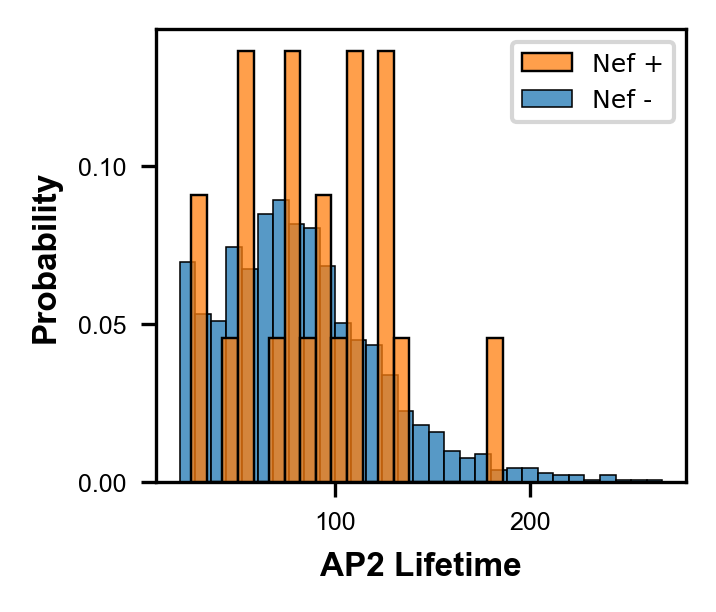

In [90]:
#Generating lifetime histogram for valid filtered set LLAA Nef
ax = plt.figure(figsize = (5.8/2.54,5/2.5), dpi=300)
ax = sns.histplot(data=df_features_master[(df_features_master['nef_status'] == 1) & (df_features_master['condition'] == 1)], x = 'lifetime', stat = 'probability', color = 'C1', binwidth = 8, zorder = 10)
ax = sns.histplot(data=df_features_master[(df_features_master['nef_status'] == 0) & (df_features_master['condition'] == 1)], x = 'lifetime', stat = 'probability', binwidth = 8)


ax = plt.legend(title=None, loc='upper right', labels=['Nef +', 'Nef -'], fontsize = 6)
plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)

plt.xlabel('AP2 Lifetime', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('Probability', fontname = "Arial", fontsize = 8, fontweight = "bold")

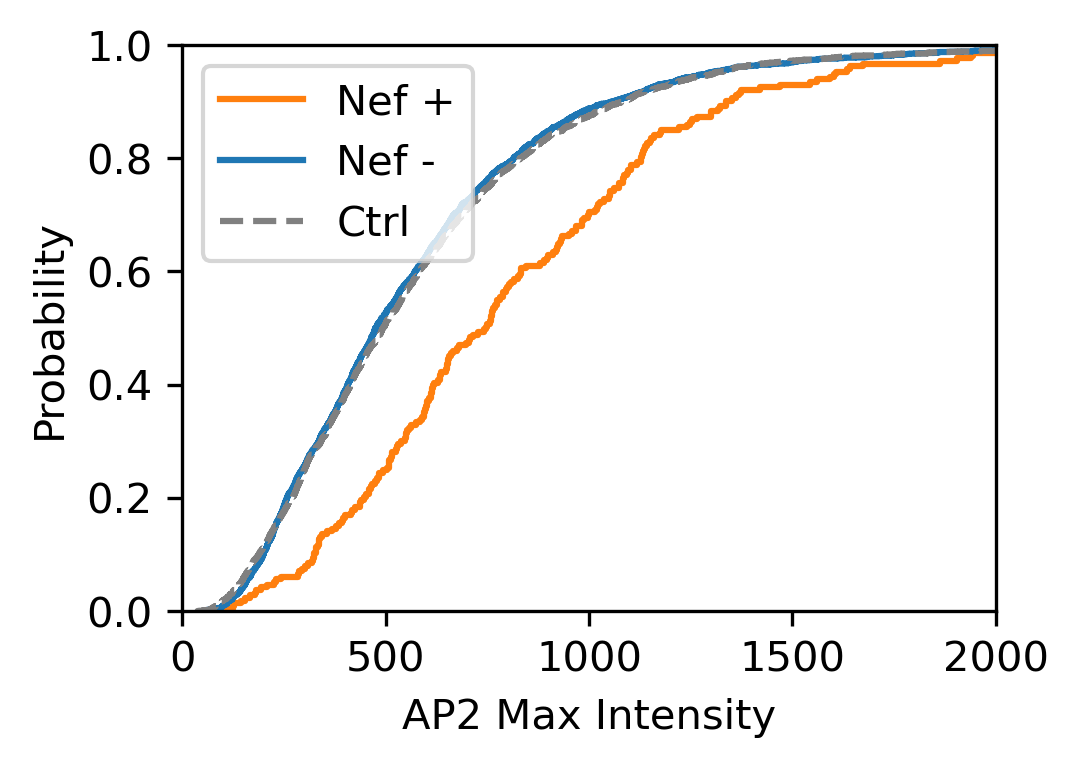

In [101]:
#Base code for CDF. 6 hour induction of Nef condition Specifically for AP2 max intensity
sub_df = df_features_master[df_features_master['condition'] == 6]
ref_df = df_features_master[df_features_master['condition'] == -1]

ax = plt.figure(figsize = (3.5,2.5), dpi=300)
ax = sns.ecdfplot(data=sub_df, x = 'max_ap2', hue = 'nef_status')
ax = sns.ecdfplot(data=ref_df, x = 'max_ap2', color = '0.5', linestyle="dashed")

ax.set(xlabel='AP2 Max Intensity', ylabel='Probability') 
ax.set(xlim = [0,2000])
ax = plt.legend(title=None, loc='upper left', labels=['Nef +', 'Nef -', 'Ctrl'])

Text(0, 0.5, 'Probability')

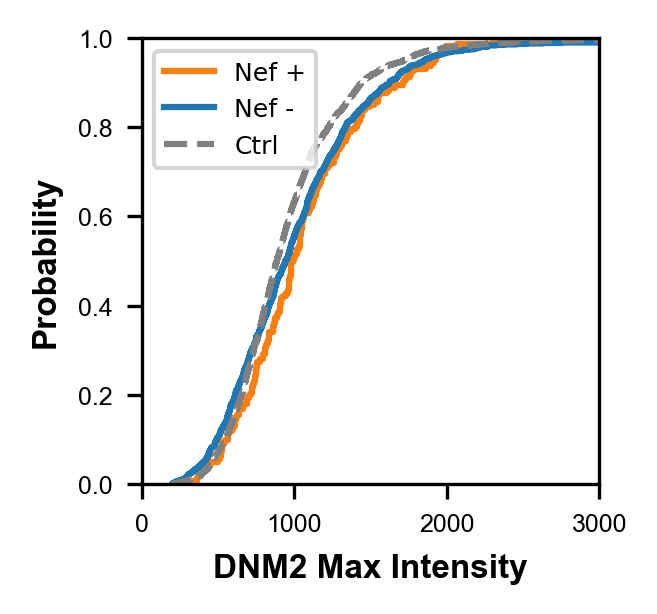

In [73]:
#Base code for CDF. WT Nef condition Specifically for DNM2 max intensity
sub_df = df_features_master[df_features_master['condition'] == 0]
ref_df = df_features_master[df_features_master['condition'] == -1]

ax = plt.figure(figsize = (5/2.54,5/2.54), dpi=300)
ax = sns.ecdfplot(data=sub_df, x = 'max_dnm2', hue = 'nef_status')
ax = sns.ecdfplot(data=ref_df, x = 'max_dnm2', color = '0.5', linestyle="dashed")
ax.set(xlim = [0,3000])

#ax.set(xlabel='AP2 Lifetime', ylabel='Probability') 
ax = plt.legend(title=None, loc='upper left', labels=['Nef +', 'Nef -', 'Ctrl'], fontsize = 6)

plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)

plt.xlabel('DNM2 Max Intensity', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('Probability', fontname = "Arial", fontsize = 8, fontweight = "bold")

Text(0, 0.5, 'Probability')

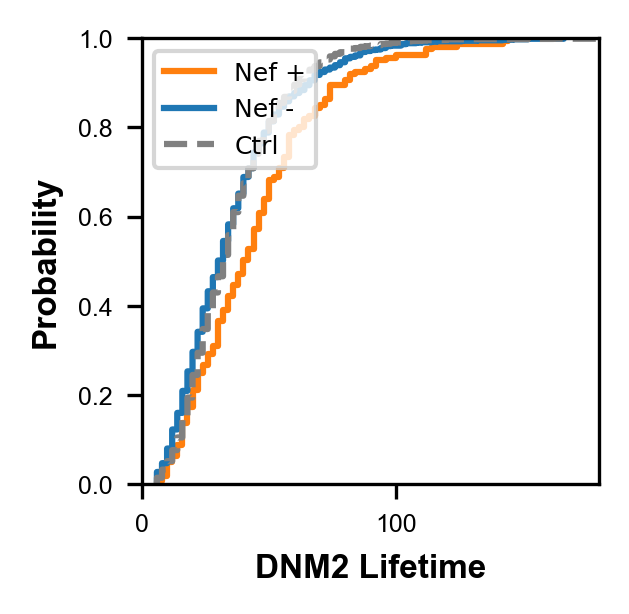

In [92]:
#Base code for CDF. WT Nef condition Specifically for DNM2 Lifetime
sub_df = df_features_master[df_features_master['condition'] == 0]
ref_df = df_features_master[df_features_master['condition'] == -1]

ax = plt.figure(figsize = (5/2.54,5/2.54), dpi=300)
ax = sns.ecdfplot(data=sub_df, x = 'dnm2_lifetime', hue = 'nef_status')
ax = sns.ecdfplot(data=ref_df, x = 'dnm2_lifetime', color = '0.5', linestyle="dashed")
ax.set(xlim = [0,180])

#ax.set(xlabel='AP2 Lifetime', ylabel='Probability') 
ax = plt.legend(title=None, loc='upper left', labels=['Nef +', 'Nef -', 'Ctrl'], fontsize = 6)

plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)

plt.xlabel('DNM2 Lifetime', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('Probability', fontname = "Arial", fontsize = 8, fontweight = "bold")

Text(0, 0.5, 'Probability')

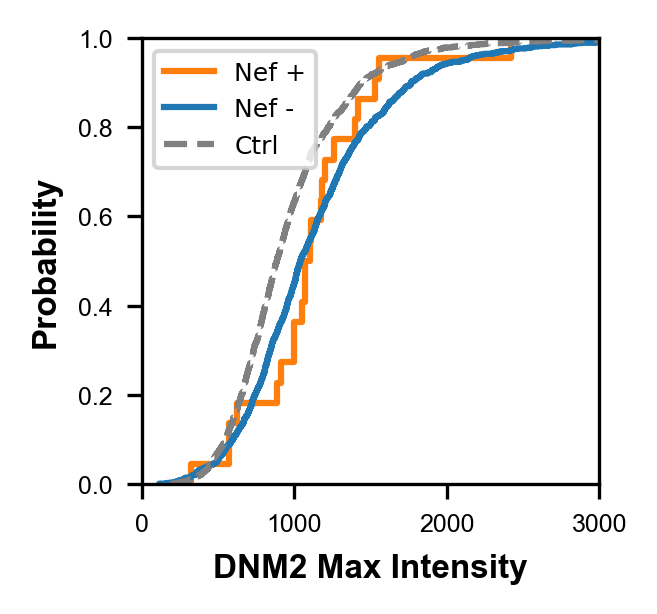

In [93]:
#Base code for CDF. LLAA Nef condition Specifically for DNM2 max intensity
sub_df = df_features_master[df_features_master['condition'] == 1]
ref_df = df_features_master[df_features_master['condition'] == -1]

ax = plt.figure(figsize = (5/2.54,5/2.54), dpi=300)
ax = sns.ecdfplot(data=sub_df, x = 'max_dnm2', hue = 'nef_status')
ax = sns.ecdfplot(data=ref_df, x = 'max_dnm2', color = '0.5', linestyle="dashed")
ax.set(xlim = [0,3000])

#ax.set(xlabel='AP2 Lifetime', ylabel='Probability') 
ax = plt.legend(title=None, loc='upper left', labels=['Nef +', 'Nef -', 'Ctrl'], fontsize = 6)

plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)

plt.xlabel('DNM2 Max Intensity', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('Probability', fontname = "Arial", fontsize = 8, fontweight = "bold")

Text(0, 0.5, 'Probability')

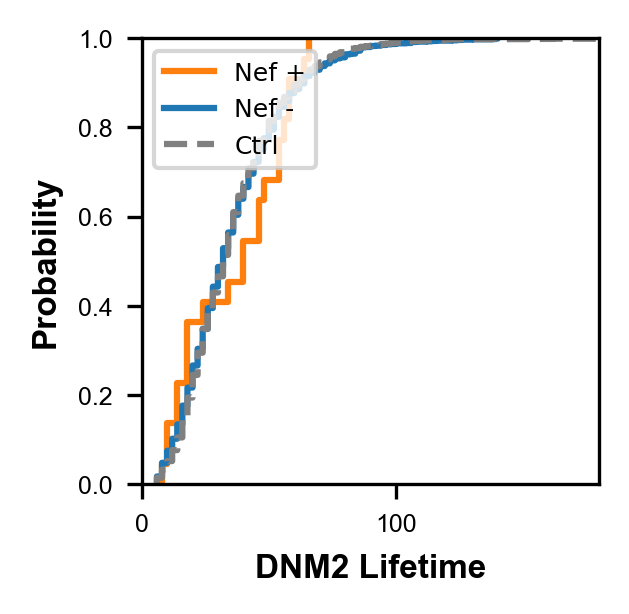

In [94]:
#Base code for CDF. LLAA Nef condition Specifically for DNM2 Lifetime
sub_df = df_features_master[df_features_master['condition'] == 1]
ref_df = df_features_master[df_features_master['condition'] == -1]

ax = plt.figure(figsize = (5/2.54,5/2.54), dpi=300)
ax = sns.ecdfplot(data=sub_df, x = 'dnm2_lifetime', hue = 'nef_status')
ax = sns.ecdfplot(data=ref_df, x = 'dnm2_lifetime', color = '0.5', linestyle="dashed")
ax.set(xlim = [0,180])

#ax.set(xlabel='AP2 Lifetime', ylabel='Probability') 
ax = plt.legend(title=None, loc='upper left', labels=['Nef +', 'Nef -', 'Ctrl'], fontsize = 6)

plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)

plt.xlabel('DNM2 Lifetime', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('Probability', fontname = "Arial", fontsize = 8, fontweight = "bold")

Text(0, 0.5, 'Probability')

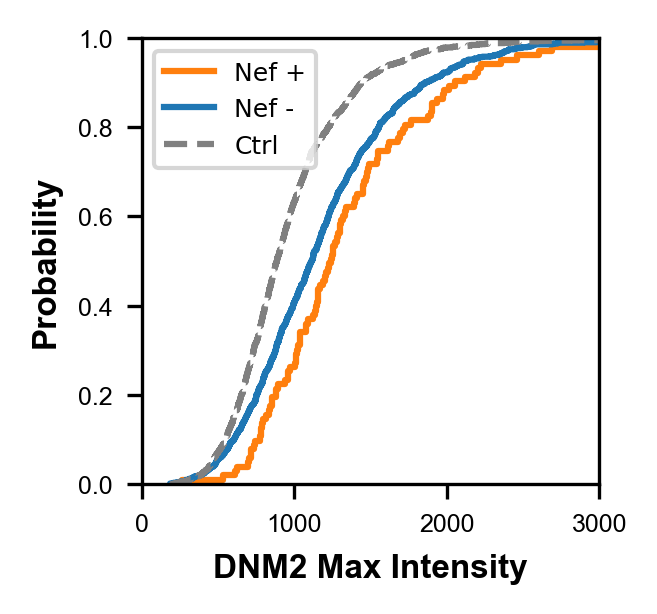

In [95]:
#Base code for CDF. D123A Nef condition Specifically for DNM2 max intensity
sub_df = df_features_master[df_features_master['condition'] == 2]
ref_df = df_features_master[df_features_master['condition'] == -1]

ax = plt.figure(figsize = (5/2.54,5/2.54), dpi=300)
ax = sns.ecdfplot(data=sub_df, x = 'max_dnm2', hue = 'nef_status')
ax = sns.ecdfplot(data=ref_df, x = 'max_dnm2', color = '0.5', linestyle="dashed")
ax.set(xlim = [0,3000])

#ax.set(xlabel='AP2 Lifetime', ylabel='Probability') 
ax = plt.legend(title=None, loc='upper left', labels=['Nef +', 'Nef -', 'Ctrl'], fontsize = 6)

plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)

plt.xlabel('DNM2 Max Intensity', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('Probability', fontname = "Arial", fontsize = 8, fontweight = "bold")

Text(0, 0.5, 'Probability')

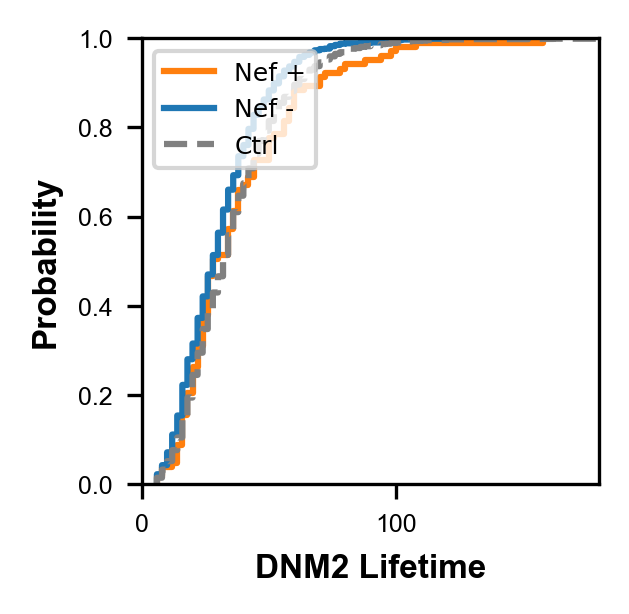

In [96]:
#Base code for CDF. D123A Nef condition Specifically for DNM2 Lifetime
sub_df = df_features_master[df_features_master['condition'] == 2]
ref_df = df_features_master[df_features_master['condition'] == -1]

ax = plt.figure(figsize = (5/2.54,5/2.54), dpi=300)
ax = sns.ecdfplot(data=sub_df, x = 'dnm2_lifetime', hue = 'nef_status')
ax = sns.ecdfplot(data=ref_df, x = 'dnm2_lifetime', color = '0.5', linestyle="dashed")
ax.set(xlim = [0,180])

#ax.set(xlabel='AP2 Lifetime', ylabel='Probability') 
ax = plt.legend(title=None, loc='upper left', labels=['Nef +', 'Nef -', 'Ctrl'], fontsize = 6)

plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)

plt.xlabel('DNM2 Lifetime', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('Probability', fontname = "Arial", fontsize = 8, fontweight = "bold")

In [69]:
#Base code for CDF. 6 hour induction of Nef condition Specifically for DNM2 lifetime
sub_df = df_features_master[df_features_master['condition'] == 4]
ref_df = df_features_master[df_features_master['condition'] == -1]

ax = plt.figure(figsize = (3.5,2.5), dpi=300)
ax = sns.ecdfplot(data=sub_df, x = 'max_consecutive_ch2', hue = 'nef_status')
ax = sns.ecdfplot(data=ref_df, x = 'max_consecutive_ch2', color = '0.5', linestyle="dashed")

ax.set(xlabel='DNM2 Lifetime', ylabel='Probability') 
ax = plt.legend(title=None, loc='upper left', labels=['Nef +', 'Nef -', 'Ctrl'])

ValueError: Could not interpret value `max_consecutive_ch2` for parameter `x`

<Figure size 1050x750 with 0 Axes>

Text(0, 0.5, 'AP2 Max Intensity')

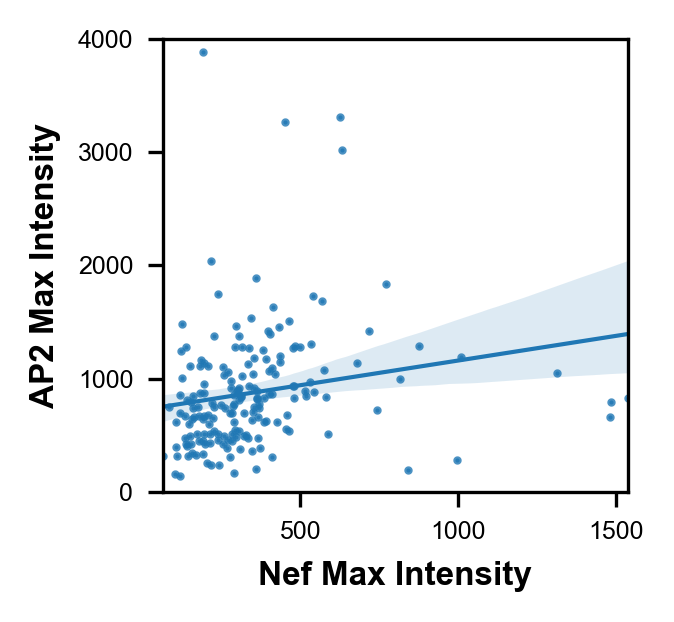

In [70]:
#Relating Nef amount to AP2 amount
ax = plt.figure(figsize = (5/2.5,5/2.5), dpi=300)
ax = sns.regplot(data=df_features_master[(df_features_master['condition'] == 4) & (df_features_master['nef_status'] == 1)], x = 'max_int_nef', y = 'max_ap2', color = 'C0', line_kws={'linewidth':1}, scatter_kws={'s':1})
plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)
ax.set(ylim = [0, 4000])

plt.xlabel('Nef Max Intensity', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('AP2 Max Intensity', fontname = "Arial", fontsize = 8, fontweight = "bold")

Text(0, 0.5, 'AP2 Lifetime')

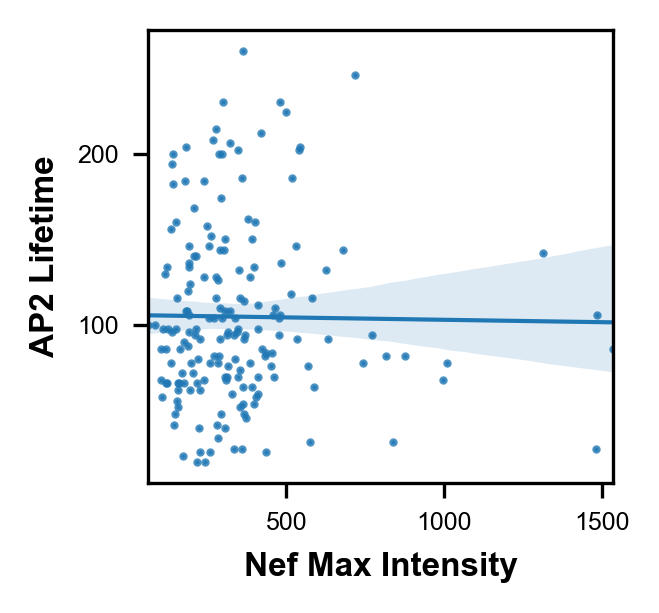

In [71]:
#Relating Nef amount to AP2 lifetime
ax = plt.figure(figsize = (5/2.5,5/2.5), dpi=300)
ax = sns.regplot(data=df_features_master[(df_features_master['condition'] == 4) & (df_features_master['nef_status'] == 1)], x = 'max_int_nef', y = 'lifetime', color = 'C0', line_kws={'linewidth':1}, scatter_kws={'s':1})
plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)
#ax.set(ylim = [0, 4000])

plt.xlabel('Nef Max Intensity', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('AP2 Lifetime', fontname = "Arial", fontsize = 8, fontweight = "bold")

Text(0, 0.5, 'AP2 Lifetime')

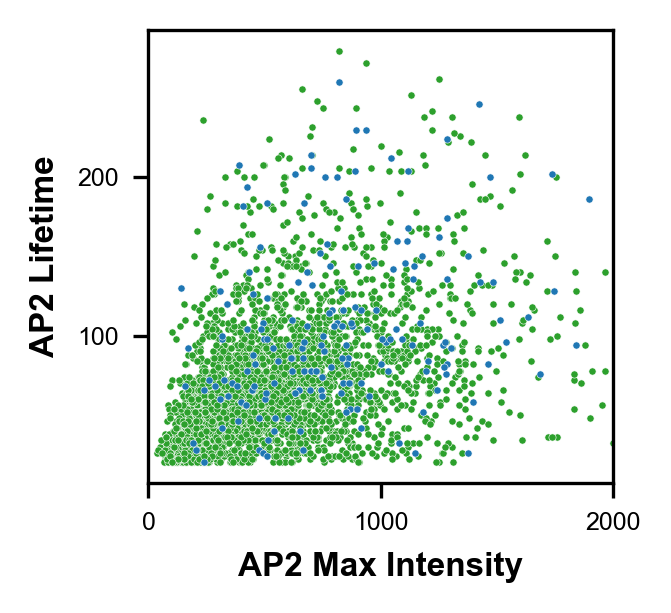

In [118]:
#Relating AP2 amount to AP2 lifetime
ax = plt.figure(figsize = (5/2.5,5/2.5), dpi=300)

ax = sns.scatterplot(data=df_features_master[(df_features_master['condition'] == -1)], x = 'max_ap2', y = 'lifetime', color = 'C2', s = 3, legend = False)
#ax = sns.scatterplot(data=df_features_master[(df_features_master['condition'] == 4) & (df_features_master['nef_status'] == 0)], x = 'max_ap2', y = 'lifetime', color = 'C1', s = 3, legend = False)
ax = sns.scatterplot(data=df_features_master[(df_features_master['condition'] == 4) & (df_features_master['nef_status'] == 1)], x = 'max_ap2', y = 'lifetime', color = 'C0', s = 3, legend = False)
ax.set(xlim = [0, 2000])
plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)
#ax.set(ylim = [0,2500])
plt.xlabel('AP2 Max Intensity', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('AP2 Lifetime', fontname = "Arial", fontsize = 8, fontweight = "bold")

#plt.xscale("log")
#plt.yscale("log")

Text(0, 0.5, 'AP2 Lifetime')

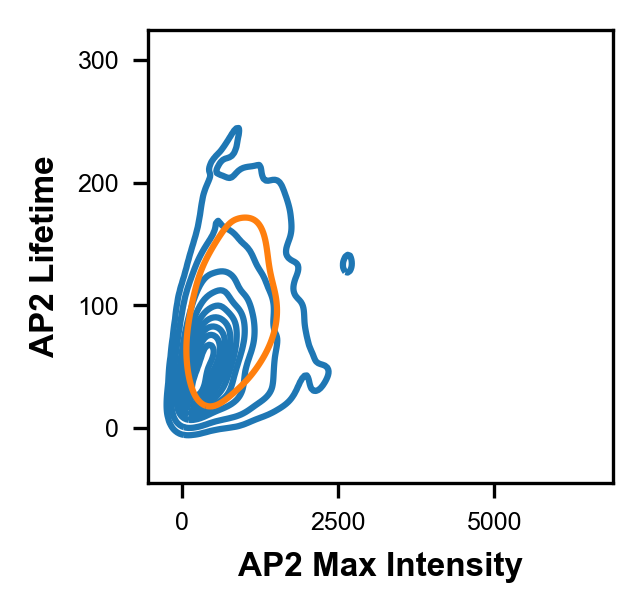

In [109]:
#Relating AP2 amount to AP2 lifetime
ax = plt.figure(figsize = (5/2.5,5/2.5), dpi=300)

ax = sns.kdeplot(data=df_features_master[(df_features_master['condition'] == 4)], x = 'max_ap2', y = 'lifetime', hue = 'nef_status', fill = False, legend = False)
#ax = sns.kdeplot(data=df_features_master[(df_features_master['condition'] == 4) & (df_features_master['nef_status'] == 1)], x = 'max_ap2', y = 'lifetime', color = 'C0', fill = True, legend = False)
#ax.set(xlim = [0, 2000])
plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)
#ax.set(ylim = [0,2500])
plt.xlabel('AP2 Max Intensity', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('AP2 Lifetime', fontname = "Arial", fontsize = 8, fontweight = "bold")

# Comparing dynamics across induction

In [85]:
#generating sampled dataframe for swarmplot use
df_sample = pd.DataFrame()
df_AP2_DNM2 = df_features_master[(df_features_master['nef_status'] == 0) & (df_features_master['condition'] == -1)].sample(n=50, random_state=1)
df_1h_neg = df_features_master[(df_features_master['nef_status'] == 0) & (df_features_master['condition'] == 0)].sample(n=50, random_state=1)
df_1h_pos = df_features_master[(df_features_master['nef_status'] == 1) & (df_features_master['condition'] == 0)].sample(n=50, random_state=1)
df_2h_neg = df_features_master[(df_features_master['nef_status'] == 0) & (df_features_master['condition'] == 2)].sample(n=50, random_state=1)
df_2h_pos = df_features_master[(df_features_master['nef_status'] == 1) & (df_features_master['condition'] == 2)].sample(n=50, random_state=1)
df_4h_neg = df_features_master[(df_features_master['nef_status'] == 0) & (df_features_master['condition'] == 4)].sample(n=50, random_state=1)
df_4h_pos = df_features_master[(df_features_master['nef_status'] == 1) & (df_features_master['condition'] == 4)].sample(n=50, random_state=1)
df_6h_neg = df_features_master[(df_features_master['nef_status'] == 0) & (df_features_master['condition'] == 6)].sample(n=50, random_state=1)
df_6h_pos = df_features_master[(df_features_master['nef_status'] == 1) & (df_features_master['condition'] == 6)].sample(n=50, random_state=1)
df_24h_neg = df_features_master[(df_features_master['nef_status'] == 0) & (df_features_master['condition'] == 24)].sample(n=50, random_state=1)
df_24h_pos = df_features_master[(df_features_master['nef_status'] == 1) & (df_features_master['condition'] == 24)].sample(n=50, random_state=1)

df_sample = df_sample.append([df_AP2_DNM2, df_1h_neg, df_1h_pos, df_2h_neg, df_2h_pos, df_4h_neg, df_4h_pos, df_6h_neg, df_6h_pos, df_24h_neg, df_24h_pos])

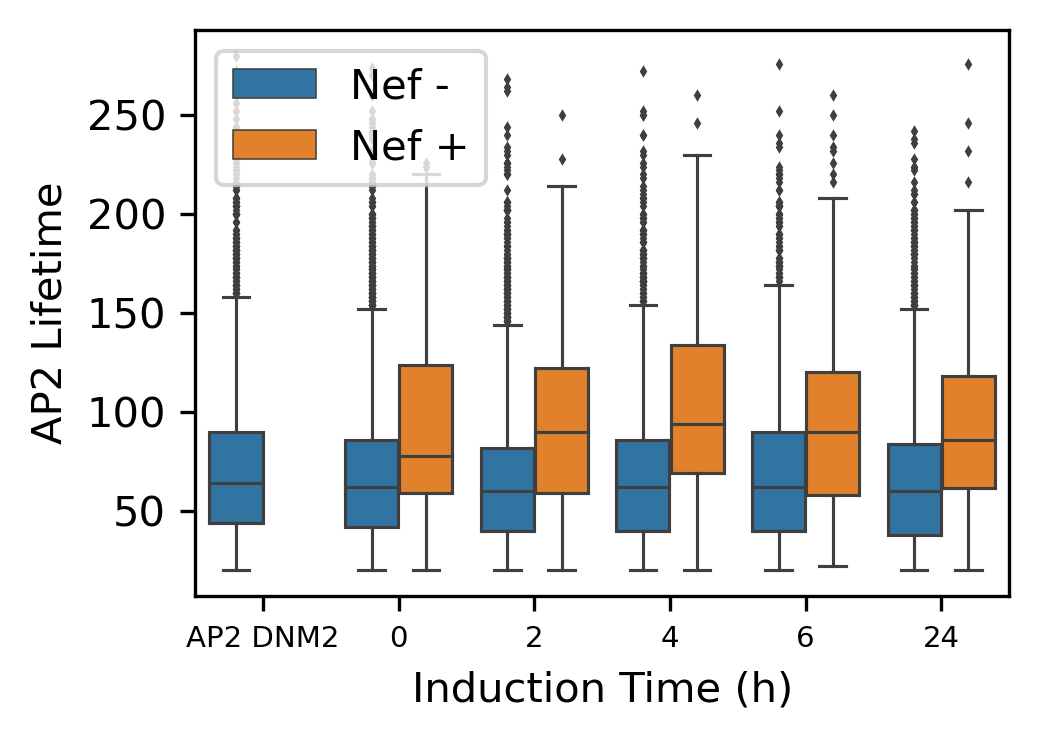

In [98]:
plt.figure(figsize = (3.5,2.5), dpi=300)
ax = sns.boxplot(data=df_features_master[~((df_features_master['nef_status'] == 1) & (df_features_master['condition'] == -1))], x='condition', y='lifetime', dodge=True, hue = 'nef_status', linewidth = 0.75, fliersize = 0.75)
#ax = sns.swarmplot(data=df_sample, x='condition', y = 'lifetime', dodge = True, hue = 'nef_status', size = 2, color = '0.8', edgecolor = '0.25', linewidth = 0.6)

plt.xlabel('Induction Time (h)')
plt.ylabel('AP2 Lifetime')
position = [0, 1, 2, 3, 4, 5]
catlabel = ['AP2 DNM2', '0', '2', '4', '6', '24']
plt.xticks(position, catlabel)
plt.xticks(fontsize = 7)

ax.legend(handles=ax.legend_.legendHandles, labels=['Nef -', 'Nef +'], loc = 'upper left')

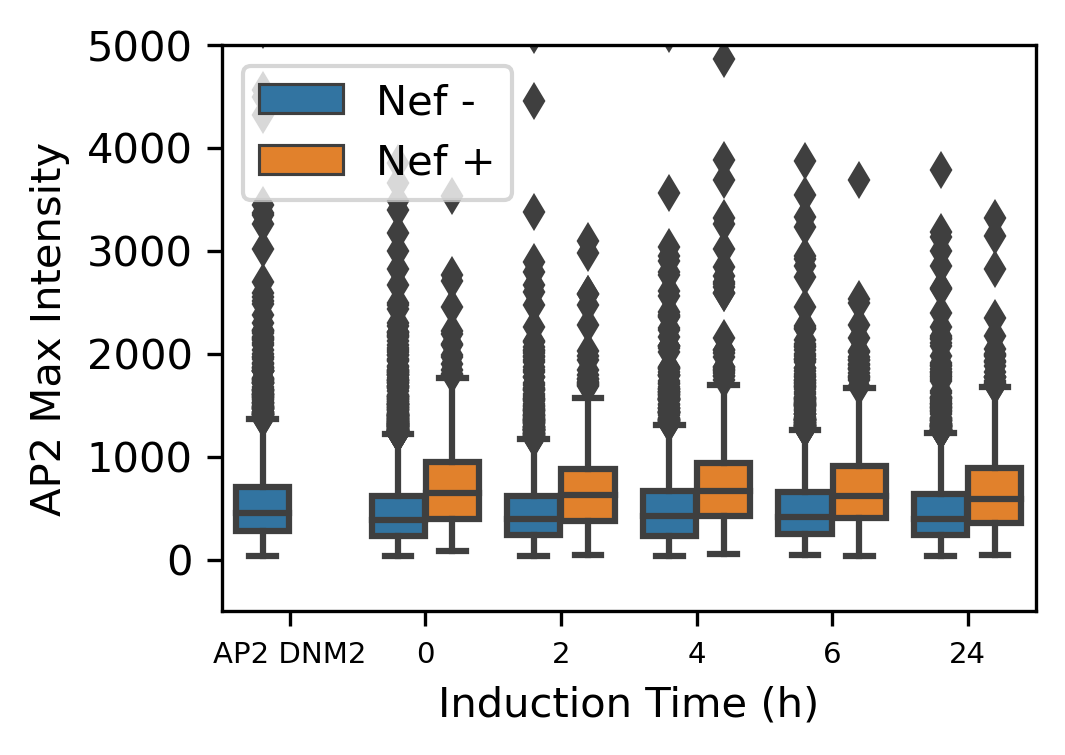

In [87]:
plt.figure(figsize = (3.5,2.5), dpi=300)
ax = sns.boxplot(data=df_features_master[~((df_features_master['nef_status'] == 1) & (df_features_master['condition'] == -1))], x='condition', y='max_ap2', dodge=True, hue = 'nef_status')
#ax = sns.swarmplot(data=df_sample, x='condition', y = 'lifetime', dodge = True, hue = 'nef_status', size = 2, color = '0.8', edgecolor = '0.25', linewidth = 0.6)

plt.xlabel('Induction Time (h)')
plt.ylabel('AP2 Max Intensity')
position = [0, 1, 2, 3, 4, 5]
catlabel = ['AP2 DNM2', '0', '2', '4', '6', '24']
plt.xticks(position, catlabel)
plt.xticks(fontsize = 7)

ax.set(ylim = [-500,5000])
ax.legend(handles=ax.legend_.legendHandles, labels=['Nef -', 'Nef +'], loc = 'upper left')

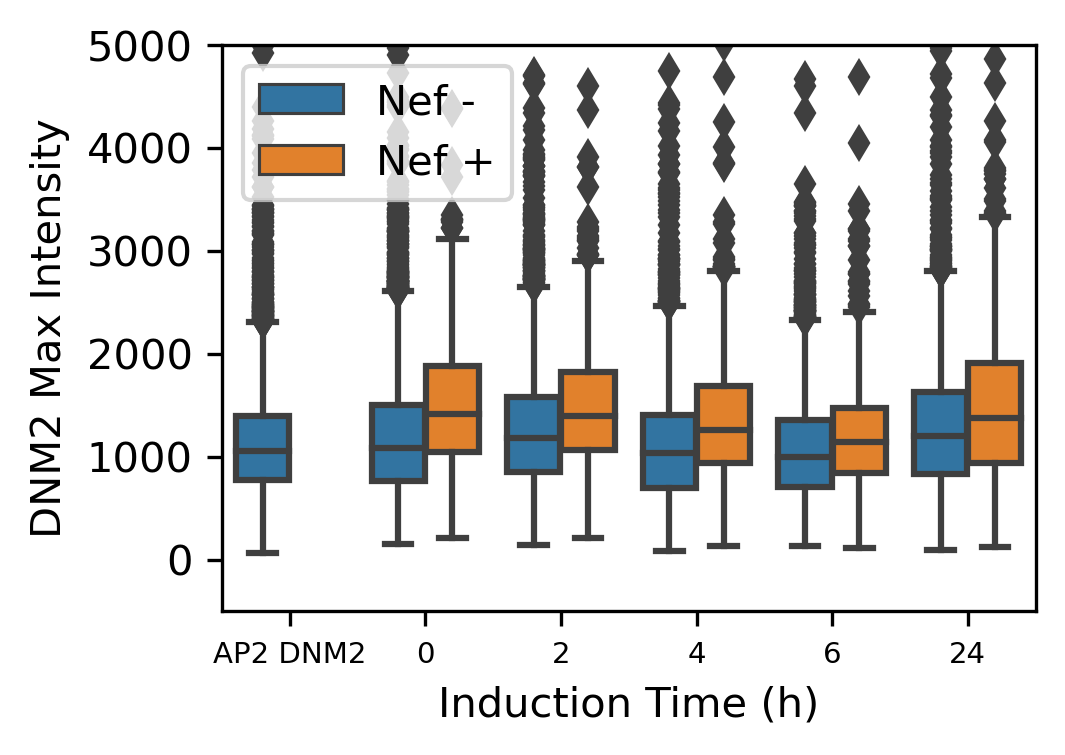

In [88]:
plt.figure(figsize = (3.5,2.5), dpi=300)
ax = sns.boxplot(data=df_features_master[~((df_features_master['nef_status'] == 1) & (df_features_master['condition'] == -1))], x='condition', y='max_dnm2', dodge=True, hue = 'nef_status')
#ax = sns.swarmplot(data=df_sample, x='condition', y = 'lifetime', dodge = True, hue = 'nef_status', size = 2, color = '0.8', edgecolor = '0.25', linewidth = 0.6)

plt.xlabel('Induction Time (h)')
plt.ylabel('DNM2 Max Intensity')
position = [0, 1, 2, 3, 4, 5]
catlabel = ['AP2 DNM2', '0', '2', '4', '6', '24']
plt.xticks(position, catlabel)
plt.xticks(fontsize = 7)

ax.set(ylim = [-500,5000])
ax.legend(handles=ax.legend_.legendHandles, labels=['Nef -', 'Nef +'], loc = 'upper left')

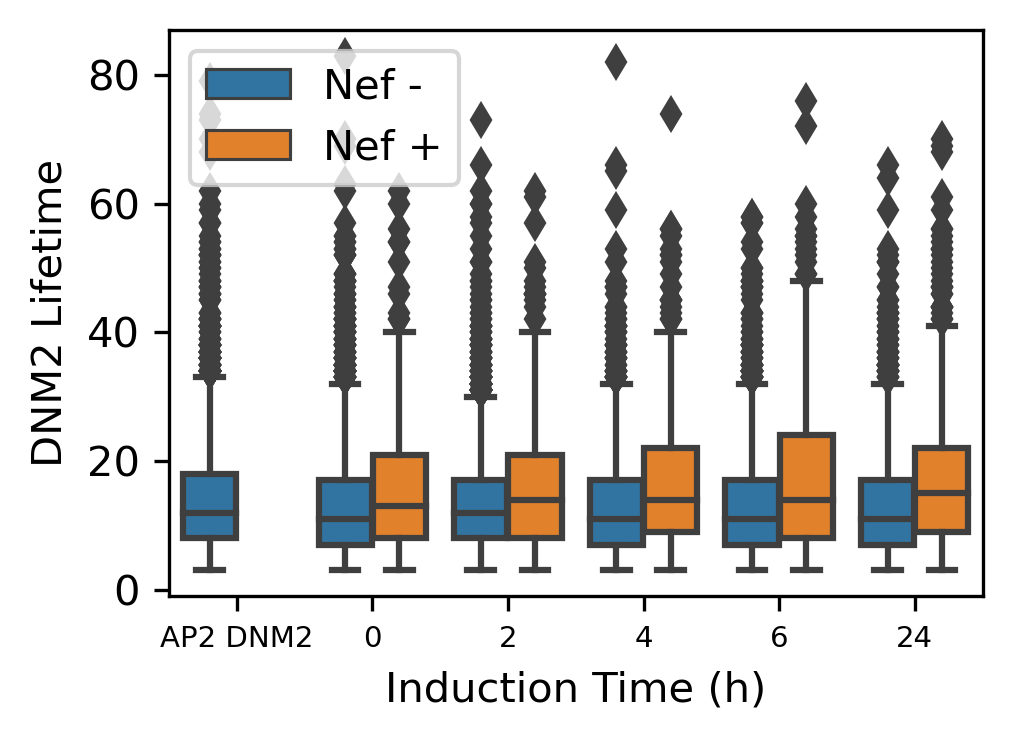

In [89]:
plt.figure(figsize = (3.5,2.5), dpi=300)
ax = sns.boxplot(data=df_features_master[~((df_features_master['nef_status'] == 1) & (df_features_master['condition'] == -1))], x='condition', y='max_consecutive_dnm2', dodge=True, hue = 'nef_status')
#ax = sns.swarmplot(data=df_sample, x='condition', y = 'lifetime', dodge = True, hue = 'nef_status', size = 2, color = '0.8', edgecolor = '0.25', linewidth = 0.6)

plt.xlabel('Induction Time (h)')
plt.ylabel('DNM2 Lifetime')
position = [0, 1, 2, 3, 4, 5]
catlabel = ['AP2 DNM2', '0', '2', '4', '6', '24']
plt.xticks(position, catlabel)
plt.xticks(fontsize = 7)

ax.legend(handles=ax.legend_.legendHandles, labels=['Nef -', 'Nef +'], loc = 'upper left')

## Analysis for no dnm2 filtered tracks

In [53]:
nodnm2_df_features_master = nodnm2_df_features_master[(nodnm2_df_features_master['lifetime'] > 20)]

In [54]:
len(nodnm2_df_features_master)

33737

Text(0, 0.5, 'Probability')

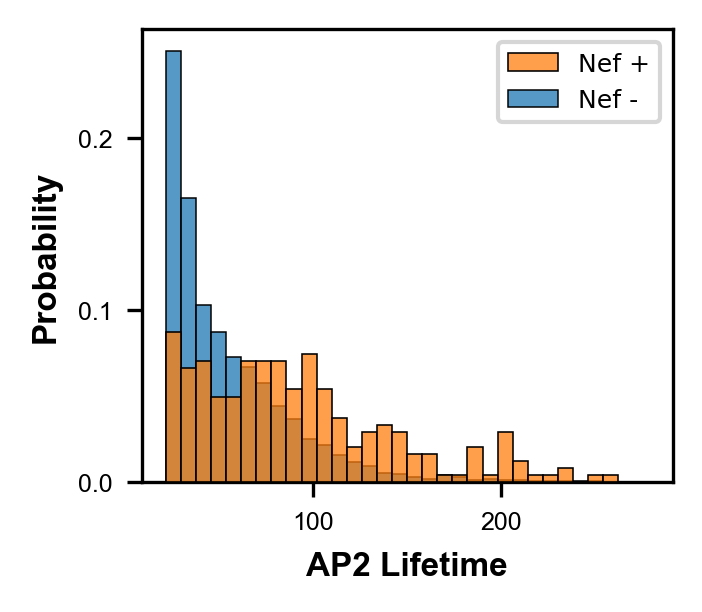

In [55]:
#Generating lifetime histogram for valid set
ax = plt.figure(figsize = (5.8/2.54,5/2.5), dpi=300)
ax = sns.histplot(data=nodnm2_df_features_master[(nodnm2_df_features_master['nef_status'] == 1) & (nodnm2_df_features_master['condition'] == 4)], x = 'lifetime', stat = 'probability', color = 'C1', binwidth = 8, zorder = 10)
ax = sns.histplot(data=nodnm2_df_features_master[(nodnm2_df_features_master['nef_status'] == 0) & (nodnm2_df_features_master['condition'] == 4)], x = 'lifetime', stat = 'probability', binwidth = 8)


ax = plt.legend(title=None, loc='upper right', labels=['Nef +', 'Nef -'], fontsize = 6)
plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)

plt.xlabel('AP2 Lifetime', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('Probability', fontname = "Arial", fontsize = 8, fontweight = "bold")

Text(0, 0.5, 'Probability')

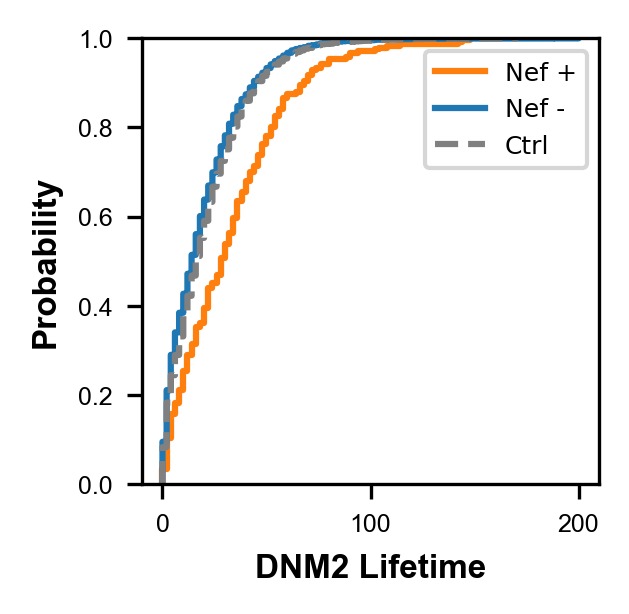

In [73]:
#Base code for CDF. 4 hour induction of Nef condition Specifically for AP2 max intensity
sub_df = nodnm2_df_features_master[nodnm2_df_features_master['condition'] == 4]
ref_df = nodnm2_df_features_master[nodnm2_df_features_master['condition'] == -1]

ax = plt.figure(figsize = (5/2.54,5/2.54), dpi=300)
ax = sns.ecdfplot(data=sub_df, x = 'dnm2_lifetime', hue = 'nef_status')
ax = sns.ecdfplot(data=ref_df, x = 'dnm2_lifetime', color = '0.5', linestyle="dashed")

plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)
#ax.set(xlim = [0,2000])
ax = plt.legend(title=None, loc='upper right', labels=['Nef +', 'Nef -', 'Ctrl'], fontsize = 6)
plt.xlabel('DNM2 Lifetime', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('Probability', fontname = "Arial", fontsize = 8, fontweight = "bold")

In [58]:
dnm2_neg_4h = nodnm2_df_features_master[(nodnm2_df_features_master['dnm2_lifetime'] <= 6) & (nodnm2_df_features_master['condition'] == 4)]
dnm2_pos_4h = nodnm2_df_features_master[(nodnm2_df_features_master['dnm2_lifetime'] > 6) & (nodnm2_df_features_master['condition'] == 4)]
dnm2_neg_ctrl = nodnm2_df_features_master[(nodnm2_df_features_master['dnm2_lifetime'] <= 6) & (nodnm2_df_features_master['condition'] == -1)]
dnm2_pos_ctrl = nodnm2_df_features_master[(nodnm2_df_features_master['dnm2_lifetime'] > 6) & (nodnm2_df_features_master['condition'] == -1)]

In [67]:
dnm2_pos_ratio_4h = len(dnm2_pos_4h)/(len(dnm2_pos_4h) + len(dnm2_neg_4h))
dnm2_pos_ratio_ctrl = len(dnm2_pos_ctrl)/(len(dnm2_pos_ctrl) + len(dnm2_neg_ctrl))

ratio = [dnm2_pos_ratio_ctrl, dnm2_pos_ratio_4h]
dnm2_labels = ['-', '4']

In [68]:
dnm2_coloc_df = pd.DataFrame(columns=['dnm2_pos_fraction', 'condition'])

dnm2_coloc_df['dnm2_pos_fraction'] = ratio
dnm2_coloc_df['condition'] = dnm2_labels

In [69]:
dnm2_coloc_df

,dnm2_pos_fraction,condition
0,0.710209,-
1,0.666993,4


In [64]:
ax = plt.figure(figsize = (4.5/2.54 , 2/2.54), dpi=300)
ax = sns.barplot(data = dnm2_coloc_df, x = 'condition', y = 'dnm2_pos_fraction', size = 2)
#ax = plt.ylim(bottom= 0, top=5000)
ax = plt.xlabel('% DNM2 positive', fontname = "Arial", fontsize = 8, fontweight = "bold")
ax = plt.xticks(fontname = "Arial", fontsize = 6)
ax = plt.yticks(fontname = "Arial", fontsize = 6)


TypeError: Neither the `x` nor `y` variable appears to be numeric.

<Figure size 531.496x236.22 with 0 Axes>

,lifetime,max_ap2,max_dnm2,max_int_nef,dnm2_lifetime,nef_lifetime,condition,nef_status,exp_date
3,90.0,749.675962,893.462150,406.238766,14.0,26.0,2.0,1.0,20211015.0
4,22.0,1322.500385,1192.920485,178.081910,22.0,40.0,2.0,1.0,20211015.0
5,84.0,1335.155542,2957.402631,192.028062,8.0,8.0,2.0,1.0,20211015.0
6,44.0,691.256183,1848.007759,459.218838,20.0,20.0,2.0,1.0,20211015.0
7,38.0,1334.629502,2070.397931,451.565494,10.0,18.0,2.0,1.0,20211015.0
...,...,...,...,...,...,...,...,...,...
24689,68.0,1050.187713,503.652594,109.443259,16.0,2.0,2.0,0.0,20211007.0
24690,68.0,210.496013,622.561280,37.771978,18.0,0.0,2.0,0.0,20211007.0
24691,66.0,242.158327,282.750125,120.720935,8.0,4.0,2.0,0.0,20211007.0
24692,50.0,209.579371,555.838110,100.694946,30.0,8.0,2.0,0.0,20211007.0


In [123]:
nef_pos_dnm_pos = 0
nef_neg_dnm_pos = 0

nef_pos_dnm_pos = len((nodnm2_df_features_master_dnm2[((nodnm2_df_features_master_dnm2['nef_status'] == 1) & (nodnm2_df_features_master_dnm2['condition'] == 4))])/(len(nodnm2_df_features_master_dnm2[((nodnm2_df_features_master_dnm2['nef_status'] == 1) & (nodnm2_df_features_master_dnm2['condition'] == 4))]) + len(nodnm2_df_features_master_nodnm2[((nodnm2_df_features_master_nodnm2['nef_status'] == 1) & (nodnm2_df_features_master_nodnm2['condition'] == 4))]))
nef_neg_dnm_pos = len((nodnm2_df_features_master_dnm2[((nodnm2_df_features_master_dnm2['nef_status'] == 0) & (nodnm2_df_features_master_dnm2['condition'] == 4))])/(len(nodnm2_df_features_master_dnm2[((nodnm2_df_features_master_dnm2['nef_status'] == 0) & (nodnm2_df_features_master_dnm2['condition'] == 4))]) + len(nodnm2_df_features_master_nodnm2[((nodnm2_df_features_master_nodnm2['nef_status'] == 0) & (nodnm2_df_features_master_nodnm2['condition'] == 4))]))

SyntaxError: invalid syntax (<ipython-input-123-d63e408ca102>, line 5)

In [116]:
len(nodnm2_df_features_master_nodnm2)

5732

In [115]:
len(nodnm2_df_features_master_dnm2[nodnm2_df_features_master_dnm2['nef_status'] == 0])

18084

# Values and Statistics

In [82]:
#For WT Nef dataset
ctrl_df = df_features_master[df_features_master['condition'] == -1]
nef_pos_WT_df = df_features_master[(df_features_master['condition'] == 0) & (df_features_master['nef_status'] == 1)]
nef_neg_WT_df = df_features_master[(df_features_master['condition'] == 0) & (df_features_master['nef_status'] == 0)]

#AP2 lifetime
#ctrl vs WT pos
_, p_wt_pos_ctrl = stats.mannwhitneyu(x = ctrl_df['lifetime'].values, y = nef_pos_WT_df['lifetime'].values, use_continuity = False)
#ctrl vs WT neg
_, p_wt_neg_ctrl = stats.mannwhitneyu(x = ctrl_df['lifetime'].values, y = nef_neg_WT_df['lifetime'].values, use_continuity = False)
#WT pos vs WT neg
_, p_wt_neg_wt_pos = stats.mannwhitneyu(x = nef_pos_WT_df['lifetime'].values, y = nef_neg_WT_df['lifetime'].values, use_continuity = False)
print("ctrl mean, stdev")
print(np.mean(ctrl_df['lifetime'].values))
print(np.std(ctrl_df['lifetime'].values))
print("nef pos mean, stdev")
print(np.mean(nef_pos_WT_df['lifetime'].values))
print(np.std(nef_pos_WT_df['lifetime'].values))
print("nef neg mean, stdev")
print(np.mean(nef_neg_WT_df['lifetime'].values))
print(np.std(nef_neg_WT_df['lifetime'].values))

print("ctrl vs wt nef pos")
print(p_wt_pos_ctrl)
print("ctrl vs wt nef neg")
print(p_wt_neg_ctrl)
print("wt nef pos vs wt nef neg")
print(p_wt_neg_wt_pos)

ctrl mean, stdev
83.26874708896135
40.9457360293979
nef pos mean, stdev
109.54037267080746
47.498544441748095
nef neg mean, stdev
79.10843373493977
43.93481012977484
ctrl vs wt nef pos
7.871317990600034e-13
ctrl vs wt nef neg
0.00013776982169071375
wt nef pos vs wt nef neg
4.184626379528563e-15


In [83]:
#AP2 max intensity
_, p_wt_pos_ctrl = stats.mannwhitneyu(x = ctrl_df['max_ap2'].values, y = nef_pos_WT_df['max_ap2'].values, use_continuity = False)
#ctrl vs WT neg
_, p_wt_neg_ctrl = stats.mannwhitneyu(x = ctrl_df['max_ap2'].values, y = nef_neg_WT_df['max_ap2'].values, use_continuity = False)
#WT pos vs WT neg
_, p_wt_neg_wt_pos = stats.mannwhitneyu(x = nef_pos_WT_df['max_ap2'].values, y = nef_neg_WT_df['max_ap2'].values, use_continuity = False)

print("ctrl mean, stdev")
print(np.mean(ctrl_df['max_ap2'].values))
print(np.std(ctrl_df['max_ap2'].values))
print("nef pos mean, stdev")
print(np.mean(nef_pos_WT_df['max_ap2'].values))
print(np.std(nef_pos_WT_df['max_ap2'].values))
print("nef neg mean, stdev")
print(np.mean(nef_neg_WT_df['max_ap2'].values))
print(np.std(nef_neg_WT_df['max_ap2'].values))

print("ctrl vs wt nef pos")
print(p_wt_pos_ctrl)
print("ctrl vs wt nef neg")
print(p_wt_neg_ctrl)
print("wt nef pos vs wt nef neg")
print(p_wt_neg_wt_pos)

ctrl mean, stdev
494.0966546796623
310.2083271422216
nef pos mean, stdev
752.9025873392849
735.6751415302883
nef neg mean, stdev
520.3171684001479
441.1077036604441
ctrl vs wt nef pos
9.022116416611555e-21
ctrl vs wt nef neg
0.13906240033049155
wt nef pos vs wt nef neg
4.102088550402321e-17


In [84]:
#DNM2 lifetime
_, p_wt_pos_ctrl = stats.mannwhitneyu(x = ctrl_df['dnm2_lifetime_gap'].values, y = nef_pos_WT_df['dnm2_lifetime_gap'].values, use_continuity = False)
#ctrl vs WT neg
_, p_wt_neg_ctrl = stats.mannwhitneyu(x = ctrl_df['dnm2_lifetime_gap'].values, y = nef_neg_WT_df['dnm2_lifetime_gap'].values, use_continuity = False)
#WT pos vs WT neg
_, p_wt_neg_wt_pos = stats.mannwhitneyu(x = nef_pos_WT_df['dnm2_lifetime_gap'].values, y = nef_neg_WT_df['dnm2_lifetime_gap'].values, use_continuity = False)

print("ctrl mean, stdev")
print(np.mean(ctrl_df['dnm2_lifetime_gap'].values))
print(np.std(ctrl_df['dnm2_lifetime_gap'].values))
print("nef pos mean, stdev")
print(np.mean(nef_pos_WT_df['dnm2_lifetime_gap'].values))
print(np.std(nef_pos_WT_df['dnm2_lifetime_gap'].values))
print("nef neg mean, stdev")
print(np.mean(nef_neg_WT_df['dnm2_lifetime_gap'].values))
print(np.std(nef_neg_WT_df['dnm2_lifetime_gap'].values))

print("ctrl vs wt nef pos")
print(p_wt_pos_ctrl)
print("ctrl vs wt nef neg")
print(p_wt_neg_ctrl)
print("wt nef pos vs wt nef neg")
print(p_wt_neg_wt_pos)

ctrl mean, stdev
49.43921751280857
27.698933827949652
nef pos mean, stdev
63.81366459627329
34.476962326910865
nef neg mean, stdev
48.20591456736035
29.599467300447277
ctrl vs wt nef pos
4.0633986145066516e-08
ctrl vs wt nef neg
0.0131964053943887
wt nef pos vs wt nef neg
2.4494237240480743e-09


In [87]:
#DNM2 max intensity
_, p_wt_pos_ctrl = stats.mannwhitneyu(x = ctrl_df['max_dnm2'].values, y = nef_pos_WT_df['max_dnm2'].values, use_continuity = False)
#ctrl vs WT neg
_, p_wt_neg_ctrl = stats.mannwhitneyu(x = ctrl_df['max_dnm2'].values, y = nef_neg_WT_df['max_dnm2'].values, use_continuity = False)
#WT pos vs WT neg
_, p_wt_neg_wt_pos = stats.mannwhitneyu(x = nef_pos_WT_df['max_dnm2'].values, y = nef_neg_WT_df['max_dnm2'].values, use_continuity = False)

print("ctrl mean, stdev")
print(np.mean(ctrl_df['max_dnm2'].values))
print(np.std(ctrl_df['max_dnm2'].values))
print("nef pos mean, stdev")
print(np.mean(nef_pos_WT_df['max_dnm2'].values))
print(np.std(nef_pos_WT_df['max_dnm2'].values))
print("nef neg mean, stdev")
print(np.mean(nef_neg_WT_df['max_dnm2'].values))
print(np.std(nef_neg_WT_df['max_dnm2'].values))

print("ctrl vs wt nef pos")
print(p_wt_pos_ctrl)
print("ctrl vs wt nef neg")
print(p_wt_neg_ctrl)
print("wt nef pos vs wt nef neg")
print(p_wt_neg_wt_pos)

ctrl mean, stdev
965.5097048323811
435.88897722276204
nef pos mean, stdev
1059.8358868123728
429.9803324740708
nef neg mean, stdev
1029.1891420433085
613.9382526660439
ctrl vs wt nef pos
0.0007858176738369266
ctrl vs wt nef neg
0.010154926097334217
wt nef pos vs wt nef neg
0.047393765105021766


In [89]:
#For LLAA Nef
nef_pos_LLAA_df = df_features_master[(df_features_master['condition'] == 1) & (df_features_master['nef_status'] == 1)]
nef_neg_LLAA_df = df_features_master[(df_features_master['condition'] == 1) & (df_features_master['nef_status'] == 0)]

#AP2 lifetime
#ctrl vs LLAA pos
_, p_LLAA_pos_ctrl = stats.mannwhitneyu(x = ctrl_df['lifetime'].values, y = nef_pos_LLAA_df['lifetime'].values, use_continuity = False)
#ctrl vs LLAA neg
_, p_LLAA_neg_ctrl = stats.mannwhitneyu(x = ctrl_df['lifetime'].values, y = nef_neg_LLAA_df['lifetime'].values, use_continuity = False)
#LLAA pos vs LLAA neg
_, p_LLAA_neg_LLAA_pos = stats.mannwhitneyu(x = nef_pos_LLAA_df['lifetime'].values, y = nef_neg_LLAA_df['lifetime'].values, use_continuity = False)
#LLAA pos vs WT pos
_, p_WT_pos_LLAA_pos = stats.mannwhitneyu(x = nef_pos_WT_df['lifetime'].values, y = nef_pos_LLAA_df['lifetime'].values, use_continuity = False)

print("ctrl mean, stdev")
print(np.mean(ctrl_df['lifetime'].values))
print(np.std(ctrl_df['lifetime'].values))
print("nef pos mean, stdev")
print(np.mean(nef_pos_LLAA_df['lifetime'].values))
print(np.std(nef_pos_LLAA_df['lifetime'].values))
print("nef neg mean, stdev")
print(np.mean(nef_neg_LLAA_df['lifetime'].values))
print(np.std(nef_neg_LLAA_df['lifetime'].values))

print("ctrl vs LLAA nef pos")
print(p_LLAA_pos_ctrl)
print("ctrl vs LLAA nef neg")
print(p_LLAA_neg_ctrl)
print("LLAA nef pos vs LLAA nef neg")
print(p_LLAA_neg_LLAA_pos)
print("wt nef pos vs LLAA nef pos")
print(p_WT_pos_LLAA_pos)


ctrl mean, stdev
83.26874708896135
40.9457360293979
nef pos mean, stdev
89.0
37.24488982641536
nef neg mean, stdev
81.32233883058471
40.95072727919236
ctrl vs LLAA nef pos
0.16971700360802544
ctrl vs LLAA nef neg
0.06046073642731765
LLAA nef pos vs LLAA nef neg
0.11800487787401598
wt nef pos vs LLAA nef pos
0.030512899867301293


In [90]:
#AP2 max int
#ctrl vs LLAA pos
_, p_LLAA_pos_ctrl = stats.mannwhitneyu(x = ctrl_df['max_ap2'].values, y = nef_pos_LLAA_df['max_ap2'].values, use_continuity = False)
#ctrl vs LLAA neg
_, p_LLAA_neg_ctrl = stats.mannwhitneyu(x = ctrl_df['max_ap2'].values, y = nef_neg_LLAA_df['max_ap2'].values, use_continuity = False)
#LLAA pos vs LLAA neg
_, p_LLAA_neg_LLAA_pos = stats.mannwhitneyu(x = nef_pos_LLAA_df['max_ap2'].values, y = nef_neg_LLAA_df['max_ap2'].values, use_continuity = False)
#LLAA pos vs WT pos
_, p_WT_pos_LLAA_pos = stats.mannwhitneyu(x = nef_pos_WT_df['max_ap2'].values, y = nef_pos_LLAA_df['max_ap2'].values, use_continuity = False)

print("ctrl mean, stdev")
print(np.mean(ctrl_df['max_ap2'].values))
print(np.std(ctrl_df['max_ap2'].values))
print("nef pos mean, stdev")
print(np.mean(nef_pos_LLAA_df['max_ap2'].values))
print(np.std(nef_pos_LLAA_df['max_ap2'].values))
print("nef neg mean, stdev")
print(np.mean(nef_neg_LLAA_df['max_ap2'].values))
print(np.std(nef_neg_LLAA_df['max_ap2'].values))

print("ctrl vs LLAA nef pos")
print(p_LLAA_pos_ctrl)
print("ctrl vs LLAA nef neg")
print(p_LLAA_neg_ctrl)
print("LLAA nef pos vs LLAA nef neg")
print(p_LLAA_neg_LLAA_pos)
print("wt nef pos vs LLAA nef pos")
print(p_WT_pos_LLAA_pos)


ctrl mean, stdev
494.0966546796623
310.2083271422216
nef pos mean, stdev
552.7571782637143
377.0925821427325
nef neg mean, stdev
566.1023984189073
361.82838229115094
ctrl vs LLAA nef pos
0.29722239544604206
ctrl vs LLAA nef neg
5.58634268091189e-08
LLAA nef pos vs LLAA nef neg
0.38408415786480277
wt nef pos vs LLAA nef pos
0.005337849586297725


In [91]:
#DNM2 lifetime
#ctrl vs LLAA pos
_, p_LLAA_pos_ctrl = stats.mannwhitneyu(x = ctrl_df['dnm2_lifetime_gap'].values, y = nef_pos_LLAA_df['dnm2_lifetime_gap'].values, use_continuity = False)
#ctrl vs LLAA neg
_, p_LLAA_neg_ctrl = stats.mannwhitneyu(x = ctrl_df['dnm2_lifetime_gap'].values, y = nef_neg_LLAA_df['dnm2_lifetime_gap'].values, use_continuity = False)
#LLAA pos vs LLAA neg
_, p_LLAA_neg_LLAA_pos = stats.mannwhitneyu(x = nef_pos_LLAA_df['dnm2_lifetime_gap'].values, y = nef_neg_LLAA_df['dnm2_lifetime_gap'].values, use_continuity = False)
#LLAA pos vs WT pos
_, p_WT_pos_LLAA_pos = stats.mannwhitneyu(x = nef_pos_WT_df['dnm2_lifetime_gap'].values, y = nef_pos_LLAA_df['dnm2_lifetime_gap'].values, use_continuity = False)

print("ctrl mean, stdev")
print(np.mean(ctrl_df['dnm2_lifetime_gap'].values))
print(np.std(ctrl_df['dnm2_lifetime_gap'].values))
print("nef pos mean, stdev")
print(np.mean(nef_pos_LLAA_df['dnm2_lifetime_gap'].values))
print(np.std(nef_pos_LLAA_df['dnm2_lifetime_gap'].values))
print("nef neg mean, stdev")
print(np.mean(nef_neg_LLAA_df['dnm2_lifetime_gap'].values))
print(np.std(nef_neg_LLAA_df['dnm2_lifetime_gap'].values))

print("ctrl vs LLAA nef pos")
print(p_LLAA_pos_ctrl)
print("ctrl vs LLAA nef neg")
print(p_LLAA_neg_ctrl)
print("LLAA nef pos vs LLAA nef neg")
print(p_LLAA_neg_LLAA_pos)
print("wt nef pos vs LLAA nef pos")
print(p_WT_pos_LLAA_pos)


ctrl mean, stdev
49.43921751280857
27.698933827949652
nef pos mean, stdev
46.27272727272727
25.664233722478127
nef neg mean, stdev
48.43178410794603
28.30079507300961
ctrl vs LLAA nef pos
0.31153278310592486
ctrl vs LLAA nef neg
0.06373666835695307
LLAA nef pos vs LLAA nef neg
0.3911963943258581
wt nef pos vs LLAA nef pos
0.01082670372767094


In [92]:
#DNM2 max intensity
#ctrl vs LLAA pos
_, p_LLAA_pos_ctrl = stats.mannwhitneyu(x = ctrl_df['max_dnm2'].values, y = nef_pos_LLAA_df['max_dnm2'].values, use_continuity = False)
#ctrl vs LLAA neg
_, p_LLAA_neg_ctrl = stats.mannwhitneyu(x = ctrl_df['max_dnm2'].values, y = nef_neg_LLAA_df['max_dnm2'].values, use_continuity = False)
#LLAA pos vs LLAA neg
_, p_LLAA_neg_LLAA_pos = stats.mannwhitneyu(x = nef_pos_LLAA_df['max_dnm2'].values, y = nef_neg_LLAA_df['max_dnm2'].values, use_continuity = False)
#LLAA pos vs WT pos
_, p_WT_pos_LLAA_pos = stats.mannwhitneyu(x = nef_pos_WT_df['max_dnm2'].values, y = nef_pos_LLAA_df['max_dnm2'].values, use_continuity = False)

print("ctrl mean, stdev")
print(np.mean(ctrl_df['max_dnm2'].values))
print(np.std(ctrl_df['max_dnm2'].values))
print("nef pos mean, stdev")
print(np.mean(nef_pos_LLAA_df['max_dnm2'].values))
print(np.std(nef_pos_LLAA_df['max_dnm2'].values))
print("nef neg mean, stdev")
print(np.mean(nef_neg_LLAA_df['max_dnm2'].values))
print(np.std(nef_neg_LLAA_df['max_dnm2'].values))

print("ctrl vs LLAA nef pos")
print(p_LLAA_pos_ctrl)
print("ctrl vs LLAA nef neg")
print(p_LLAA_neg_ctrl)
print("LLAA nef pos vs LLAA nef neg")
print(p_LLAA_neg_LLAA_pos)
print("wt nef pos vs LLAA nef pos")
print(p_WT_pos_LLAA_pos)

ctrl mean, stdev
965.5097048323811
435.88897722276204
nef pos mean, stdev
1111.6713189603736
418.9775871268586
nef neg mean, stdev
1143.4715543475813
536.1323156679409
ctrl vs LLAA nef pos
0.012320453481737515
ctrl vs LLAA nef neg
8.542317450402384e-30
LLAA nef pos vs LLAA nef neg
0.42382290723463667
wt nef pos vs LLAA nef pos
0.1725803146632353


In [94]:
#Nef lifetime
#ctrl vs WT pos
_, p_wt_pos_ctrl = stats.mannwhitneyu(x = ctrl_df['nef_lifetime_gap'].values, y = nef_pos_WT_df['nef_lifetime_gap'].values, use_continuity = False)
#ctrl vs LLAA pos
_, p_LLAA_pos_ctrl = stats.mannwhitneyu(x = ctrl_df['nef_lifetime_gap'].values, y = nef_pos_LLAA_df['nef_lifetime_gap'].values, use_continuity = False)
#WT pos vs LLAA pos
_, p_LLAA_pos_wt_pos = stats.mannwhitneyu(x = nef_pos_WT_df['nef_lifetime_gap'].values, y = nef_pos_LLAA_df['nef_lifetime_gap'].values, use_continuity = False)
print("ctrl mean, stdev")
print(np.mean(ctrl_df['nef_lifetime_gap'].values))
print(np.std(ctrl_df['nef_lifetime_gap'].values))
print("WT nef pos mean, stdev")
print(np.mean(nef_pos_WT_df['nef_lifetime_gap'].values))
print(np.std(nef_pos_WT_df['nef_lifetime_gap'].values))
print("LLAA nef pos mean, stdev")
print(np.mean(nef_pos_LLAA_df['nef_lifetime_gap'].values))
print(np.std(nef_pos_LLAA_df['nef_lifetime_gap'].values))

print("ctrl vs wt nef pos")
print(p_wt_pos_ctrl)
print("ctrl vs LLAA nef pos")
print(p_LLAA_pos_ctrl)
print("wt nef pos vs LLAA nef pos")
print(p_LLAA_pos_wt_pos)

ctrl mean, stdev
1.6618537494177923
4.742778484318751
WT nef pos mean, stdev
57.316770186335404
36.01801177434701
LLAA nef pos mean, stdev
42.63636363636363
28.273896497308186
ctrl vs wt nef pos
1.6905468277010427e-120
ctrl vs LLAA nef pos
5.878315712142857e-20
wt nef pos vs LLAA nef pos
0.02137783332226762


In [96]:
#Nef max intensity
#ctrl vs WT pos
_, p_wt_pos_ctrl = stats.mannwhitneyu(x = ctrl_df['max_int_nef'].values, y = nef_pos_WT_df['max_int_nef'].values, use_continuity = False)
#ctrl vs LLAA pos
_, p_LLAA_pos_ctrl = stats.mannwhitneyu(x = ctrl_df['max_int_nef'].values, y = nef_pos_LLAA_df['max_int_nef'].values, use_continuity = False)
#WT pos vs LLAA pos
_, p_LLAA_pos_wt_pos = stats.mannwhitneyu(x = nef_pos_WT_df['max_int_nef'].values, y = nef_pos_LLAA_df['max_int_nef'].values, use_continuity = False)
print("ctrl mean, stdev")
print(np.mean(ctrl_df['max_int_nef'].values))
print(np.std(ctrl_df['max_int_nef'].values))
print("WT nef pos mean, stdev")
print(np.mean(nef_pos_WT_df['max_int_nef'].values))
print(np.std(nef_pos_WT_df['max_int_nef'].values))
print("LLAA nef pos mean, stdev")
print(np.mean(nef_pos_LLAA_df['max_int_nef'].values))
print(np.std(nef_pos_LLAA_df['max_int_nef'].values))

print("ctrl vs wt nef pos")
print(p_wt_pos_ctrl)
print("ctrl vs LLAA nef pos")
print(p_LLAA_pos_ctrl)
print("wt nef pos vs LLAA nef pos")
print(p_LLAA_pos_wt_pos)

ctrl mean, stdev
37.46504237902901
23.52468264726071
WT nef pos mean, stdev
667.19158874983
712.5223410182432
LLAA nef pos mean, stdev
465.3248477974176
333.4734518136607
ctrl vs wt nef pos
3.0242620274540216e-99
ctrl vs LLAA nef pos
6.773671374061696e-16
wt nef pos vs LLAA nef pos
0.07468329432013013
